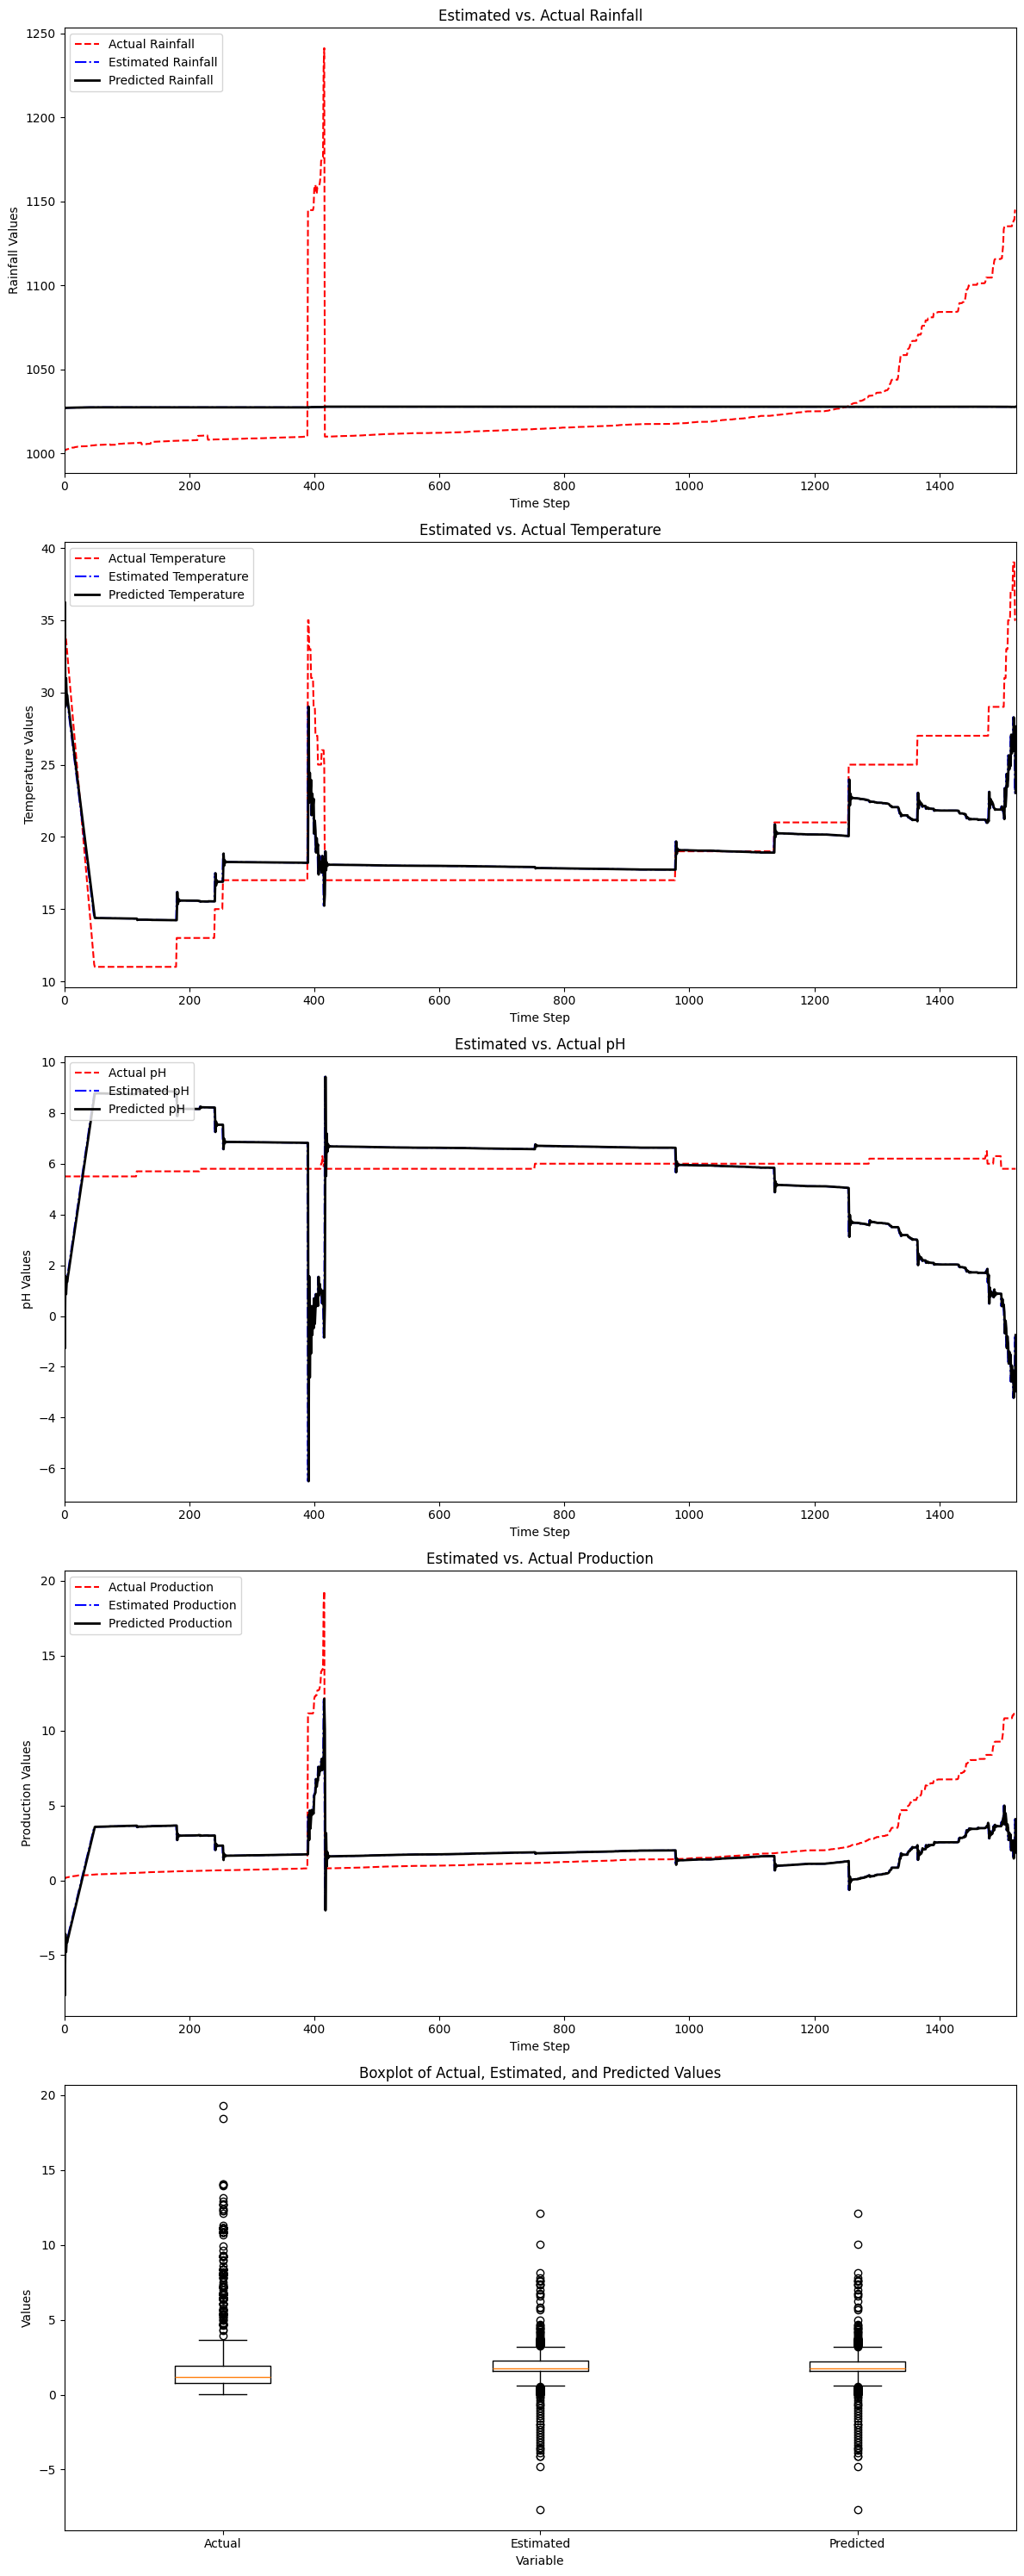

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg

# ... (rest of your code remains unchanged)

# Create subplots for each variable and a boxplot
fig, axs = plt.subplots(num_states + 1, 1, figsize=(12, 6 * (num_states + 1)))

# Loop through each variable
for i, col in enumerate(selected_columns):
    # Plot the actual data in the back (dashed line)
    axs[i].plot(data[col], label=f'Actual {col}', linestyle='--', color='red')

    # Plot the state estimate in blue (dotted line)
    axs[i].plot(state_estimate_df[col], label=f'Estimated {col}', linestyle='-.', color='blue', zorder=2)

    # Plot the predicted values in front (solid line)
    axs[i].plot(predicted_measurement_df[col], label=f'Predicted {col}', linewidth=2, color='black', zorder=3)

    # Include the legend for actual and estimated values
    axs[i].legend([f'Actual {col}', f'Estimated {col}', f'Predicted {col}'], loc='upper left')

    axs[i].set_title(f'Estimated vs. Actual {col}')
    axs[i].set_xlabel('Time Step')
    axs[i].set_ylabel(f'{col} Values')

    # Adjust plot limits to ensure all values are visible
    axs[i].set_xlim(0, num_time_steps)

    # Remove grid lines
    axs[i].grid(False)

# Boxplot for each variable
axs[-1].boxplot([data[col], state_estimate_df[col], predicted_measurement_df[col]], labels=['Actual', 'Estimated', 'Predicted'])
axs[-1].set_title('Boxplot of Actual, Estimated, and Predicted Values')
axs[-1].set_xlabel('Variable')
axs[-1].set_ylabel('Values')

plt.tight_layout()
plt.show()

# ... (rest of your code remains unchanged)


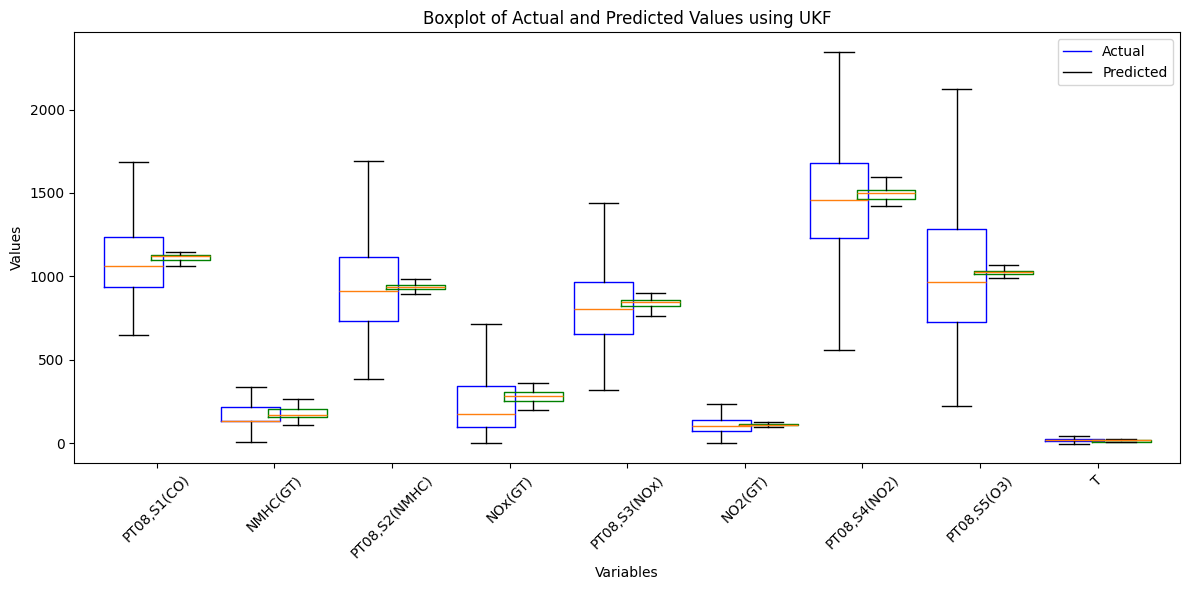

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/EUKF.xlsx"
data = pd.read_excel(file_path)

# Ensure the dataset has a total sample size of 9357 by taking the first 9357 rows
data = data.head(9357)

# List of variable names
variable_names = [
    "PT08,S1(CO)", "NMHC(GT)", "PT08,S2(NMHC)", "NOx(GT)",
    "PT08,S3(NOx)", "NO2(GT)", "PT08,S4(NO2)", "PT08,S5(O3)", "T"
]

# Create boxplots for the actual and predicted values of the specified variables
plt.figure(figsize=(12, 6))
data_to_plot_actual = [data[f'Actual_{var_name}'] for var_name in variable_names]
data_to_plot_predicted = [data[f'Predicted_{var_name}'] for var_name in variable_names]

# Define box properties for actual and predicted
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')
boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual and predicted values
plt.boxplot(data_to_plot_actual, showfliers=False, positions=[pos - width/2 for pos in positions], boxprops=boxprops_actual)
plt.boxplot(data_to_plot_predicted, showfliers=False, positions=[pos + width/2 for pos in positions], boxprops=boxprops_predicted)

plt.xticks(positions, variable_names, rotation=45)
plt.title("Boxplot of Actual and Predicted Values using UKF")
plt.xlabel("Variables")
plt.ylabel("Values")

# Create a single legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.tight_layout()
plt.show()


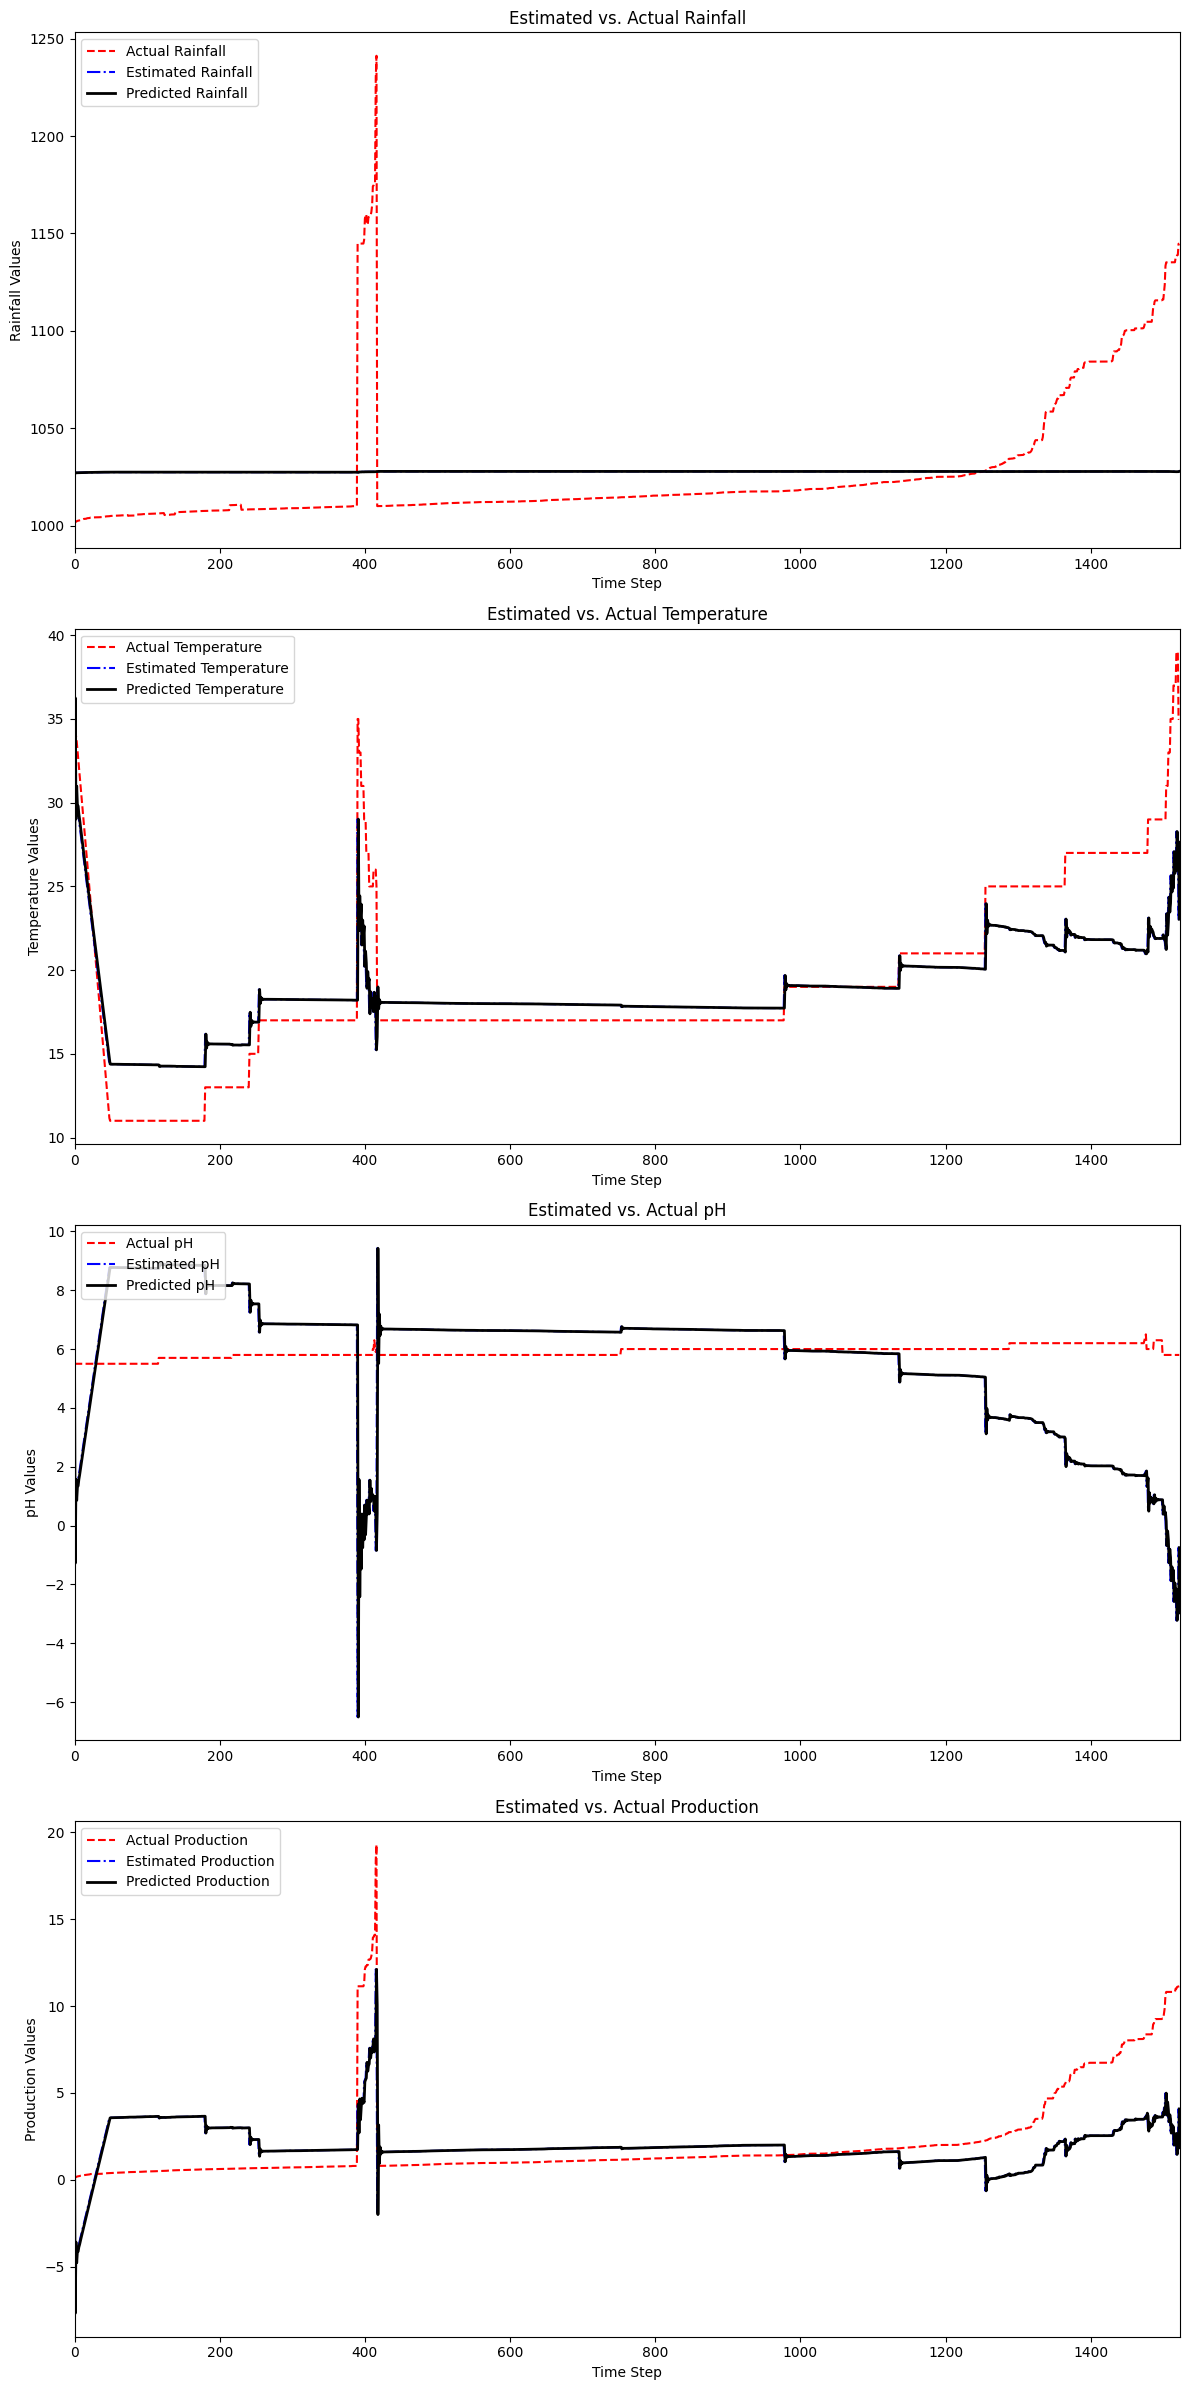

Actual data without timestamp saved to: /Users/egasarmando/Desktop/actual_data.csv


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg

# Define the system dynamics (for demonstration, we use a simple identity model)
def process_model(x):
    return x

# Define the measurement model for the selected variables (adding noise for simulation)
def measurement_model(x):
    # Simulated measurements with noise for the selected variables
    true_measurements = x + np.random.normal(0, 0.1, len(x))
    return true_measurements

# Load data from an Excel file (replace with your file path)
file_path = "/Users/egasarmando/Desktop/soil.xlsx"

# Read data from the Excel file
data = pd.read_excel(file_path)

# Extract column names (variables) from the loaded data
selected_columns = data.columns

# Initialize UKF parameters
num_states = len(selected_columns)
initial_state = data[selected_columns].mean().values
initial_covariance = np.eye(num_states)
process_noise_covariance = np.diag(np.ones(num_states) * 0.01)
measurement_noise_covariance = np.diag(np.ones(num_states) * 0.1)

# UKF parameters
alpha = 1e-3
beta = 2.0
kappa = 0.0

# Calculate the number of time steps based on the length of your data
num_time_steps = len(data)

# Initialize lists to store predicted measurements, state estimates, and timestamps
predicted_measurements = []
state_estimates = []

for t in range(num_time_steps):
    # Simulate measurements (replace with real sensor data)
    true_measurement = measurement_model(initial_state)

    # Generate sigma points using Cholesky decomposition
    num_sigma_points = 2 * num_states + 1
    chol_covariance = scipy.linalg.cholesky((num_states + kappa) * process_noise_covariance, lower=True)
    sigma_points = np.zeros((num_states, num_sigma_points))

    # First sigma point is the mean
    sigma_points[:, 0] = initial_state

    # Generate positive and negative sigma points
    for i in range(num_states):
        sigma_points[:, i + 1] = initial_state + np.sqrt(num_states + kappa) * chol_covariance[:, i]
        sigma_points[:, i + 1 + num_states] = initial_state - np.sqrt(num_states + kappa) * chol_covariance[:, i]

    # Predict the next state through the process model
    predicted_state = process_model(sigma_points)

    # Calculate the predicted state mean and covariance
    predicted_state_mean = np.mean(predicted_state, axis=1)
    predicted_state_covariance = np.cov(predicted_state)

    # Calculate the Kalman gain with regularization
    measurement_sigma_points = np.column_stack((predicted_state_mean, predicted_state_mean + np.sqrt(num_states + kappa) * measurement_noise_covariance, predicted_state_mean - np.sqrt(num_states + kappa) * measurement_noise_covariance))
    cross_covariance = np.dot((sigma_points - predicted_state_mean[:, np.newaxis]), (measurement_sigma_points - predicted_state_mean[:, np.newaxis]).T)
    epsilon = 1e-6  # A small regularization term
    measurement_covariance_reg = np.cov(measurement_sigma_points) + measurement_noise_covariance + epsilon * np.eye(num_states)
    kalman_gain = np.dot(cross_covariance, np.linalg.inv(measurement_covariance_reg))

    # Update the state estimate and covariance
    innovation = data.iloc[t][selected_columns] - predicted_state_mean
    updated_state = predicted_state_mean + np.dot(kalman_gain, innovation)
    updated_covariance = predicted_state_covariance - np.dot(np.dot(kalman_gain, np.cov(measurement_sigma_points)), kalman_gain.T)

    # Append predicted measurements and state estimates to the lists
    predicted_measurements.append(predicted_state_mean)
    state_estimates.append(updated_state)

    # Update initial state and covariance for the next time step
    initial_state = updated_state
    initial_covariance = updated_covariance

# Convert the predicted measurements and state estimates to DataFrames
predicted_measurement_df = pd.DataFrame(predicted_measurements, columns=selected_columns)
state_estimate_df = pd.DataFrame(state_estimates, columns=selected_columns)

# Create subplots for each variable
plt.figure(figsize=(12, 6 * num_states))

for i, col in enumerate(selected_columns):
    plt.subplot(num_states, 1, i + 1)

    # Plot the actual data in the back (dashed line)
    plt.plot(data[col], label=f'Actual {col}', linestyle='--', color='red')

    # Plot the state estimate in blue (dotted line)
    plt.plot(state_estimate_df[col], label=f'Estimated {col}', linestyle='-.', color='blue', zorder=2)

    # Plot the predicted values in front (solid line)
    plt.plot(predicted_measurement_df[col], label=f'Predicted {col}', linewidth=2, color='black', zorder=3)

    # Include the legend for actual and estimated values
    plt.legend([f'Actual {col}', f'Estimated {col}', f'Predicted {col}'], loc='upper left')

    plt.title(f'Estimated vs. Actual {col}')
    plt.xlabel('Time Step')
    plt.ylabel(f'{col} Values')

    # Adjust plot limits to ensure all values are visible
    plt.xlim(0, num_time_steps)

    # Remove grid lines
    plt.grid(False)

plt.tight_layout()
plt.show()

# Define file paths for saving the CSV files on your desktop
actual_data_file = "/Users/egasarmando/Desktop/actual_data.csv"
predicted_data_file = "/Users/egasarmando/Desktop/predicted_data.csv"

# Save the DataFrames to CSV files without timestamp
data.to_csv(actual_data_file, index=False)  # Save actual data without timestamp
predicted_measurement_df.to_csv(predicted_data_file, index=False)  # Save predicted data without timestamp

# Print a message indicating where the files without timestamp have been saved
print(f"Actual data without timestamp saved to: {actual_data_file}")


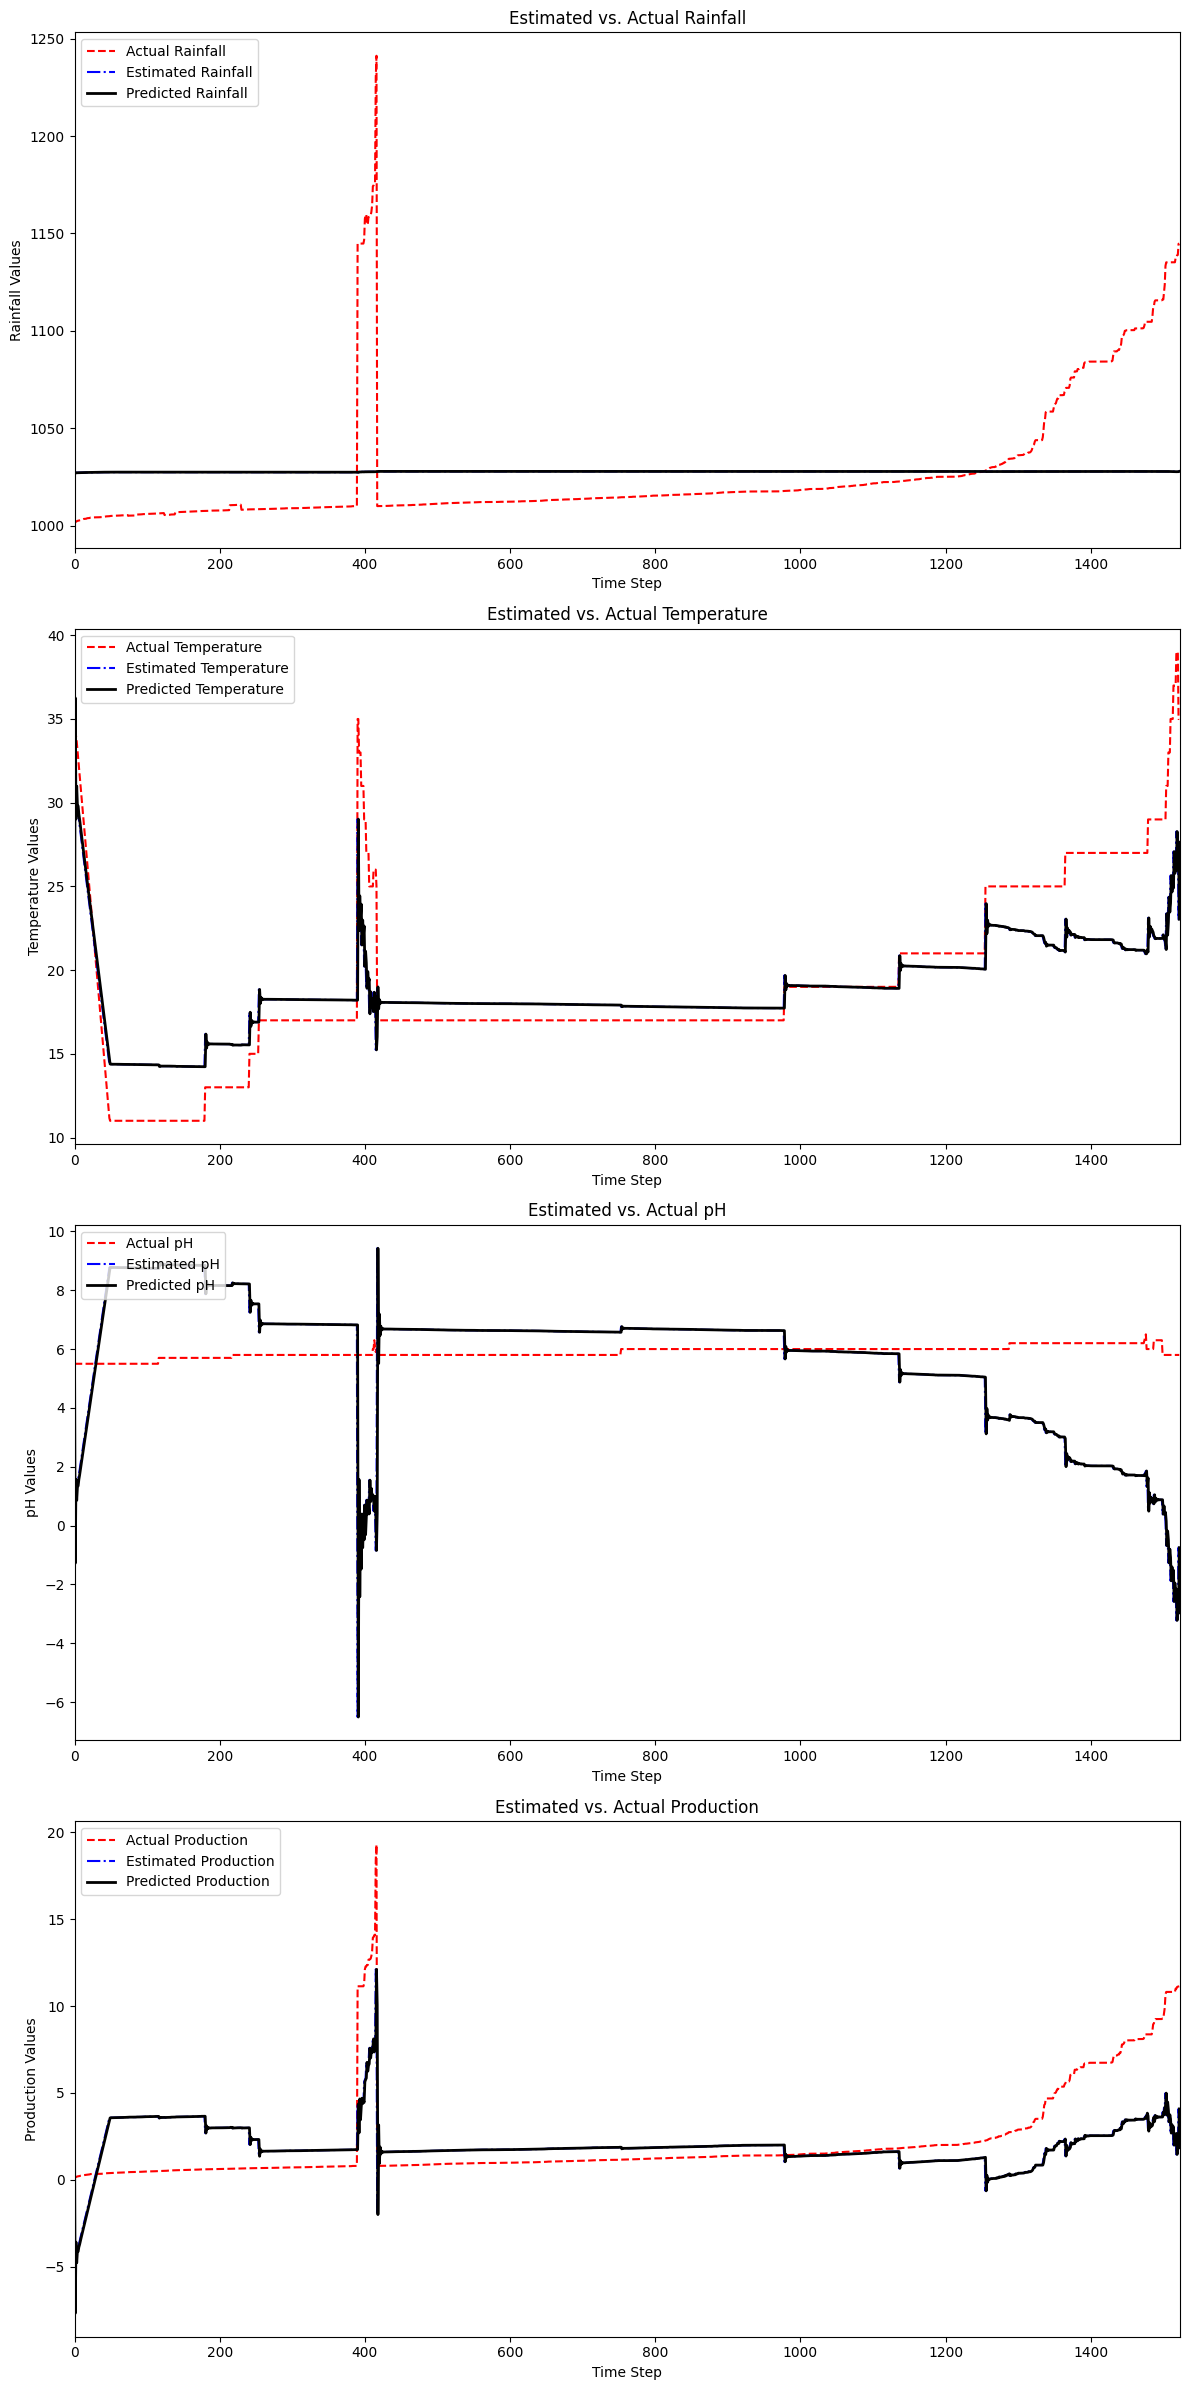

Combined data saved to: /Users/egasarmando/Desktop/combined_data.csv


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg

# Define the system dynamics (for demonstration, we use a simple identity model)
def process_model(x):
    return x

# Define the measurement model for the selected variables (adding noise for simulation)
def measurement_model(x):
    # Simulated measurements with noise for the selected variables
    true_measurements = x + np.random.normal(0, 0.1, len(x))
    return true_measurements

# Load data from an Excel file (replace with your file path)
file_path = "/Users/egasarmando/Desktop/soil.xlsx"

# Read data from the Excel file
data = pd.read_excel(file_path)

# Extract column names (variables) from the loaded data
selected_columns = data.columns

# Initialize UKF parameters
num_states = len(selected_columns)
initial_state = data[selected_columns].mean().values
initial_covariance = np.eye(num_states)
process_noise_covariance = np.diag(np.ones(num_states) * 0.01)
measurement_noise_covariance = np.diag(np.ones(num_states) * 0.1)

# UKF parameters
alpha = 1e-3
beta = 2.0
kappa = 0.0

# Calculate the number of time steps based on the length of your data
num_time_steps = len(data)

# Initialize lists to store predicted measurements, state estimates, and timestamps
predicted_measurements = []
state_estimates = []

for t in range(num_time_steps):
    # Simulate measurements (replace with real sensor data)
    true_measurement = measurement_model(initial_state)

    # Generate sigma points using Cholesky decomposition
    num_sigma_points = 2 * num_states + 1
    chol_covariance = scipy.linalg.cholesky((num_states + kappa) * process_noise_covariance, lower=True)
    sigma_points = np.zeros((num_states, num_sigma_points))

    # First sigma point is the mean
    sigma_points[:, 0] = initial_state

    # Generate positive and negative sigma points
    for i in range(num_states):
        sigma_points[:, i + 1] = initial_state + np.sqrt(num_states + kappa) * chol_covariance[:, i]
        sigma_points[:, i + 1 + num_states] = initial_state - np.sqrt(num_states + kappa) * chol_covariance[:, i]

    # Predict the next state through the process model
    predicted_state = process_model(sigma_points)

    # Calculate the predicted state mean and covariance
    predicted_state_mean = np.mean(predicted_state, axis=1)
    predicted_state_covariance = np.cov(predicted_state)

    # Calculate the Kalman gain with regularization
    measurement_sigma_points = np.column_stack((predicted_state_mean, predicted_state_mean + np.sqrt(num_states + kappa) * measurement_noise_covariance, predicted_state_mean - np.sqrt(num_states + kappa) * measurement_noise_covariance))
    cross_covariance = np.dot((sigma_points - predicted_state_mean[:, np.newaxis]), (measurement_sigma_points - predicted_state_mean[:, np.newaxis]).T)
    epsilon = 1e-6  # A small regularization term
    measurement_covariance_reg = np.cov(measurement_sigma_points) + measurement_noise_covariance + epsilon * np.eye(num_states)
    kalman_gain = np.dot(cross_covariance, np.linalg.inv(measurement_covariance_reg))

    # Update the state estimate and covariance
    innovation = data.iloc[t][selected_columns] - predicted_state_mean
    updated_state = predicted_state_mean + np.dot(kalman_gain, innovation)
    updated_covariance = predicted_state_covariance - np.dot(np.dot(kalman_gain, np.cov(measurement_sigma_points)), kalman_gain.T)

    # Append predicted measurements and state estimates to the lists
    predicted_measurements.append(predicted_state_mean)
    state_estimates.append(updated_state)

    # Update initial state and covariance for the next time step
    initial_state = updated_state
    initial_covariance = updated_covariance

# Convert the predicted measurements and state estimates to DataFrames
predicted_measurement_df = pd.DataFrame(predicted_measurements, columns=selected_columns)
state_estimate_df = pd.DataFrame(state_estimates, columns=selected_columns)

# Concatenate the actual and predicted DataFrames along the columns
combined_data_df = pd.concat([data[selected_columns], predicted_measurement_df], axis=1)

# Create subplots for each variable
plt.figure(figsize=(12, 6 * num_states))

for i, col in enumerate(selected_columns):
    plt.subplot(num_states, 1, i + 1)

    # Plot the actual data in the back (dashed line)
    plt.plot(data[col], label=f'Actual {col}', linestyle='--', color='red')

    # Plot the state estimate in blue (dotted line)
    plt.plot(state_estimate_df[col], label=f'Estimated {col}', linestyle='-.', color='blue', zorder=2)

    # Plot the predicted values in front (solid line)
    plt.plot(predicted_measurement_df[col], label=f'Predicted {col}', linewidth=2, color='black', zorder=3)

    # Include the legend for actual and estimated values
    plt.legend([f'Actual {col}', f'Estimated {col}', f'Predicted {col}'], loc='upper left')

    plt.title(f'Estimated vs. Actual {col}')
    plt.xlabel('Time Step')
    plt.ylabel(f'{col} Values')

    # Adjust plot limits to ensure all values are visible
    plt.xlim(0, num_time_steps)

    # Remove grid lines
    plt.grid(False)

plt.tight_layout()
plt.show()

# Define file path for saving the combined CSV file on your desktop
combined_data_file = "/Users/egasarmando/Desktop/combined_data.csv"

# Save the combined DataFrame to a CSV file
combined_data_df.to_csv(combined_data_file, index=False)

# Print a message indicating where the combined file has been saved
print(f"Combined data saved to: {combined_data_file}")


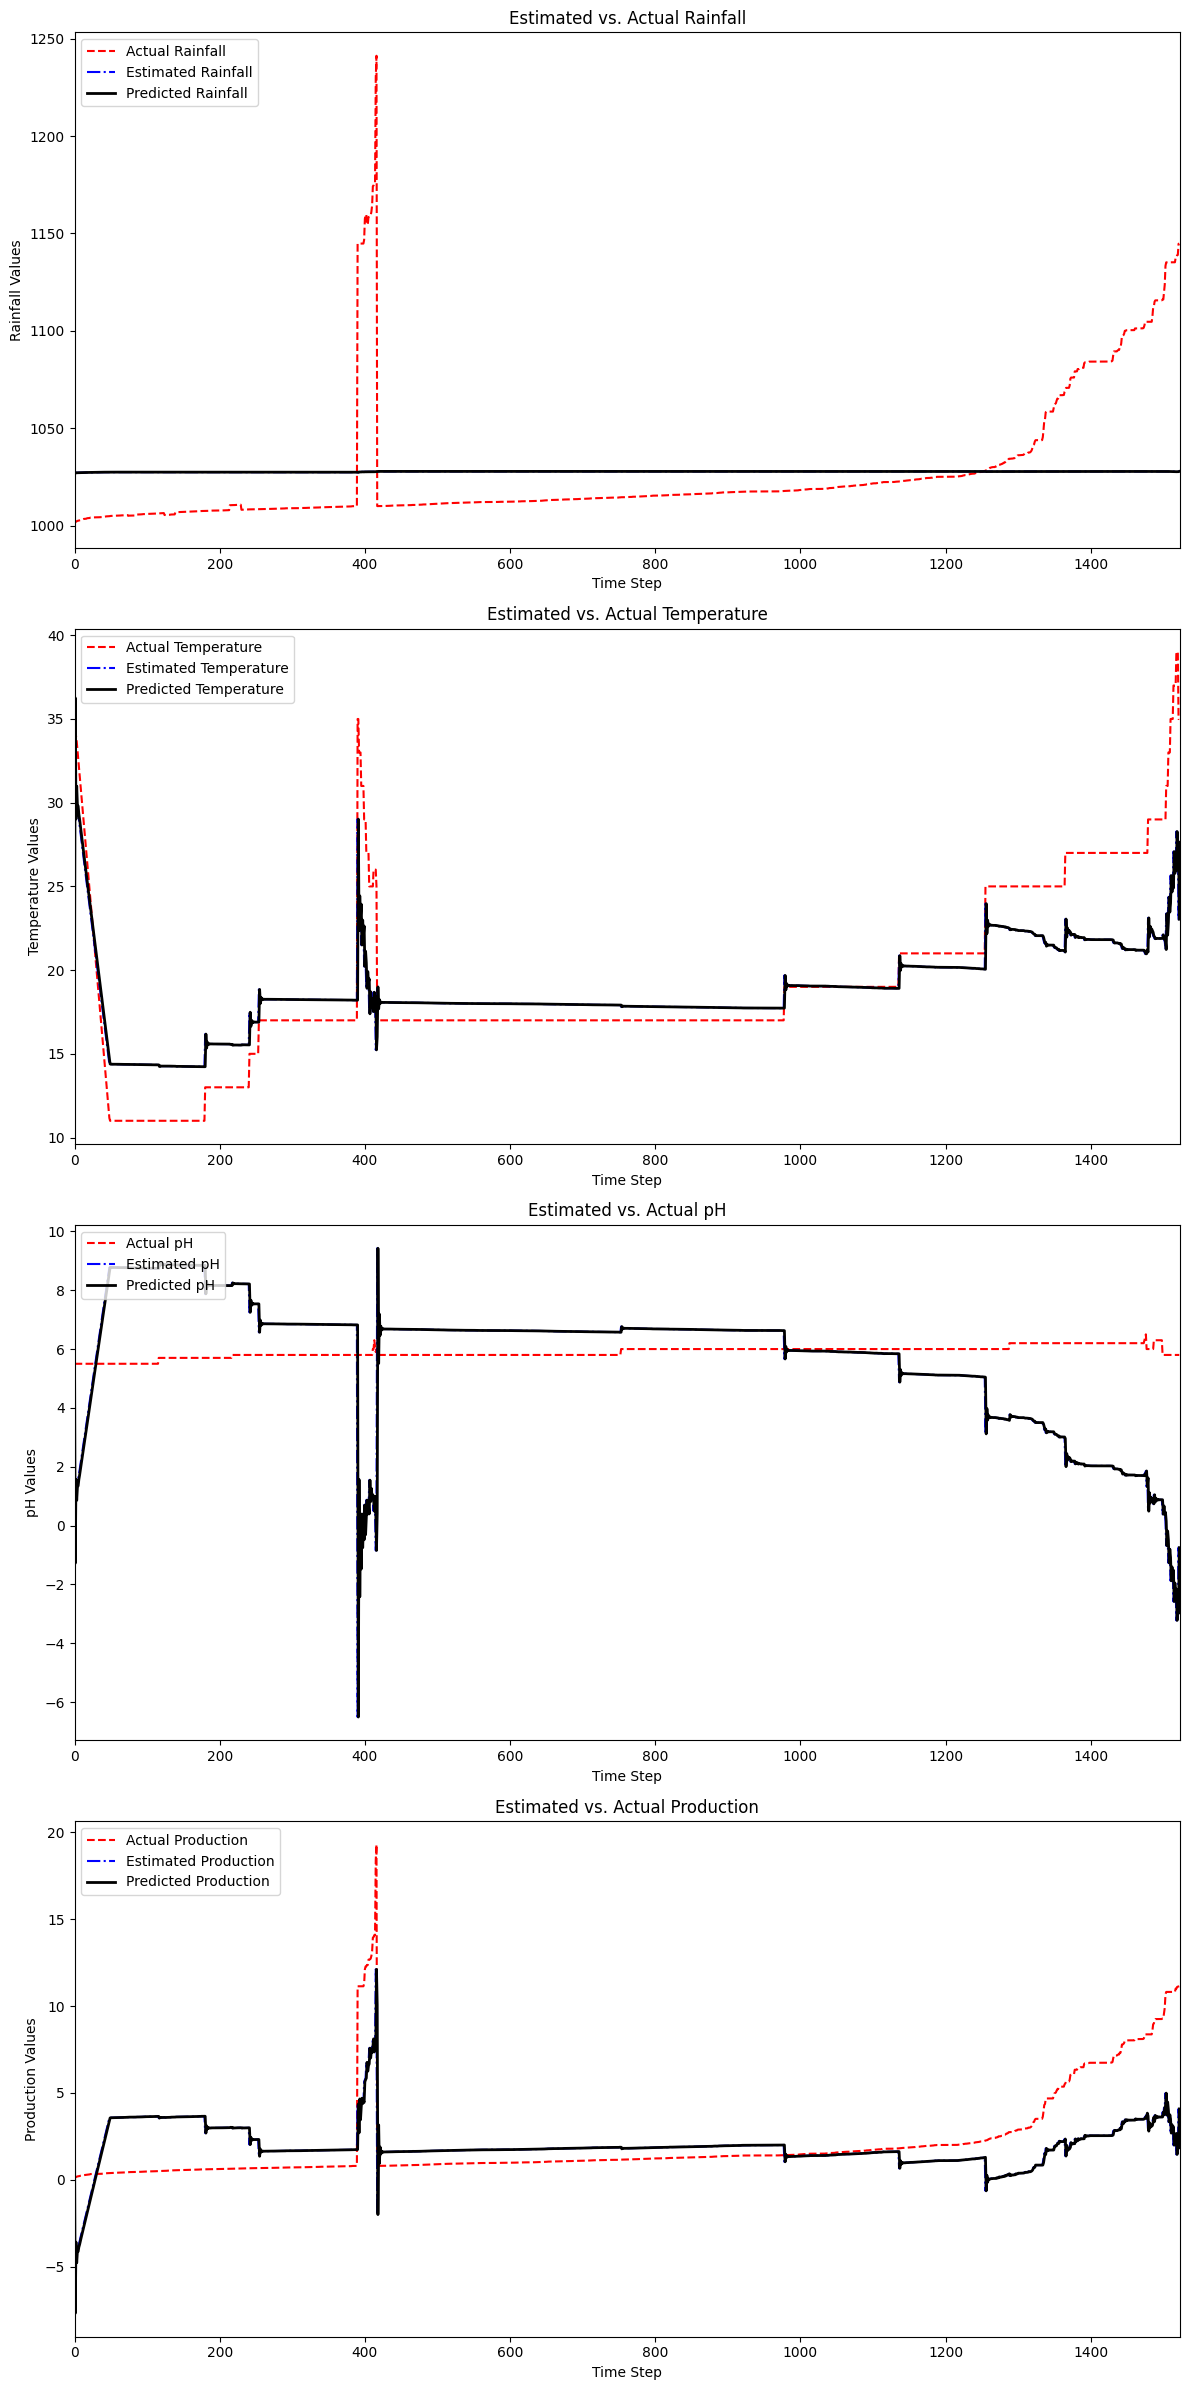

Combined data saved to: /Users/egasarmando/Desktop/combined_data.csv
Memory usage of <class 'pandas.core.frame.DataFrame'>: 48900 bytes
Memory usage of <class 'pandas.core.frame.DataFrame'>: 48900 bytes
Memory usage of <class 'pandas.core.frame.DataFrame'>: 48900 bytes
Memory usage of <class 'pandas.core.frame.DataFrame'>: 97636 bytes
Total memory usage: 244336 bytes


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg
import sys  # Import sys module for memory calculations

# Define the system dynamics (for demonstration, we use a simple identity model)
def process_model(x):
    return x

def measurement_model(x):
    true_measurements = x + np.random.normal(0, 0.1, len(x))
    return true_measurements

file_path = "/Users/egasarmando/Desktop/soil.xlsx"

data = pd.read_excel(file_path)
selected_columns = data.columns

num_states = len(selected_columns)
initial_state = data[selected_columns].mean().values
initial_covariance = np.eye(num_states)
process_noise_covariance = np.diag(np.ones(num_states) * 0.01)
measurement_noise_covariance = np.diag(np.ones(num_states) * 0.1)

alpha = 1e-3
beta = 2.0
kappa = 0.0

num_time_steps = len(data)

predicted_measurements = []
state_estimates = []

for t in range(num_time_steps):
    true_measurement = measurement_model(initial_state)

    num_sigma_points = 2 * num_states + 1
    chol_covariance = scipy.linalg.cholesky((num_states + kappa) * process_noise_covariance, lower=True)
    sigma_points = np.zeros((num_states, num_sigma_points))

    sigma_points[:, 0] = initial_state

    for i in range(num_states):
        sigma_points[:, i + 1] = initial_state + np.sqrt(num_states + kappa) * chol_covariance[:, i]
        sigma_points[:, i + 1 + num_states] = initial_state - np.sqrt(num_states + kappa) * chol_covariance[:, i]

    predicted_state = process_model(sigma_points)

    predicted_state_mean = np.mean(predicted_state, axis=1)
    predicted_state_covariance = np.cov(predicted_state)

    measurement_sigma_points = np.column_stack((predicted_state_mean, predicted_state_mean + np.sqrt(num_states + kappa) * measurement_noise_covariance, predicted_state_mean - np.sqrt(num_states + kappa) * measurement_noise_covariance))
    cross_covariance = np.dot((sigma_points - predicted_state_mean[:, np.newaxis]), (measurement_sigma_points - predicted_state_mean[:, np.newaxis]).T)
    epsilon = 1e-6
    measurement_covariance_reg = np.cov(measurement_sigma_points) + measurement_noise_covariance + epsilon * np.eye(num_states)
    kalman_gain = np.dot(cross_covariance, np.linalg.inv(measurement_covariance_reg))

    innovation = data.iloc[t][selected_columns] - predicted_state_mean
    updated_state = predicted_state_mean + np.dot(kalman_gain, innovation)
    updated_covariance = predicted_state_covariance - np.dot(np.dot(kalman_gain, np.cov(measurement_sigma_points)), kalman_gain.T)

    predicted_measurements.append(predicted_state_mean)
    state_estimates.append(updated_state)

    initial_state = updated_state
    initial_covariance = updated_covariance

predicted_measurement_df = pd.DataFrame(predicted_measurements, columns=selected_columns)
state_estimate_df = pd.DataFrame(state_estimates, columns=selected_columns)

combined_data_df = pd.concat([data[selected_columns], predicted_measurement_df], axis=1)

plt.figure(figsize=(12, 6 * num_states))

for i, col in enumerate(selected_columns):
    plt.subplot(num_states, 1, i + 1)

    plt.plot(data[col], label=f'Actual {col}', linestyle='--', color='red')
    plt.plot(state_estimate_df[col], label=f'Estimated {col}', linestyle='-.', color='blue', zorder=2)
    plt.plot(predicted_measurement_df[col], label=f'Predicted {col}', linewidth=2, color='black', zorder=3)

    plt.legend([f'Actual {col}', f'Estimated {col}', f'Predicted {col}'], loc='upper left')

    plt.title(f'Estimated vs. Actual {col}')
    plt.xlabel('Time Step')
    plt.ylabel(f'{col} Values')

    plt.xlim(0, num_time_steps)
    plt.grid(False)

plt.tight_layout()
plt.show()

combined_data_file = "/Users/egasarmando/Desktop/combined_data.csv"
combined_data_df.to_csv(combined_data_file, index=False)

print(f"Combined data saved to: {combined_data_file}")

# Calculate memory usage of specific objects
objects_to_measure = [data, predicted_measurement_df, state_estimate_df, combined_data_df]

total_memory_usage = 0
for obj in objects_to_measure:
    memory_usage = sys.getsizeof(obj)
    total_memory_usage += memory_usage
    print(f"Memory usage of {type(obj)}: {memory_usage} bytes")

print(f"Total memory usage: {total_memory_usage} bytes")


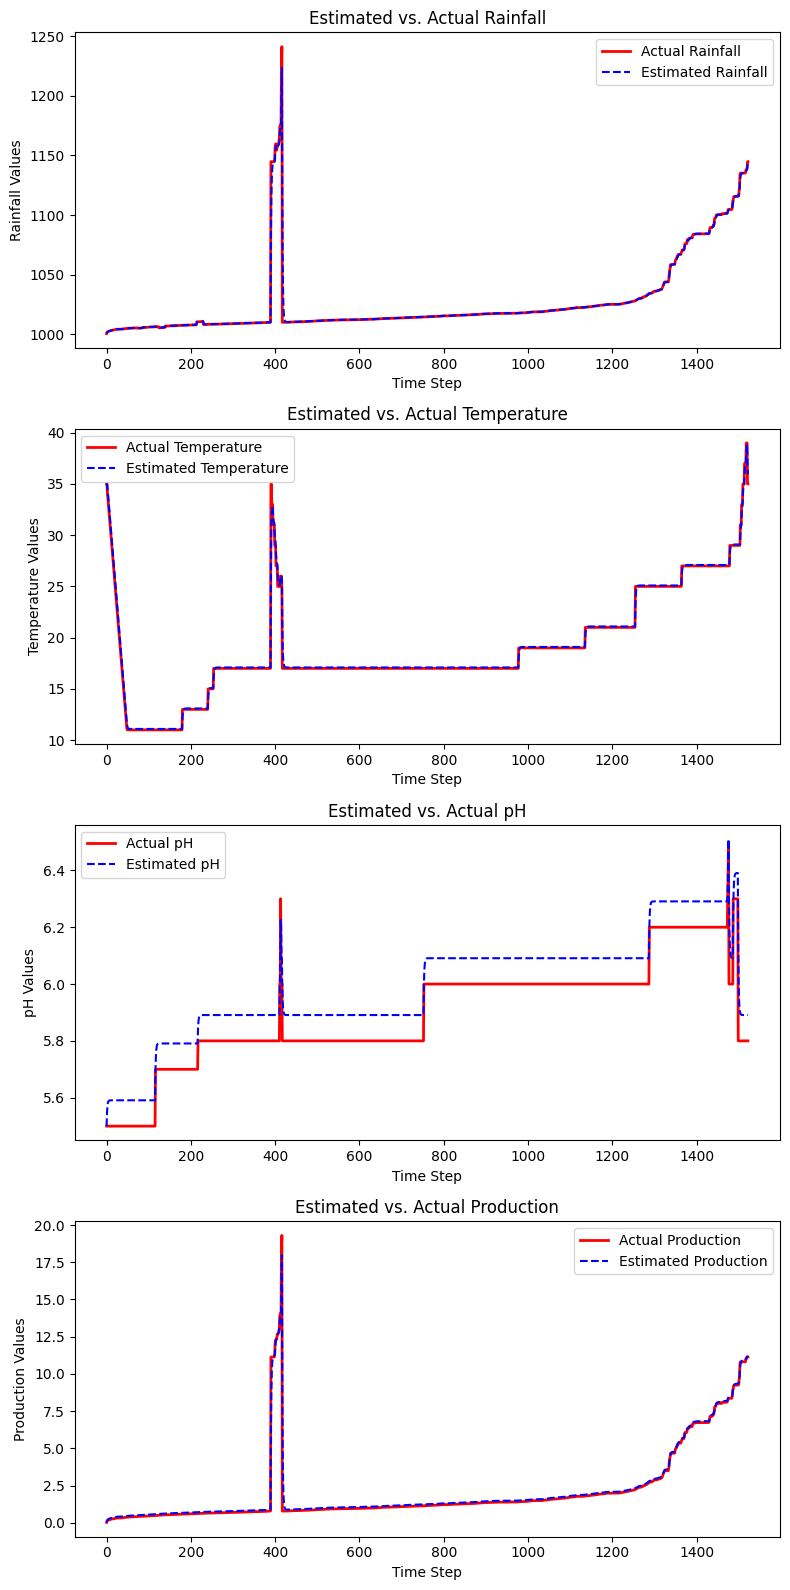

Pearson Correlation for Rainfall: 0.99
Pearson Correlation for Temperature: 1.00
Pearson Correlation for pH: 1.00
Pearson Correlation for Production: 0.99


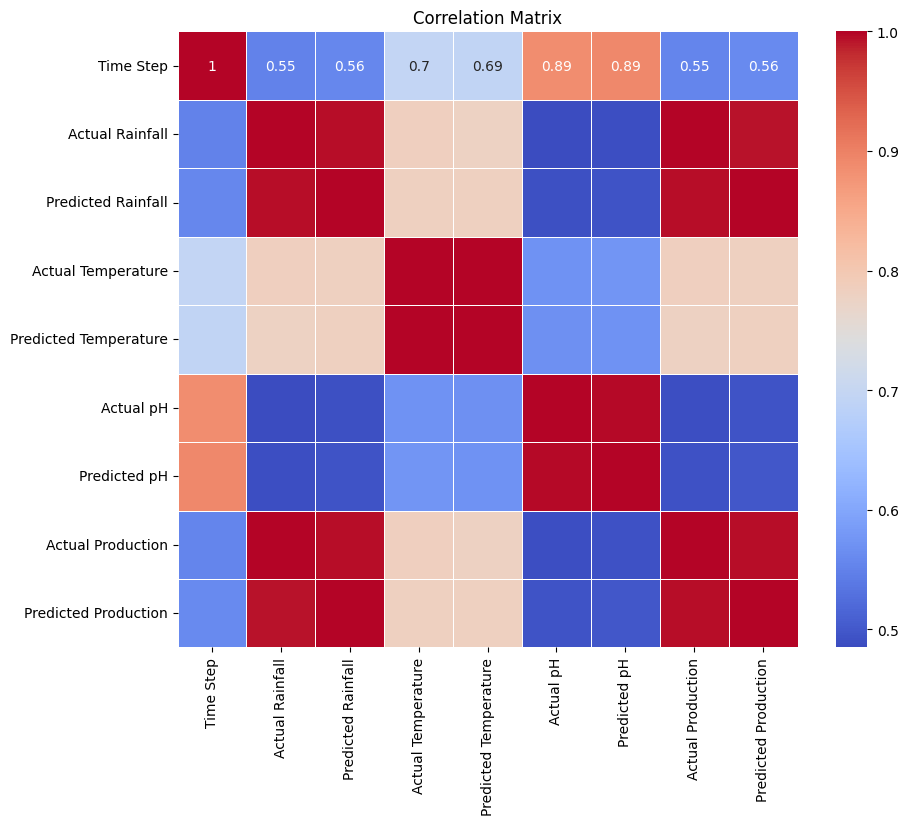

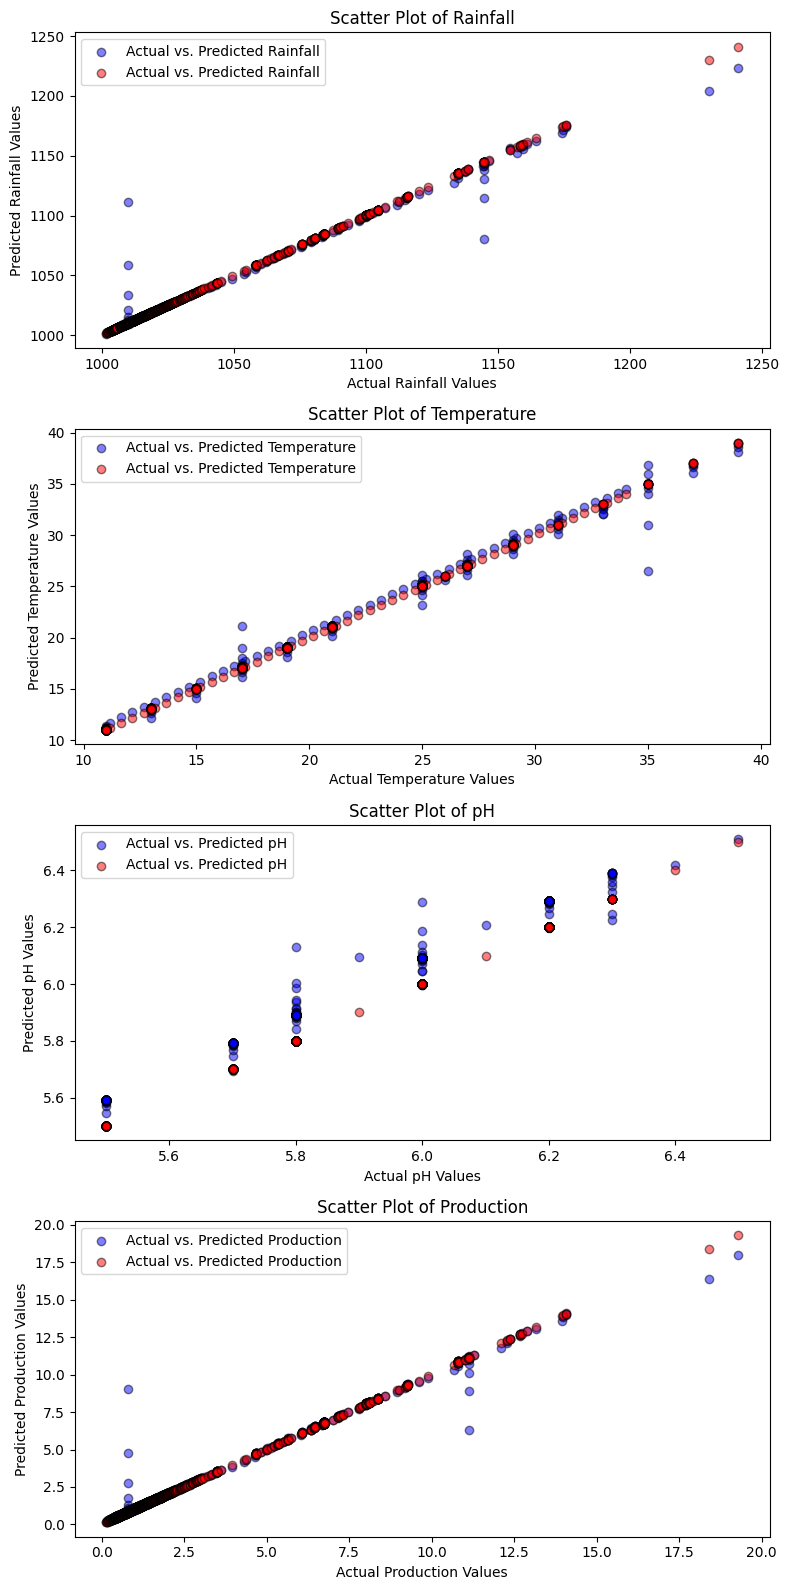

Memory usage of <class 'pandas.core.frame.DataFrame'>: 48900 bytes
Memory usage of <class 'dict'>: 184 bytes
Memory usage of <class 'dict'>: 272 bytes
Memory usage of <class 'pandas.core.frame.DataFrame'>: 109748 bytes
Memory usage of <class 'pandas.core.frame.DataFrame'>: 1632 bytes
Total memory usage: 160736 bytes


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys  # Import sys module for memory calculations
from sklearn.metrics import r2_score  # Importing r2_score for coefficient calculation

# Define the system dynamics (for demonstration, we use a simple moisture diffusion model)
def process_model(state, dt):
    moisture_diffusion_coefficient = 0.1  # Adjust based on your system
    new_state = state + moisture_diffusion_coefficient * dt
    return new_state

def measurement_model(state):
    measurement_noise = np.random.normal(0, 0.1)
    return state + measurement_noise

# Updated file path
file_path = "/Users/egasarmando/Desktop/soil.xlsx"  # Update with your file path
data = pd.read_excel(file_path)  # Read data from the Excel file

# Initialize Kalman filter parameters
initial_state = data.iloc[0]  # Initial state estimate

# Number of time steps
num_time_steps = len(data)

# Initialize lists to store state estimates for each variable
state_estimates = {col: [initial_state[col]] for col in data.columns}

# Initialize Kalman filter parameters for each variable
initial_covariance = {col: 0.1 for col in data.columns}
process_noise = {col: 0.01 for col in data.columns}
measurement_noise = {col: 0.1 for col in data.columns}

# Initialize lists to store actual and predicted data
all_data = {'Time Step': list(range(1, num_time_steps))}  # Assuming time steps start from 1

# Iterate through each variable (column) in the dataset
for col in data.columns:
    all_data[f'Actual {col}'] = data[col].iloc[1:].tolist()  # Assuming time steps start from 1
    all_data[f'Predicted {col}'] = []  # Initialize an empty list for predicted values
    for t in range(1, num_time_steps):
        dt = 1  # Assuming a fixed time step

        # Prediction step for the current variable
        state_estimate = process_model(state_estimates[col][-1], dt)
        covariance_estimate = initial_covariance[col] + process_noise[col]

        # Update step for the current variable
        kalman_gain = covariance_estimate / (covariance_estimate + measurement_noise[col])
        state_estimate += kalman_gain * (data[col].iloc[t] - state_estimate)
        covariance_estimate = (1 - kalman_gain) * covariance_estimate

        # Append the state estimate to the list for the current variable
        state_estimates[col].append(state_estimate)

        # Append the predicted data to the list for the current variable
        all_data[f'Predicted {col}'].append(state_estimate)

# Create a DataFrame from the actual and predicted data
all_data_df = pd.DataFrame(all_data)

# Save the DataFrame to a CSV file on the desktop
desktop_path = "/Users/egasarmando/Desktop/"
csv_file_path = desktop_path + "actual_and_predicted_data.csv"
all_data_df.to_csv(csv_file_path, index=False)

# Create plots to visualize the results for each variable
plt.figure(figsize=(8, 4 * len(data.columns)))
for i, col in enumerate(data.columns):
    plt.subplot(len(data.columns), 1, i + 1)
    
    plt.plot(data[col], label=f'Actual {col}', linewidth=2, color='red')
    plt.plot(state_estimates[col], label=f'Estimated {col}', linestyle='--', color='blue')

    plt.title(f'Estimated vs. Actual {col}')
    plt.xlabel('Time Step')
    plt.ylabel(f'{col} Values')
    plt.legend()

    plt.grid(False)

plt.tight_layout()
plt.show()

# Calculate and print Pearson correlations
for col in data.columns:
    actual_values = all_data_df[f'Actual {col}']
    estimated_values = all_data_df[f'Predicted {col}']
    correlation = actual_values.corr(estimated_values)
    print(f"Pearson Correlation for {col}: {correlation:.2f}")

# Create a correlation matrix plot
correlation_matrix = all_data_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Calculate memory usage of specific objects
objects_to_measure = [data, state_estimates, all_data, all_data_df, correlation_matrix]





# Assuming 'variables' is a list of column names for the variables you want to compare
variables = data.columns.tolist()  # Modify this according to your variable names

plt.figure(figsize=(8, 4 * len(variables)))

for variable in variables:
    actual_col = f'Actual {variable}'
    predicted_col = f'Predicted {variable}'

    r2 = r2_score(all_data_df[actual_col], all_data_df[predicted_col])

    plt.subplot(len(variables), 1, variables.index(variable) + 1)

    plt.scatter(all_data_df[actual_col], all_data_df[predicted_col],
                label=f'Actual vs. Predicted {variable}', c='blue', alpha=0.5, edgecolors='k')  # Blue for predicted
    plt.scatter(all_data_df[actual_col], all_data_df[actual_col],
                label=f'Actual vs. Predicted {variable}', c='red', alpha=0.5, edgecolors='k')  # Red for actual

    plt.title(f'Scatter Plot of {variable}')
    plt.xlabel(f'Actual {variable} Values')
    plt.ylabel(f'Predicted {variable} Values')
    plt.legend(loc='upper left')

plt.tight_layout()
plt.show()




total_memory_usage = 0
for obj in objects_to_measure:
    memory_usage = sys.getsizeof(obj)
    total_memory_usage += memory_usage
    print(f"Memory usage of {type(obj)}: {memory_usage} bytes")

print(f"Total memory usage: {total_memory_usage} bytes")


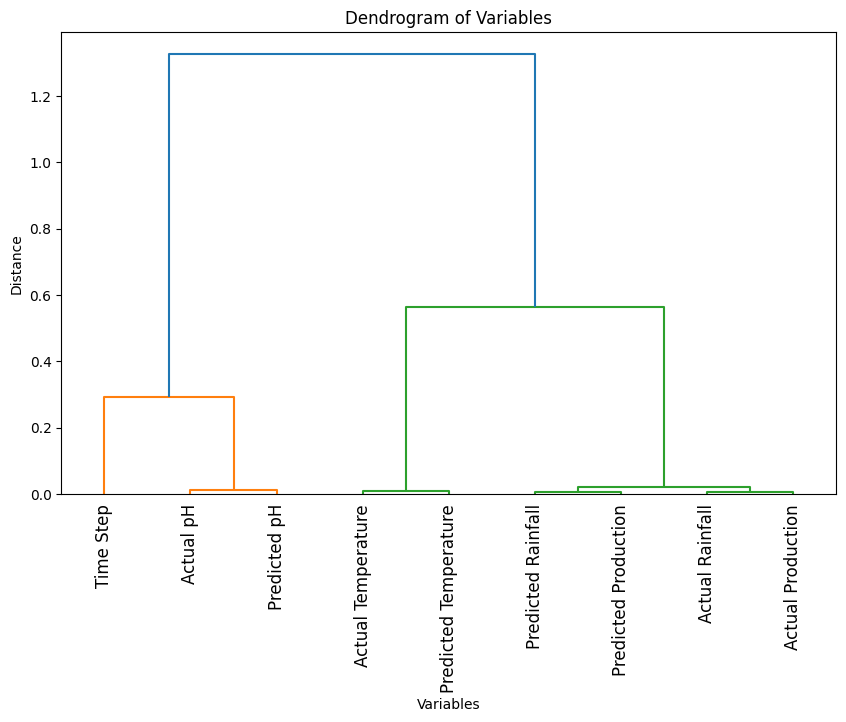

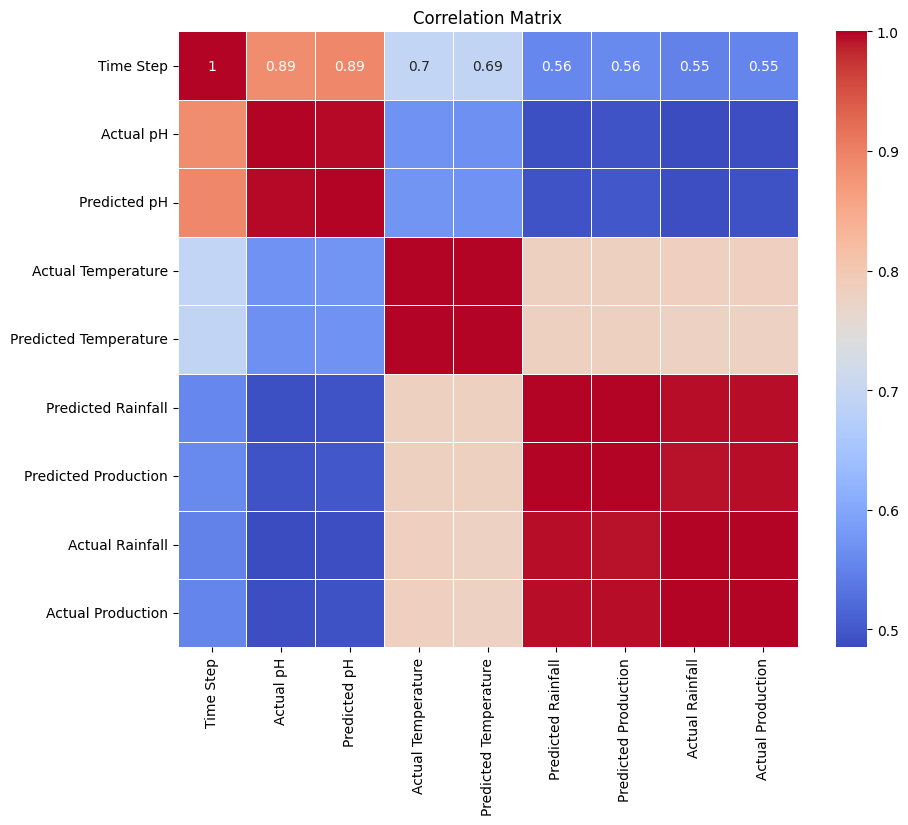

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys  
from sklearn.metrics import r2_score  
from scipy.cluster import hierarchy

# Define the system dynamics (for demonstration, we use a simple moisture diffusion model)
def process_model(state, dt):
    # Your process model implementation here
    pass

def measurement_model(state):
    # Your measurement model implementation here
    pass

# Updated file path
file_path = "/Users/egasarmando/Desktop/soil.xlsx"  # Update with your file path
data = pd.read_excel(file_path)  # Read data from the Excel file

# Initialize Kalman filter parameters
# Your initialization code here

# Your Kalman filter implementation here

# Create a DataFrame from the actual and predicted data
# Your DataFrame creation code here

# Save the DataFrame to a CSV file on the desktop
# Your CSV saving code here

# Create plots to visualize the results for each variable
# Your visualization code here

# Calculate and print Pearson correlations
# Your correlation calculation code here

# Calculate memory usage of specific objects
# Your memory usage calculation code here

# Calculate correlation matrix
correlation_matrix = all_data_df.corr()

# Calculate distances using 1 - absolute(correlation) to convert correlation to distances
distance_matrix = hierarchy.distance.pdist(1 - np.abs(correlation_matrix.values))
linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=correlation_matrix.columns, leaf_rotation=90)
plt.title('Dendrogram of Variables')
plt.xlabel('Variables')
plt.ylabel('Distance')

# Reorder the correlation matrix based on the dendrogram's leaf order
ordered_correlation_matrix = correlation_matrix.iloc[dendrogram['leaves'], dendrogram['leaves']]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(ordered_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


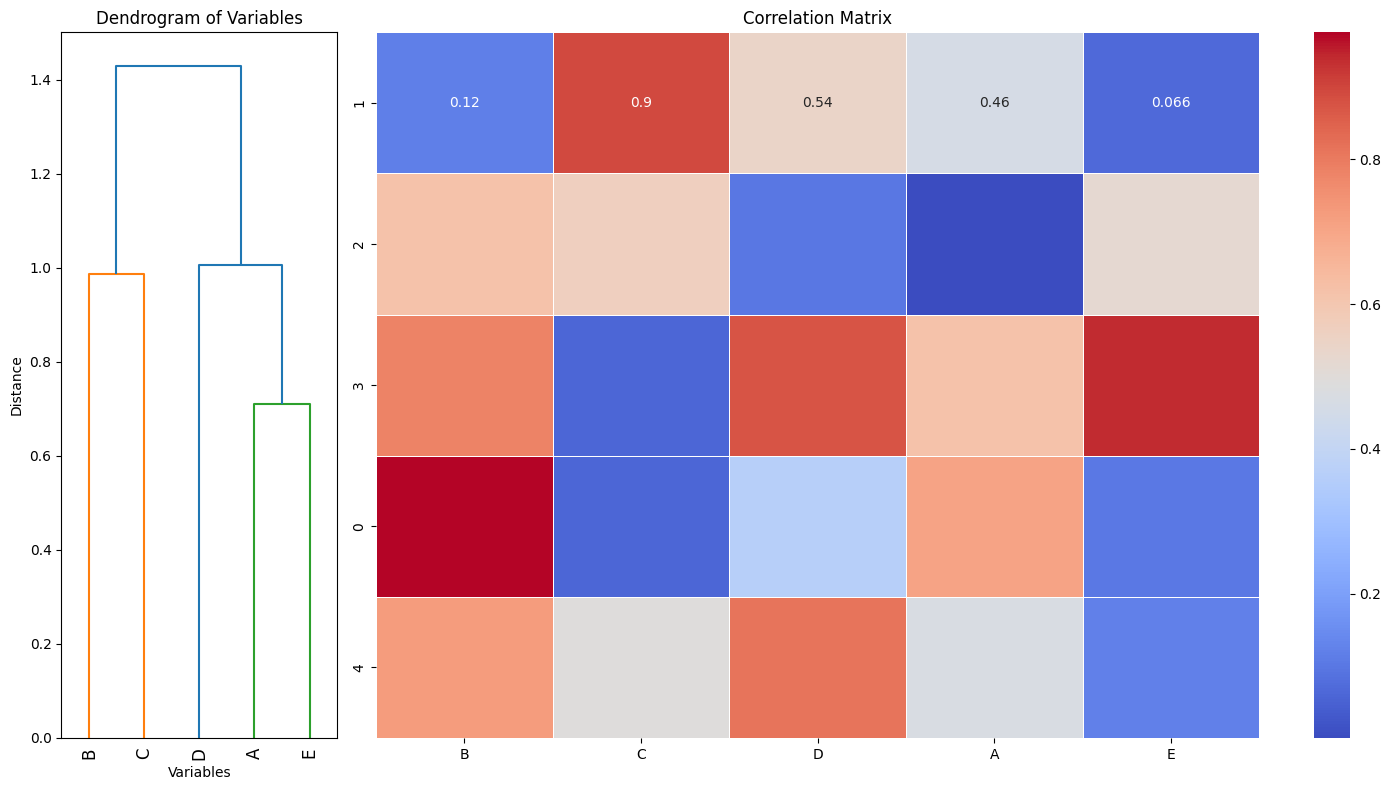

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy

# Load or generate your correlation matrix
correlation_matrix = pd.DataFrame(np.random.rand(5, 5), columns=['A', 'B', 'C', 'D', 'E'])

# Calculate distances using 1 - absolute(correlation) to convert correlation to distances
distance_matrix = hierarchy.distance.pdist(1 - np.abs(correlation_matrix.values))
linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')

# Reorder the correlation matrix based on the dendrogram's leaf order
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=correlation_matrix.columns, leaf_rotation=90, no_plot=True)
ordered_correlation_matrix = correlation_matrix.iloc[dendrogram['leaves'], dendrogram['leaves']]

# Create a grid layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [1, 4]})

# Plot dendrogram
hierarchy.dendrogram(linkage_matrix, labels=correlation_matrix.columns, leaf_rotation=90, ax=ax1)
ax1.set_title('Dendrogram of Variables')
ax1.set_xlabel('Variables')
ax1.set_ylabel('Distance')

# Plot heatmap
sns.heatmap(ordered_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax2)
ax2.set_title("Correlation Matrix")

plt.tight_layout()
plt.show()


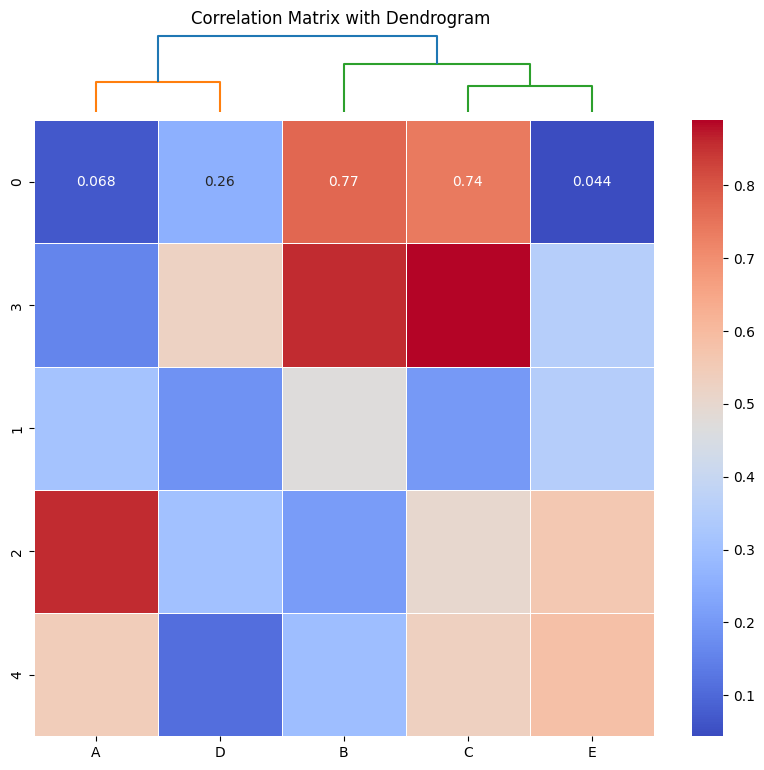

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy

# Load or generate your correlation matrix
correlation_matrix = pd.DataFrame(np.random.rand(5, 5), columns=['A', 'B', 'C', 'D', 'E'])

# Calculate distances using 1 - absolute(correlation) to convert correlation to distances
distance_matrix = hierarchy.distance.pdist(1 - np.abs(correlation_matrix.values))
linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')

# Reorder the correlation matrix based on the dendrogram's leaf order
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=correlation_matrix.columns, leaf_rotation=90, no_plot=True)
ordered_correlation_matrix = correlation_matrix.iloc[dendrogram['leaves'], dendrogram['leaves']]

# Create heatmap
plt.figure(figsize=(10, 8))

# Plot heatmap
sns.heatmap(ordered_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Overlay dendrogram on top of the heatmap
ax = plt.gca()
pos = ax.get_position()  # Get the position of the heatmap
new_pos = [pos.x0, pos.y0 + pos.height + 0.01, pos.width, 0.1]  # Define position for dendrogram

# Create a new set of axes for the dendrogram
ax_dendro = plt.axes(new_pos)
hierarchy.dendrogram(linkage_matrix, labels=correlation_matrix.columns, leaf_rotation=90, ax=ax_dendro)
ax_dendro.axis('off')  # Turn off the axis for the dendrogram

plt.title("Correlation Matrix with Dendrogram ")
plt.show()


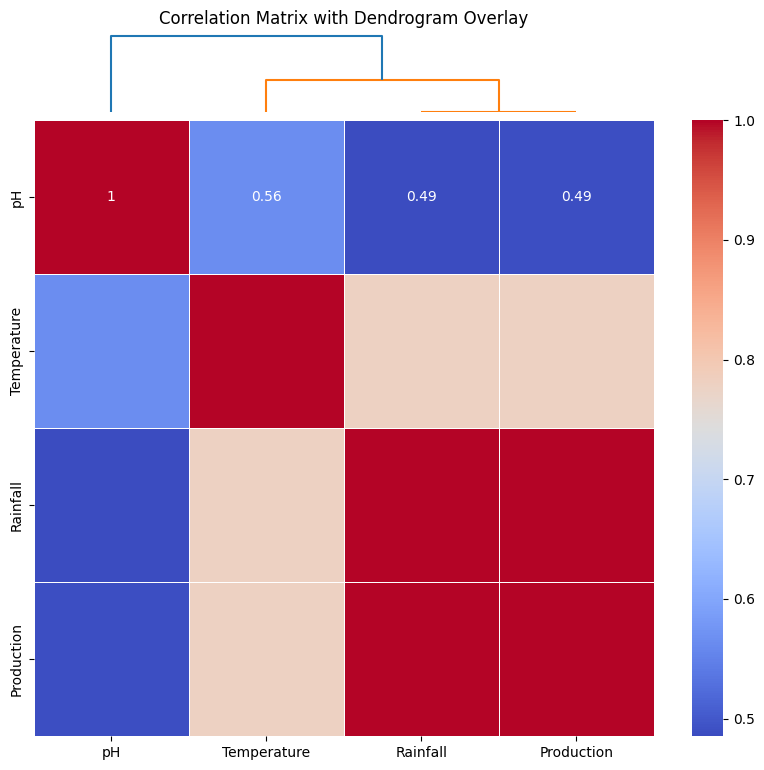

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy

# Load data from Excel file
file_path = "/Users/egasarmando/Desktop/soil.xlsx"  # Update with your file path
data = pd.read_excel(file_path)  # Read data from the Excel file

# Calculate correlation matrix
correlation_matrix = data.corr()

# Calculate distances using 1 - absolute(correlation) to convert correlation to distances
distance_matrix = hierarchy.distance.pdist(1 - np.abs(correlation_matrix.values))
linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')

# Reorder the correlation matrix based on the dendrogram's leaf order
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=correlation_matrix.columns, leaf_rotation=90, no_plot=True)
ordered_correlation_matrix = correlation_matrix.iloc[dendrogram['leaves'], dendrogram['leaves']]

# Create heatmap
plt.figure(figsize=(10, 8))

# Plot heatmap
sns.heatmap(ordered_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Overlay dendrogram on top of the heatmap
ax = plt.gca()
pos = ax.get_position()  # Get the position of the heatmap
new_pos = [pos.x0, pos.y0 + pos.height + 0.01, pos.width, 0.1]  # Define position for dendrogram

# Create a new set of axes for the dendrogram
ax_dendro = plt.axes(new_pos)
hierarchy.dendrogram(linkage_matrix, labels=correlation_matrix.columns, leaf_rotation=90, ax=ax_dendro)
ax_dendro.axis('off')  # Turn off the axis for the dendrogram

plt.title("Correlation Matrix with Dendrogram Overlay")
plt.show()


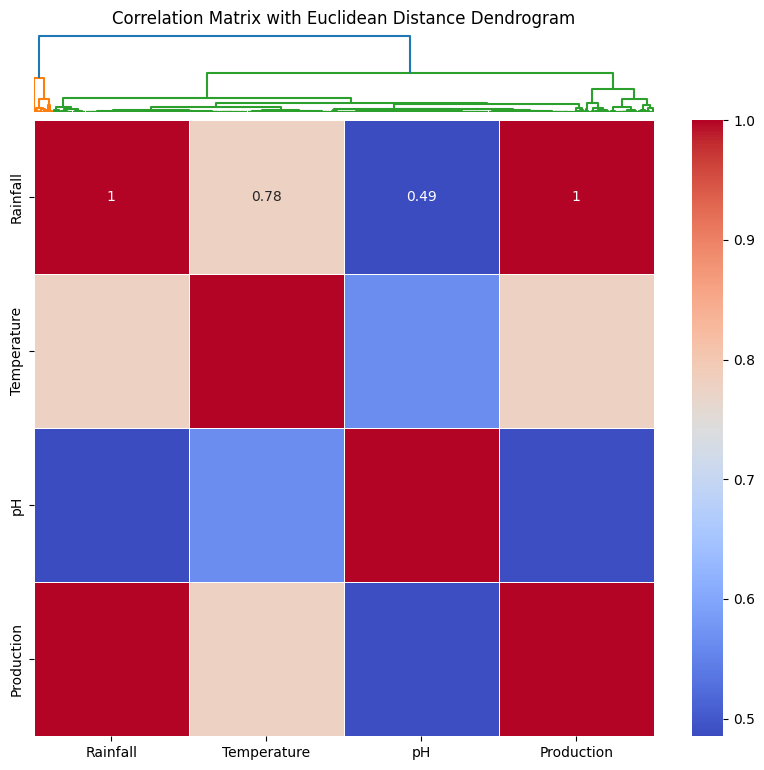

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy

# Load data from Excel file
file_path = "/Users/egasarmando/Desktop/soil.xlsx"  # Update with your file path
data = pd.read_excel(file_path)  # Read data from the Excel file

# Calculate Euclidean distance matrix
euclidean_distance_matrix = pdist(data.values, metric='euclidean')

# Generate linkage matrix for the dendrogram using the Euclidean distance
linkage_matrix = hierarchy.linkage(euclidean_distance_matrix, method='complete')

# Reorder the data based on the dendrogram's leaf order
dendrogram = hierarchy.dendrogram(linkage_matrix, no_plot=True)
ordered_data = data.iloc[dendrogram['leaves']]

# Calculate correlation matrix for heatmap (optional, for comparison)
correlation_matrix = ordered_data.corr()

# Create heatmap
plt.figure(figsize=(10, 8))

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Overlay Euclidean distance dendrogram on top of the heatmap
ax = plt.gca()
pos = ax.get_position()  # Get the position of the heatmap
new_pos = [pos.x0, pos.y0 + pos.height + 0.01, pos.width, 0.1]  # Define position for dendrogram

# Create a new set of axes for the dendrogram
ax_dendro = plt.axes(new_pos)
hierarchy.dendrogram(linkage_matrix, ax=ax_dendro)
ax_dendro.axis('off')  # Turn off the axis for the dendrogram

plt.title("Correlation Matrix with Euclidean Distance Dendrogram")
plt.show()


/Users/egasarmando/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


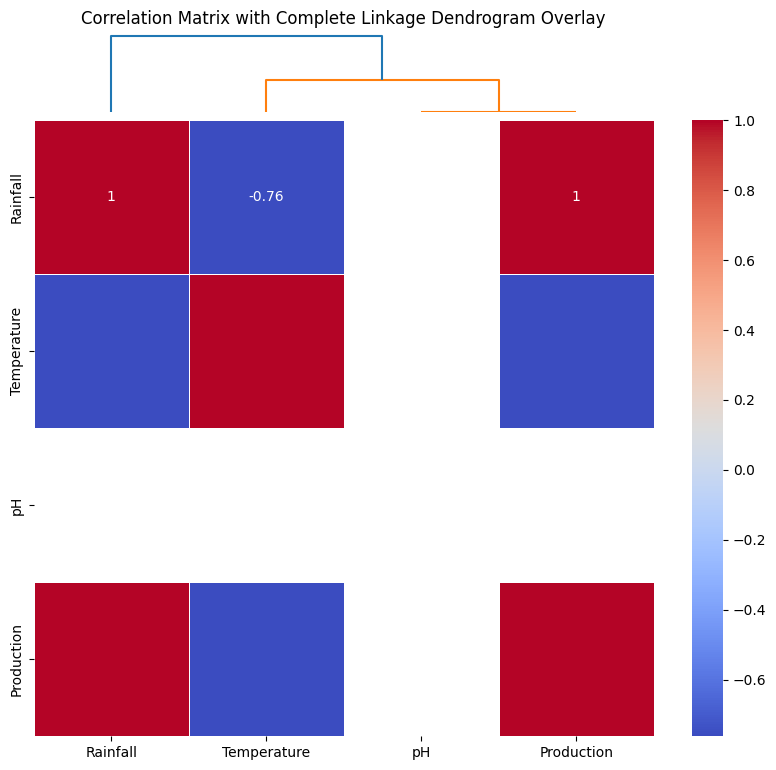

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy

# Load data from Excel file
file_path = "/Users/egasarmando/Desktop/soil.xlsx"  # Update with your file path
data = pd.read_excel(file_path)  # Read data from the Excel file

# Calculate the similarity matrix (using 1 - correlation as similarity)
similarity_matrix = 1 - data.corr()

# Generate the complete linkage matrix for the dendrogram
linkage_matrix = hierarchy.linkage(pdist(similarity_matrix), method='complete')

# Reorder the data based on the dendrogram's leaf order
dendrogram = hierarchy.dendrogram(linkage_matrix, no_plot=True)
ordered_data = data.iloc[dendrogram['leaves']]

# Calculate correlation matrix for heatmap
correlation_matrix = ordered_data.corr()

# Create heatmap
plt.figure(figsize=(10, 8))

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Overlay the dendrogram on top of the heatmap
ax = plt.gca()
pos = ax.get_position()  # Get the position of the heatmap
new_pos = [pos.x0, pos.y0 + pos.height + 0.01, pos.width, 0.1]  # Define position for dendrogram

# Create a new set of axes for the dendrogram
ax_dendro = plt.axes(new_pos)
hierarchy.dendrogram(linkage_matrix, ax=ax_dendro)
ax_dendro.axis('off')  # Turn off the axis for the dendrogram

plt.title("Correlation Matrix with Complete Linkage Dendrogram Overlay")
plt.show()


/Users/egasarmando/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


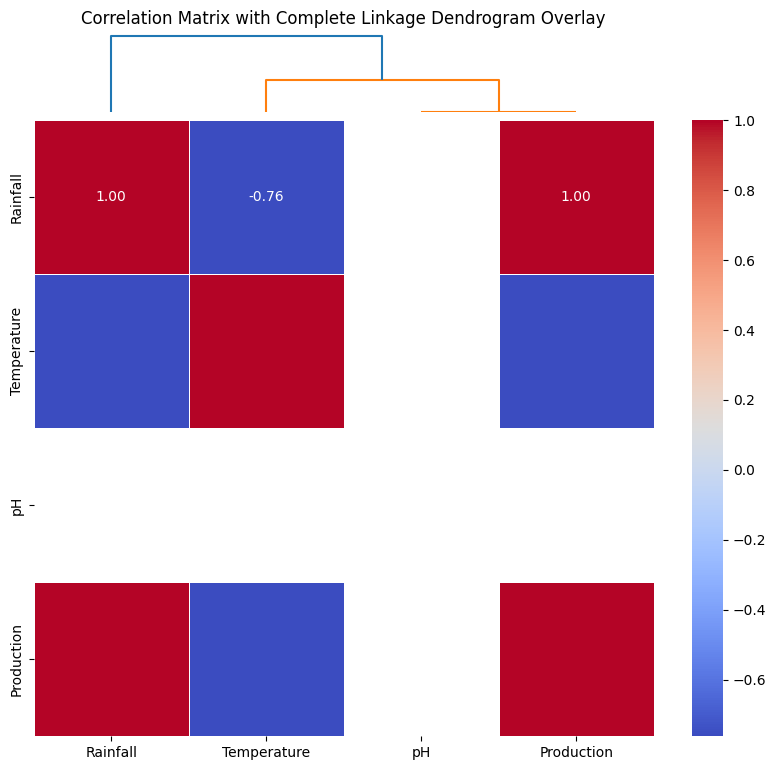

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy

# Load data from Excel file
file_path = "/Users/egasarmando/Desktop/soil.xlsx"  # Update with your file path
data = pd.read_excel(file_path)  # Read data from the Excel file

# Calculate the similarity matrix (using 1 - correlation as similarity)
similarity_matrix = 1 - data.corr()

# Generate the complete linkage matrix for the dendrogram
linkage_matrix = hierarchy.linkage(pdist(similarity_matrix), method='complete')

# Reorder the data based on the dendrogram's leaf order
dendrogram = hierarchy.dendrogram(linkage_matrix, no_plot=True)
ordered_data = data.iloc[dendrogram['leaves']]

# Calculate correlation matrix for heatmap
correlation_matrix = ordered_data.corr()

# Create heatmap
plt.figure(figsize=(10, 8))

# Plot heatmap without using format strings directly in annotations
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

# Overlay the dendrogram on top of the heatmap
ax = plt.gca()
pos = ax.get_position()  # Get the position of the heatmap
new_pos = [pos.x0, pos.y0 + pos.height + 0.01, pos.width, 0.1]  # Define position for dendrogram

# Create a new set of axes for the dendrogram
ax_dendro = plt.axes(new_pos)
hierarchy.dendrogram(linkage_matrix, ax=ax_dendro)
ax_dendro.axis('off')  # Turn off the axis for the dendrogram

plt.title("Correlation Matrix with Complete Linkage Dendrogram Overlay")
plt.show()


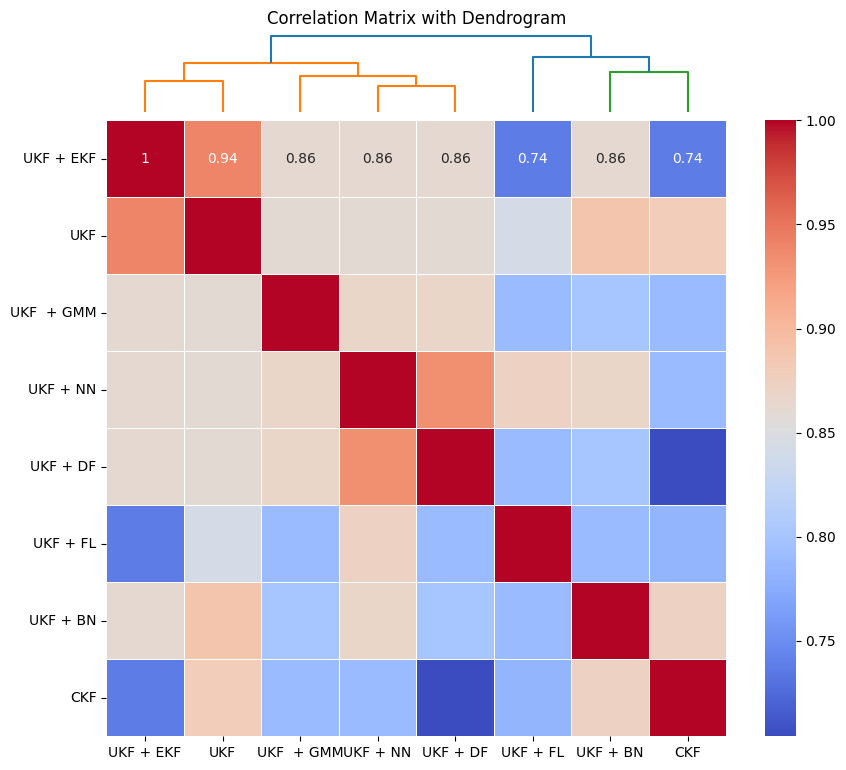

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy

# Load data from Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/cluster.xlsx"  # Update with your file path
data = pd.read_excel(file_path)  # Read data from the Excel file

# Calculate correlation matrix
correlation_matrix = data.corr()

# Calculate distances using 1 - absolute(correlation) to convert correlation to distances
distance_matrix = hierarchy.distance.pdist(1 - np.abs(correlation_matrix.values))
linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')

# Reorder the correlation matrix based on the dendrogram's leaf order
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=correlation_matrix.columns, leaf_rotation=90, no_plot=True)
ordered_correlation_matrix = correlation_matrix.iloc[dendrogram['leaves'], dendrogram['leaves']]

# Create heatmap
plt.figure(figsize=(10, 8))

# Plot heatmap
sns.heatmap(ordered_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Overlay dendrogram on top of the heatmap
ax = plt.gca()
pos = ax.get_position()  # Get the position of the heatmap
new_pos = [pos.x0, pos.y0 + pos.height + 0.01, pos.width, 0.1]  # Define position for dendrogram

# Create a new set of axes for the dendrogram
ax_dendro = plt.axes(new_pos)
hierarchy.dendrogram(linkage_matrix, labels=correlation_matrix.columns, leaf_rotation=90, ax=ax_dendro)
ax_dendro.axis('off')  # Turn off the axis for the dendrogram

plt.title("Correlation Matrix with Dendrogram")
plt.show()


All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


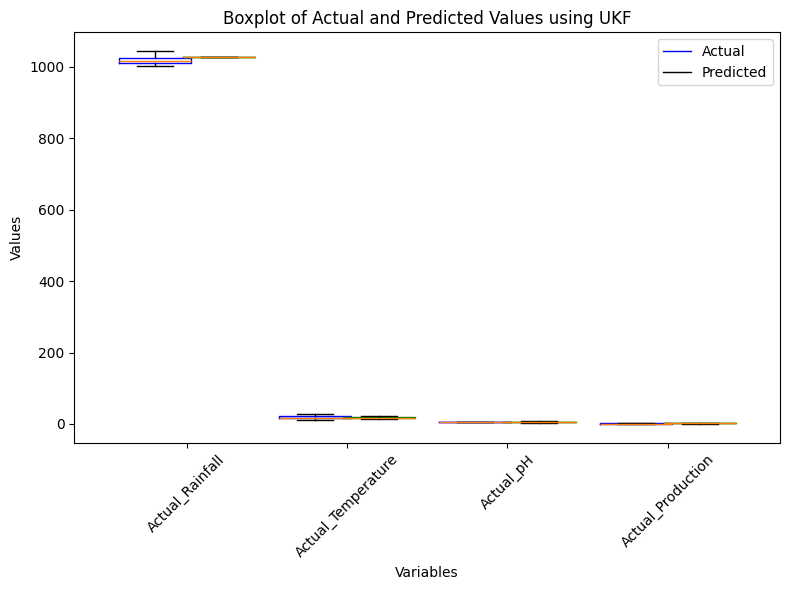

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/combinedSukf.xlsx"
data = pd.read_excel(file_path)

# Extract all column names
all_columns = data.columns

# List of variable names with the prefix "Actual_"
variable_names = [col for col in all_columns if col.startswith("Actual_")]

# Print column names for debugging
print("All Columns:", all_columns)

# Create boxplots for the actual and predicted values of all variables
plt.figure(figsize=(8, 6))

# Check if 'Predicted_' columns exist before trying to access them
data_to_plot_predicted = []
for col in variable_names:
    predicted_col_name = col.replace("Actual_", "Predicted_")
    if predicted_col_name in all_columns:
        data_to_plot_predicted.append(data[predicted_col_name])
    else:
        print(f"Column '{predicted_col_name}' not found.")

# Define box properties for actual and predicted
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')
boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual and predicted values
plt.boxplot(data_to_plot_actual, showfliers=False, positions=[pos - width/2 for pos in positions], boxprops=boxprops_actual)
plt.boxplot(data_to_plot_predicted, showfliers=False, positions=[pos + width/2 for pos in positions], boxprops=boxprops_predicted)

plt.xticks(positions, variable_names, rotation=45)
plt.title("Boxplot of Actual and Predicted Values using UKF")
plt.xlabel("Variables")
plt.ylabel("Values")

# Create a single legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/combinedSukf.xlsx"
data = pd.read_excel(file_path)

# Extract all column names
all_columns = data.columns

# List of variable names with the prefix "Actual_"
variable_names = [col for col in all_columns if col.startswith("Actual_")]

# Print column names for debugging
print("All Columns:", all_columns)

# Create boxplots for the actual and predicted values of all variables
plt.figure(figsize=(8, 6))

# Check if 'Predicted_' columns exist before trying to access them
data_to_plot_combined = []

for col in variable_names:
    actual_col_name = col
    predicted_col_name = col.replace("Actual_", "Predicted_")
    
    if predicted_col_name in all_columns:
        data_to_plot_combined.append(data[actual_col_name])
        data_to_plot_combined.append(data[predicted_col_name])

        # Calculate mean values
        mean_actual = data[actual_col_name].mean()
        mean_predicted = data[predicted_col_name].mean()

        # Add text for mean values on top of each box
        plt.text(variable_names.index(col) * 2 + 1, mean_actual, f"{mean_actual:.2f}", ha='center', va='bottom', color='blue')
        plt.text(variable_names.index(col) * 2 + 2, mean_predicted, f"{mean_predicted:.2f}", ha='center', va='bottom', color='green')

    else:
        print(f"Column '{predicted_col_name}' not found.")

# Define box properties for actual and predicted
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')
boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')

# Calculate the positions for the boxplots
positions = range(1, 2 * len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual and predicted values
plt.boxplot(data_to_plot_combined, showfliers=False, positions=positions, boxprops=[boxprops_actual, boxprops_predicted])

# Adjust x-axis labels
plt.xticks(positions, variable_names * 2, rotation=45)

plt.title("Boxplot of Actual and Predicted Values using UKF")
plt.xlabel("Variables")
plt.ylabel("Values")

# Create a single legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


AttributeError: 'list' object has no attribute 'items'

ValueError: Image size of 5027x474837 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x600 with 1 Axes>

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/combinedSukf.xlsx"
data = pd.read_excel(file_path)

# Extract all column names
all_columns = data.columns

# List of variable names with the prefix "Actual_"
variable_names = [col for col in all_columns if col.startswith("Actual_")]

# Print column names for debugging
print("All Columns:", all_columns)

# Create boxplots for the actual and predicted values of all variables
plt.figure(figsize=(8, 6))

# Check if 'Predicted_' columns exist before trying to access them
data_to_plot_combined = []

for col in variable_names:
    actual_col_name = col
    predicted_col_name = col.replace("Actual_", "Predicted_")
    
    if predicted_col_name in all_columns:
        data_to_plot_combined.append(data[actual_col_name])
        data_to_plot_combined.append(data[predicted_col_name])

        # Calculate mean values
        mean_actual = data[actual_col_name].mean()
        mean_predicted = data[predicted_col_name].mean()

        # Add text for mean values on top of each box
        plt.text(variable_names.index(col) * 2 + 1, mean_actual, f"{mean_actual:.2f}", ha='center', va='bottom', color='blue')
        plt.text(variable_names.index(col) * 2 + 2, mean_predicted, f"{mean_predicted:.2f}", ha='center', va='bottom', color='green')

    else:
        print(f"Column '{predicted_col_name}' not found.")

# Define box properties for actual and predicted
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')
boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')

# Calculate the positions for the boxplots
positions = range(1, 2 * len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual and predicted values
plt.boxplot(data_to_plot_combined, showfliers=False, positions=positions, boxprops=[boxprops_actual, boxprops_predicted])

# Adjust x-axis labels
plt.xticks(positions, variable_names * 2, rotation=45)

plt.title("Boxplot of Actual and Predicted Values using UKF")
plt.xlabel("Variables")
plt.ylabel("Values")

# Create a single legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


AttributeError: 'list' object has no attribute 'items'

ValueError: Image size of 5027x474837 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x600 with 1 Axes>

All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


AttributeError: 'list' object has no attribute 'mean'

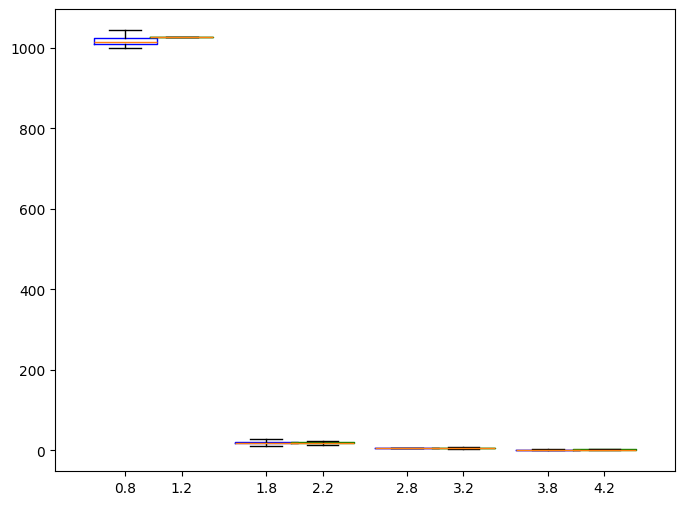

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/combinedSukf.xlsx"
data = pd.read_excel(file_path)

# Extract all column names
all_columns = data.columns

# List of variable names with the prefix "Actual_"
variable_names = [col for col in all_columns if col.startswith("Actual_")]

# Print column names for debugging
print("All Columns:", all_columns)

# Create boxplots for the actual and predicted values of all variables
plt.figure(figsize=(8, 6))

# Check if 'Predicted_' columns exist before trying to access them
data_to_plot_actual = []  # Corrected variable name
data_to_plot_predicted = []

for col in variable_names:
    actual_col_name = col  # No need to replace the prefix for actual values
    predicted_col_name = col.replace("Actual_", "Predicted_")
    
    if actual_col_name in all_columns:
        data_to_plot_actual.append(data[actual_col_name])  # Append actual data
    else:
        print(f"Column '{actual_col_name}' not found.")
    
    if predicted_col_name in all_columns:
        data_to_plot_predicted.append(data[predicted_col_name])
    else:
        print(f"Column '{predicted_col_name}' not found.")

# Define box properties for actual and predicted
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')
boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual and predicted values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=[pos - width/2 for pos in positions], boxprops=boxprops_actual)
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=[pos + width/2 for pos in positions], boxprops=boxprops_predicted)

# Display mean markers for actual values
mean_marker_actual = plt.scatter(positions, data_to_plot_actual.mean(axis=0), marker='o', color='red', label='Mean (Actual)')

# Display mean markers for predicted values
mean_marker_predicted = plt.scatter([pos + width/2 for pos in positions], data_to_plot_predicted.mean(axis=0), marker='o', color='purple', label='Mean (Predicted)')

plt.xticks(positions, variable_names, rotation=45)
plt.title("Boxplot of Actual and Predicted Values using UKF")
plt.xlabel("Variables")
plt.ylabel("Values")

# Create a single legend for "Actual," "Predicted," and mean markers
plt.legend(handles=[box_actual["boxes"][0], box_predicted["boxes"][0], mean_marker_actual, mean_marker_predicted], labels=['Actual', 'Predicted', 'Mean (Actual)', 'Mean (Predicted)'], loc='upper right')

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


AttributeError: 'list' object has no attribute 'mean'

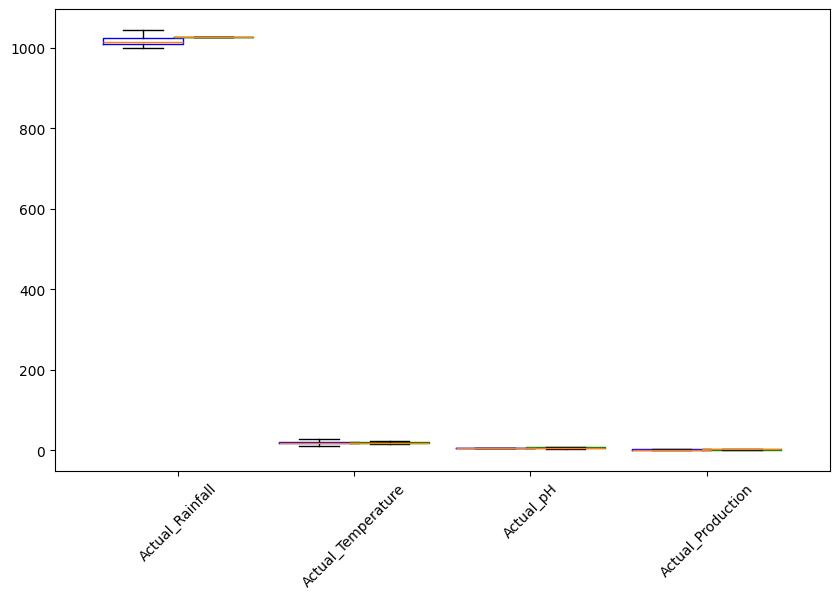

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/combinedSukf.xlsx"
data = pd.read_excel(file_path)

# Extract all column names
all_columns = data.columns

# List of variable names with the prefix "Actual_"
variable_names = [col for col in all_columns if col.startswith("Actual_")]

# Print column names for debugging
print("All Columns:", all_columns)

# Create boxplots for the actual and predicted values of all variables
plt.figure(figsize=(10, 6))

# Check if 'Predicted_' columns exist before trying to access them
data_to_plot_actual = []  # Corrected variable name
data_to_plot_predicted = []

for col in variable_names:
    actual_col_name = col  # No need to replace the prefix for actual values
    predicted_col_name = col.replace("Actual_", "Predicted_")
    
    if actual_col_name in all_columns:
        data_to_plot_actual.append(data[actual_col_name])  # Append actual data
    else:
        print(f"Column '{actual_col_name}' not found.")
    
    if predicted_col_name in all_columns:
        data_to_plot_predicted.append(data[predicted_col_name])
    else:
        print(f"Column '{predicted_col_name}' not found.")

# Define box properties for actual and predicted
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')
boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual and predicted values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=[pos - width/2 for pos in positions], boxprops=boxprops_actual)
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=[pos + width/2 for pos in positions], boxprops=boxprops_predicted)

# Display variable names on the x-axis
plt.xticks(positions, variable_names, rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = data_to_plot_actual.mean(axis=0)
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos - width/2, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='red')

# Display mean values for predicted values on top of each boxplot
mean_values_predicted = data_to_plot_predicted.mean(axis=0)
for pos, mean_val in zip([pos + width/2 for pos in positions], mean_values_predicted):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='purple')

plt.title("Boxplot of Actual and Predicted Values using UKF")
plt.xlabel("Variables")
plt.ylabel("Values")

# Create a single legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


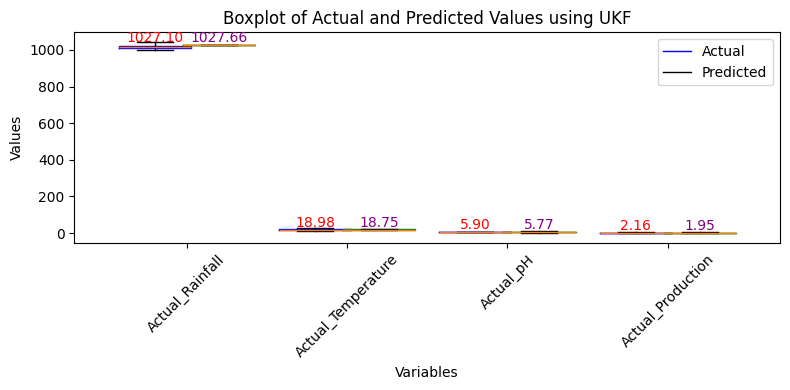

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/combinedSukf.xlsx"
data = pd.read_excel(file_path)

# Extract all column names
all_columns = data.columns

# List of variable names with the prefix "Actual_"
variable_names = [col for col in all_columns if col.startswith("Actual_")]

# Print column names for debugging
print("All Columns:", all_columns)

# Create boxplots for the actual and predicted values of all variables
plt.figure(figsize=(8, 4))

# Check if 'Predicted_' columns exist before trying to access them
data_to_plot_actual = []  # Corrected variable name
data_to_plot_predicted = []

for col in variable_names:
    actual_col_name = col  # No need to replace the prefix for actual values
    predicted_col_name = col.replace("Actual_", "Predicted_")
    
    if actual_col_name in all_columns:
        data_to_plot_actual.append(data[actual_col_name])  # Append actual data
    else:
        print(f"Column '{actual_col_name}' not found.")
    
    if predicted_col_name in all_columns:
        data_to_plot_predicted.append(data[predicted_col_name])
    else:
        print(f"Column '{predicted_col_name}' not found.")

# Define box properties for actual and predicted
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')
boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual and predicted values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=[pos - width/2 for pos in positions], boxprops=boxprops_actual)
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=[pos + width/2 for pos in positions], boxprops=boxprops_predicted)

# Display variable names on the x-axis
plt.xticks(positions, variable_names, rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos - width/2, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='red')

# Display mean values for predicted values on top of each boxplot
mean_values_predicted = [data[col.replace("Actual_", "Predicted_")].mean() for col in variable_names]
for pos, mean_val in zip([pos + width/2 for pos in positions], mean_values_predicted):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='purple')

plt.title("Boxplot of Actual and Predicted Values using UKF")
plt.xlabel("Variables")
plt.ylabel("Values")

# Create a single legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


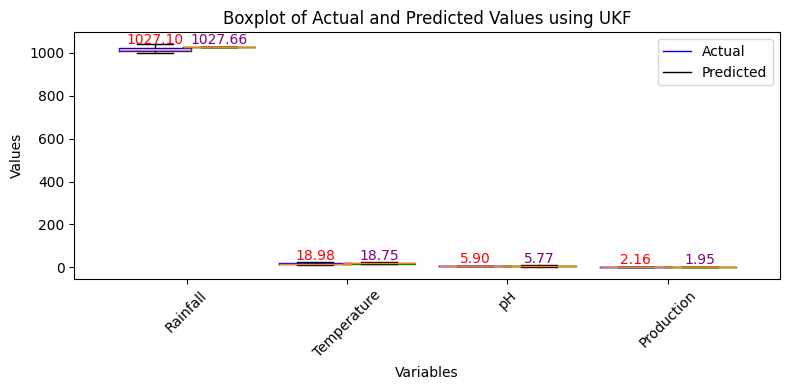

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/combinedSukf.xlsx"
data = pd.read_excel(file_path)

# Extract all column names
all_columns = data.columns

# List of variable names with the prefix "Actual_"
variable_names = [col for col in all_columns if col.startswith("Actual_")]

# Remove the prefix from variable names
variable_names_without_prefix = [col.replace("Actual_", "") for col in variable_names]

# Print column names for debugging
print("All Columns:", all_columns)

# Create boxplots for the actual and predicted values of all variables
plt.figure(figsize=(8, 4))

# Check if 'Predicted_' columns exist before trying to access them
data_to_plot_actual = []  # Corrected variable name
data_to_plot_predicted = []

for col in variable_names:
    actual_col_name = col  # No need to replace the prefix for actual values
    predicted_col_name = col.replace("Actual_", "Predicted_")
    
    if actual_col_name in all_columns:
        data_to_plot_actual.append(data[actual_col_name])  # Append actual data
    else:
        print(f"Column '{actual_col_name}' not found.")
    
    if predicted_col_name in all_columns:
        data_to_plot_predicted.append(data[predicted_col_name])
    else:
        print(f"Column '{predicted_col_name}' not found.")

# Define box properties for actual and predicted
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')
boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual and predicted values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=[pos - width/2 for pos in positions], boxprops=boxprops_actual)
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=[pos + width/2 for pos in positions], boxprops=boxprops_predicted)

# Display variable names without prefix on the x-axis
plt.xticks(positions, variable_names_without_prefix, rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos - width/2, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='red')

# Display mean values for predicted values on top of each boxplot
mean_values_predicted = [data[col.replace("Actual_", "Predicted_")].mean() for col in variable_names]
for pos, mean_val in zip([pos + width/2 for pos in positions], mean_values_predicted):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='purple')

plt.title("Boxplot of Actual and Predicted Values using UKF")
plt.xlabel("Variables")
plt.ylabel("Values")

# Create a single legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.tight_layout()
plt.show()


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ... (rest of the code remains unchanged)

# Initialize lists to store actual and predicted data
all_data = {'Time Step': list(range(1, num_time_steps))}  # Assuming time steps start from 1

# Iterate through each variable (column) in the dataset
for col in data.columns:
    for t in range(1, num_time_steps):
        # ... (rest of the code remains unchanged)

        # Append the actual and predicted data to the list
        all_data[f'Actual {col}'] = data[col].iloc[1:].tolist()
        all_data[f'Predicted {col}'] = state_estimates[col]

# Create a DataFrame from the actual and predicted data
all_data_df = pd.DataFrame(all_data)

# Save the DataFrame to a CSV file on the desktop
csv_file_path = desktop_path + "actual_and_predicted_data.csv"
all_data_df.to_csv(csv_file_path, index=False)

# ... (rest of the code remains unchanged)


TypeError: list indices must be integers or slices, not str

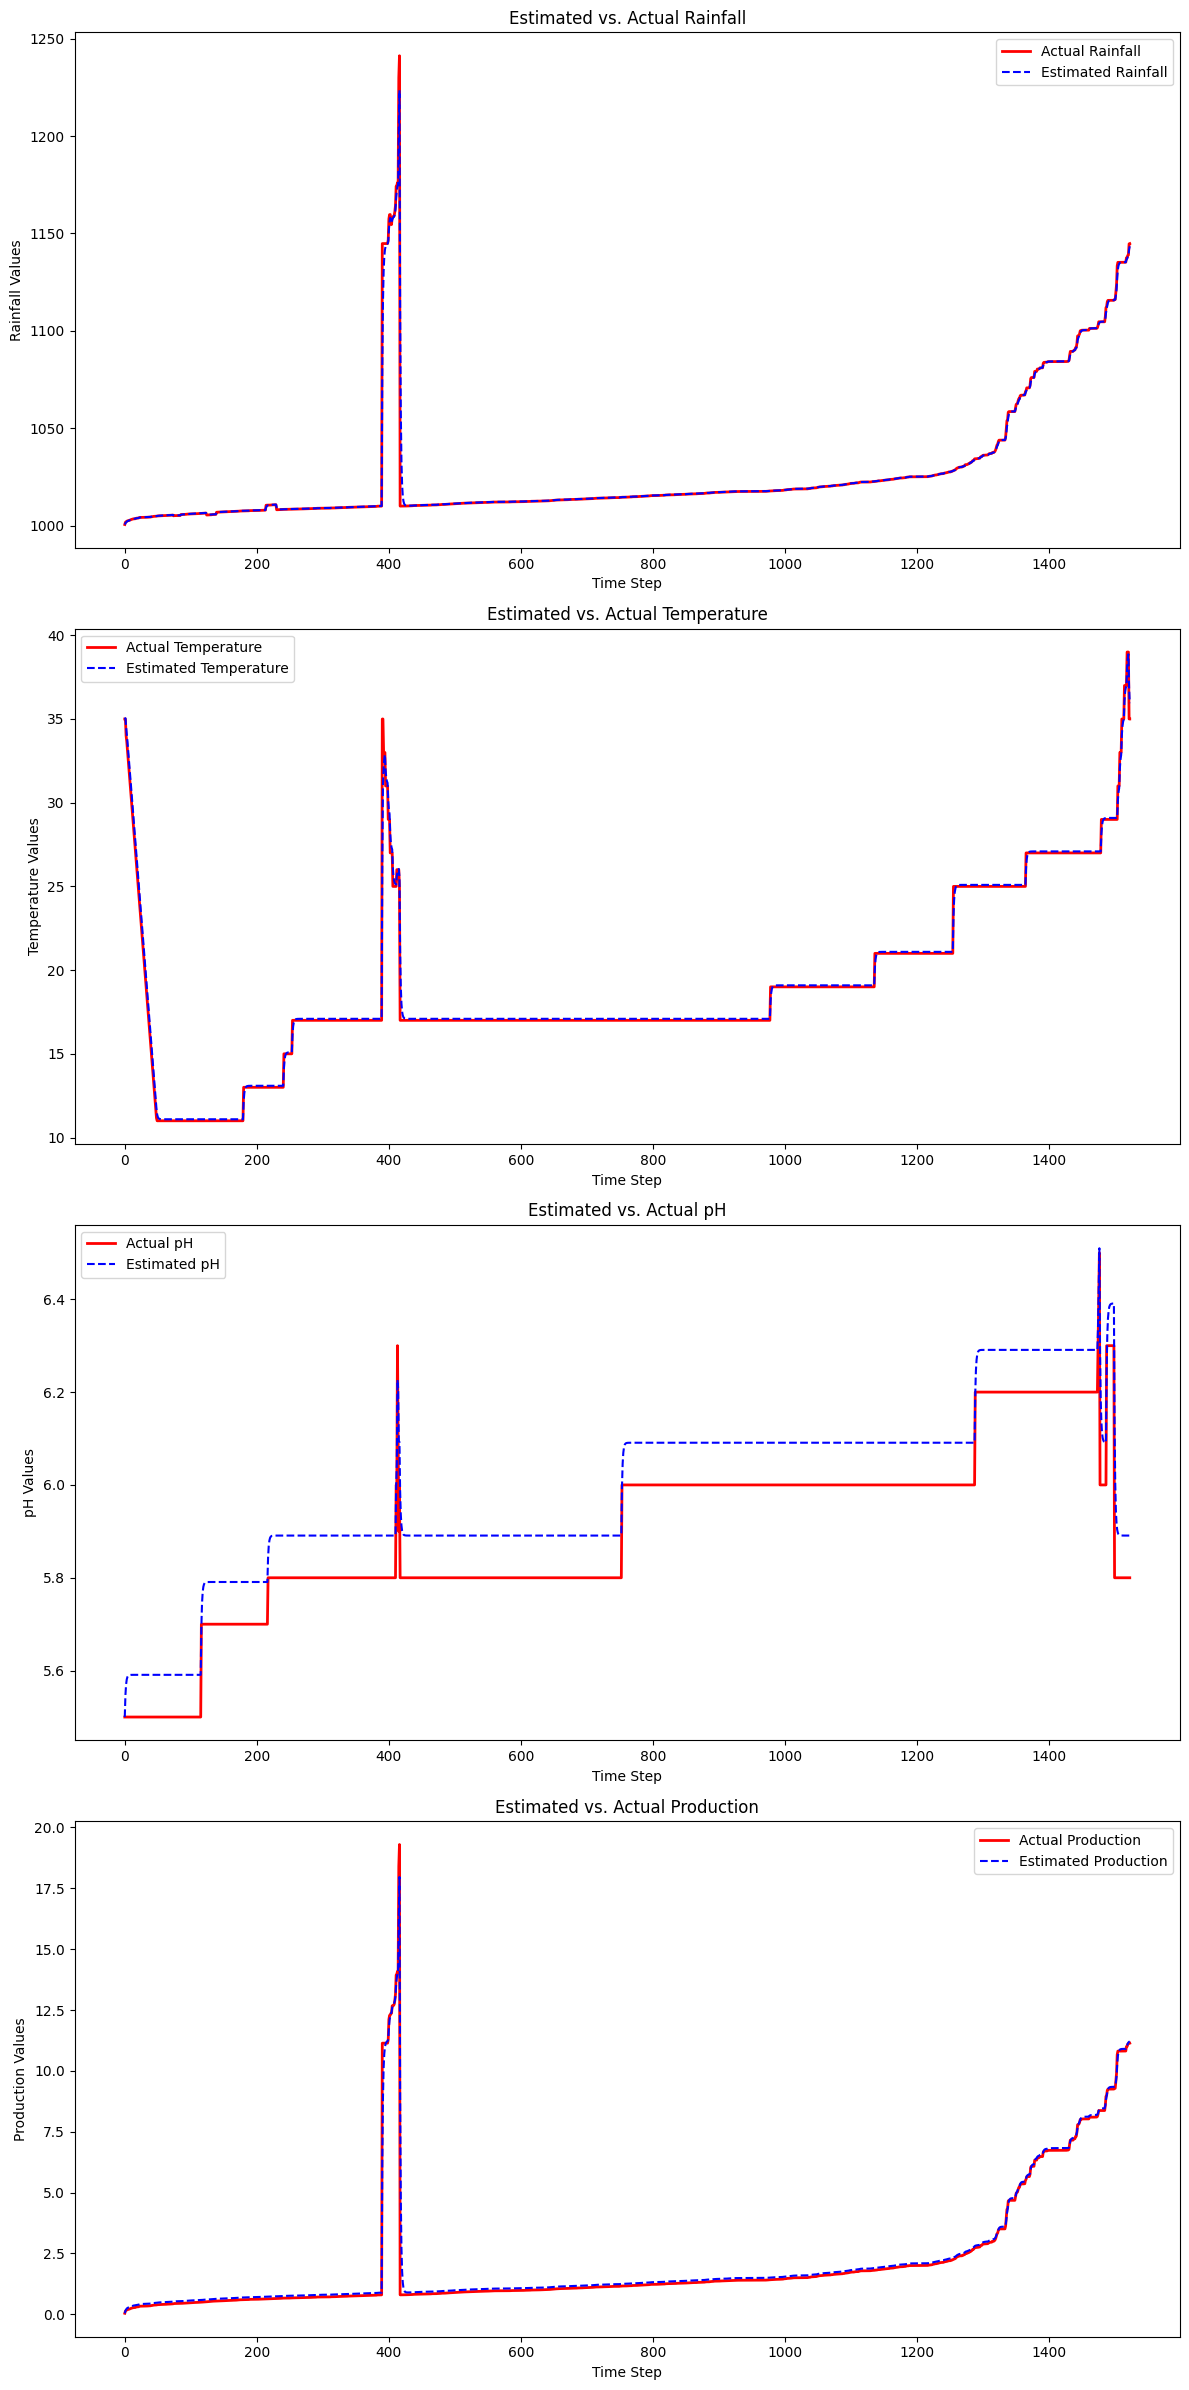

Pearson Correlation for Rainfall: 0.99
Pearson Correlation for Temperature: 1.00
Pearson Correlation for pH: 1.00
Pearson Correlation for Production: 0.99


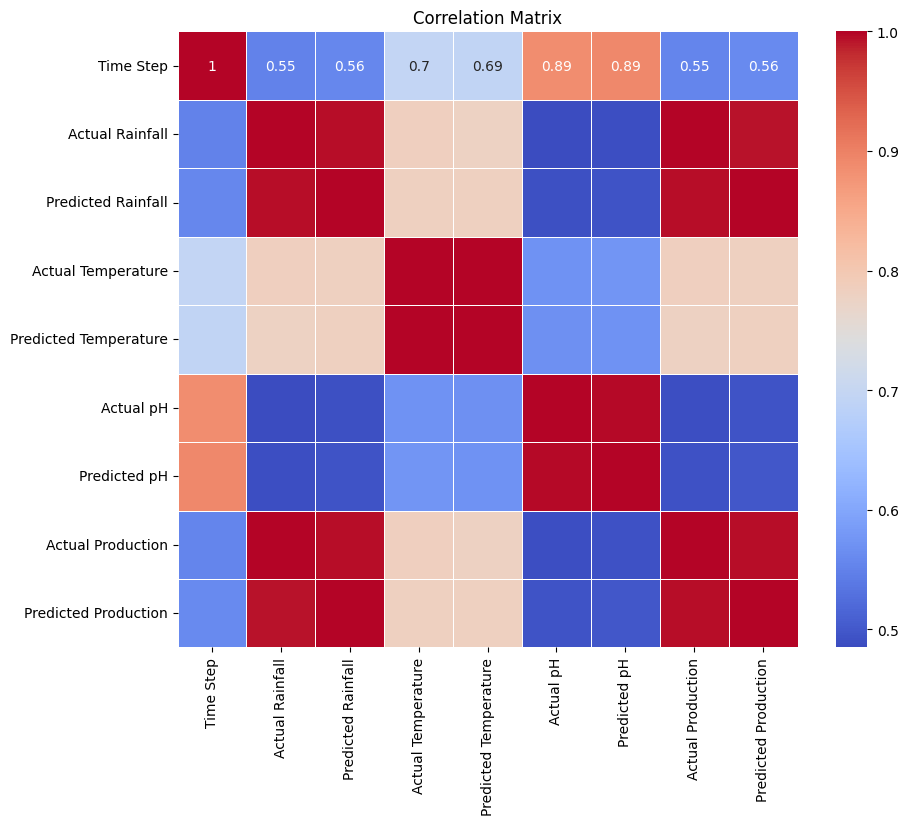

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the system dynamics (for demonstration, we use a simple moisture diffusion model)
def process_model(state, dt):
    moisture_diffusion_coefficient = 0.1  # Adjust based on your system
    new_state = state + moisture_diffusion_coefficient * dt
    return new_state

def measurement_model(state):
    measurement_noise = np.random.normal(0, 0.1)
    return state + measurement_noise

# Updated file path
file_path = "/Users/egasarmando/Desktop/soil.xlsx"  # Update with your file path
data = pd.read_excel(file_path)  # Read data from the Excel file

# Initialize Kalman filter parameters
initial_state = data.iloc[0]  # Initial state estimate

# Number of time steps
num_time_steps = len(data)

# Initialize lists to store state estimates for each variable
state_estimates = {col: [initial_state[col]] for col in data.columns}

# Initialize Kalman filter parameters for each variable
initial_covariance = {col: 0.1 for col in data.columns}
process_noise = {col: 0.01 for col in data.columns}
measurement_noise = {col: 0.1 for col in data.columns}

# Initialize lists to store actual and predicted data
all_data = {'Time Step': list(range(1, num_time_steps))}  # Assuming time steps start from 1

# Iterate through each variable (column) in the dataset
for col in data.columns:
    all_data[f'Actual {col}'] = data[col].iloc[1:].tolist()  # Assuming time steps start from 1
    all_data[f'Predicted {col}'] = []  # Initialize an empty list for predicted values
    for t in range(1, num_time_steps):
        dt = 1  # Assuming a fixed time step

        # Prediction step for the current variable
        state_estimate = process_model(state_estimates[col][-1], dt)
        covariance_estimate = initial_covariance[col] + process_noise[col]

        # Update step for the current variable
        kalman_gain = covariance_estimate / (covariance_estimate + measurement_noise[col])
        state_estimate += kalman_gain * (data[col].iloc[t] - state_estimate)
        covariance_estimate = (1 - kalman_gain) * covariance_estimate

        # Append the state estimate to the list for the current variable
        state_estimates[col].append(state_estimate)

        # Append the predicted data to the list for the current variable
        all_data[f'Predicted {col}'].append(state_estimate)

# Create a DataFrame from the actual and predicted data
all_data_df = pd.DataFrame(all_data)

# Save the DataFrame to a CSV file on the desktop
desktop_path = "/Users/egasarmando/Desktop/"
csv_file_path = desktop_path + "actual_and_predicted_data.csv"
all_data_df.to_csv(csv_file_path, index=False)

# Create plots to visualize the results for each variable
plt.figure(figsize=(12, 6 * len(data.columns)))
for i, col in enumerate(data.columns):
    plt.subplot(len(data.columns), 1, i + 1)
    
    plt.plot(data[col], label=f'Actual {col}', linewidth=2, color='red')
    plt.plot(state_estimates[col], label=f'Estimated {col}', linestyle='--', color='blue')

    plt.title(f'Estimated vs. Actual {col}')
    plt.xlabel('Time Step')
    plt.ylabel(f'{col} Values')
    plt.legend()

    plt.grid(False)

plt.tight_layout()
plt.show()

# Calculate and print Pearson correlations
for col in data.columns:
    actual_values = all_data_df[f'Actual {col}']
    estimated_values = all_data_df[f'Predicted {col}']
    correlation = actual_values.corr(estimated_values)
    print(f"Pearson Correlation for {col}: {correlation:.2f}")

# Create a correlation matrix plot
correlation_matrix = all_data_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


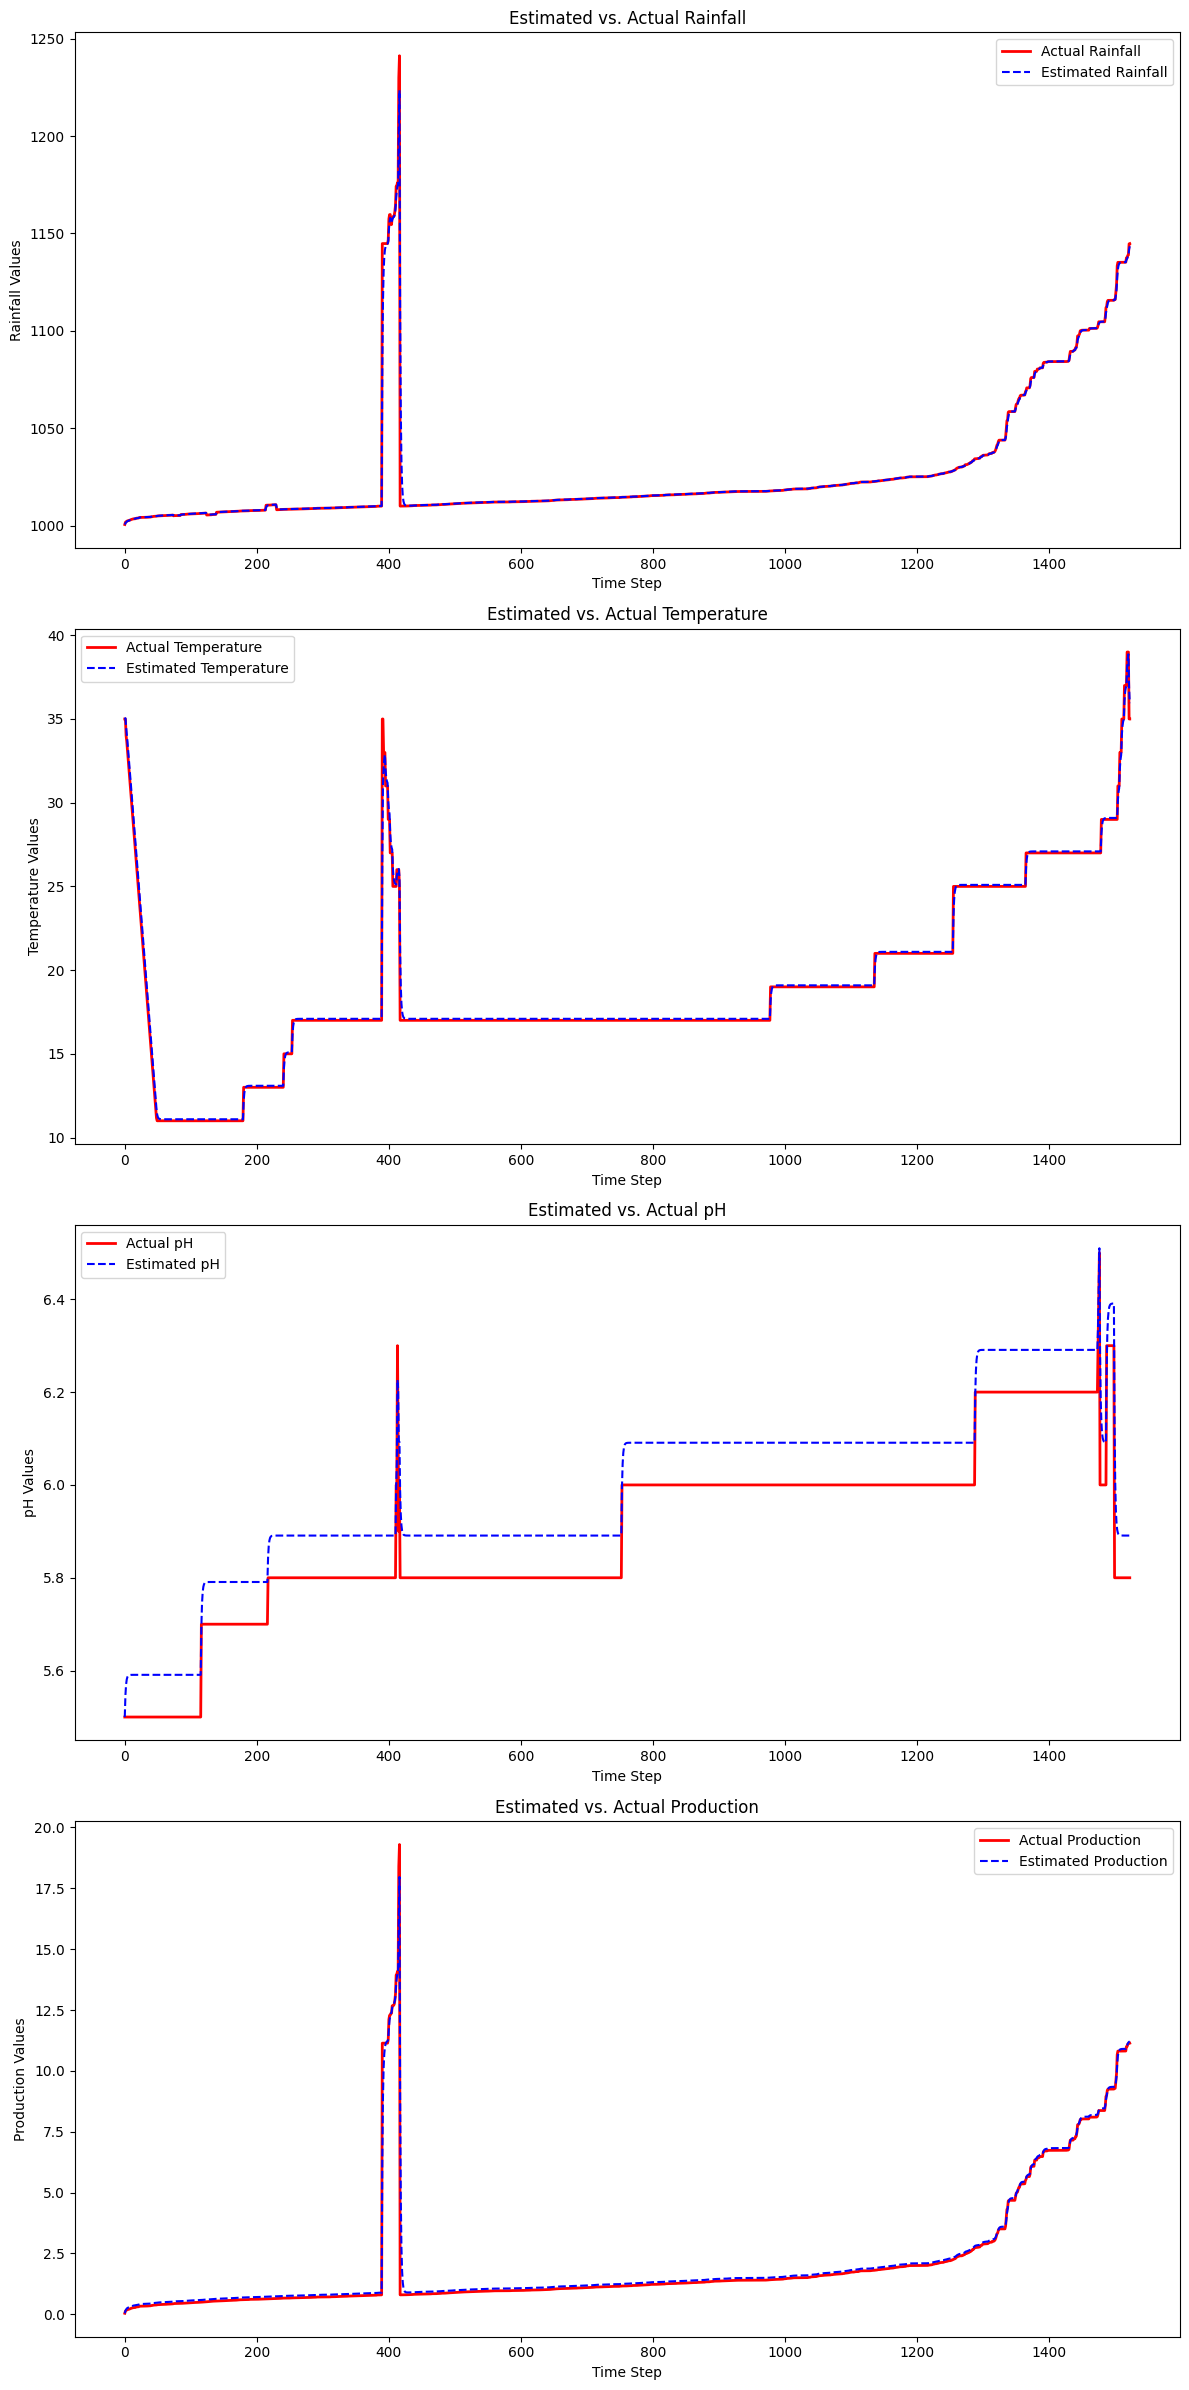

Pearson Correlation for Rainfall: 0.99
Pearson Correlation for Temperature: 1.00
Pearson Correlation for pH: 1.00
Pearson Correlation for Production: 0.99


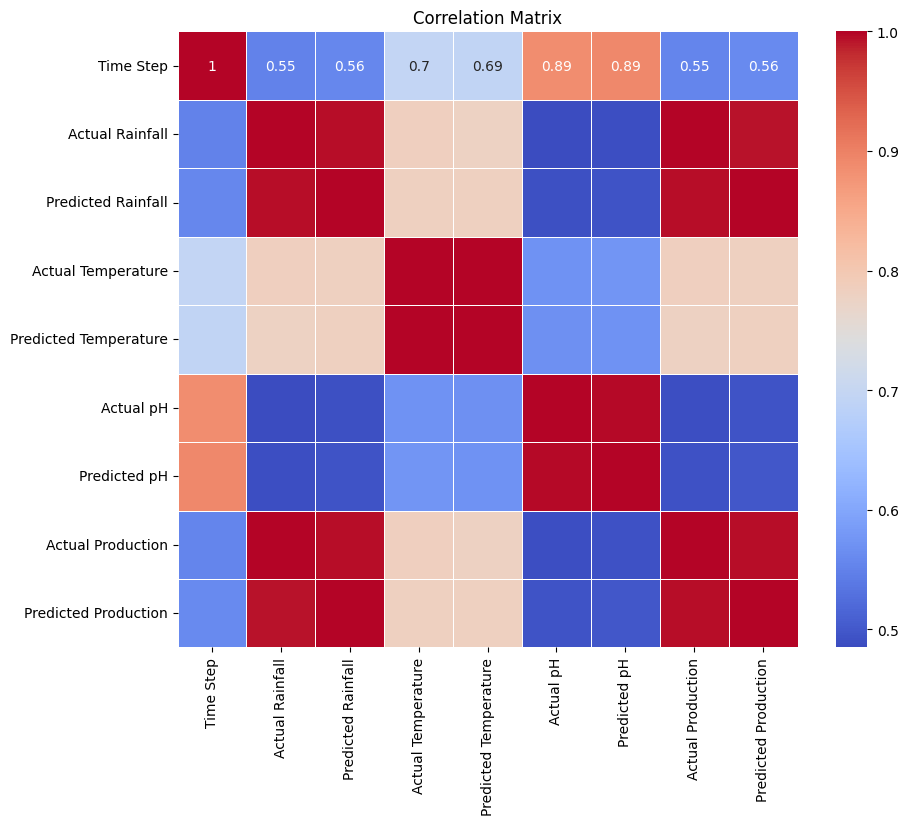

Memory usage of <class 'pandas.core.frame.DataFrame'>: 48900 bytes
Memory usage of <class 'dict'>: 184 bytes
Memory usage of <class 'dict'>: 272 bytes
Memory usage of <class 'pandas.core.frame.DataFrame'>: 109748 bytes
Memory usage of <class 'pandas.core.frame.DataFrame'>: 1632 bytes


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys  # Import sys module for memory calculations

# Define the system dynamics (for demonstration, we use a simple moisture diffusion model)
def process_model(state, dt):
    moisture_diffusion_coefficient = 0.1  # Adjust based on your system
    new_state = state + moisture_diffusion_coefficient * dt
    return new_state

def measurement_model(state):
    measurement_noise = np.random.normal(0, 0.1)
    return state + measurement_noise

# Updated file path
file_path = "/Users/egasarmando/Desktop/soil.xlsx"  # Update with your file path
data = pd.read_excel(file_path)  # Read data from the Excel file

# Initialize Kalman filter parameters
initial_state = data.iloc[0]  # Initial state estimate

# Number of time steps
num_time_steps = len(data)

# Initialize lists to store state estimates for each variable
state_estimates = {col: [initial_state[col]] for col in data.columns}

# Initialize Kalman filter parameters for each variable
initial_covariance = {col: 0.1 for col in data.columns}
process_noise = {col: 0.01 for col in data.columns}
measurement_noise = {col: 0.1 for col in data.columns}

# Initialize lists to store actual and predicted data
all_data = {'Time Step': list(range(1, num_time_steps))}  # Assuming time steps start from 1

# Iterate through each variable (column) in the dataset
for col in data.columns:
    all_data[f'Actual {col}'] = data[col].iloc[1:].tolist()  # Assuming time steps start from 1
    all_data[f'Predicted {col}'] = []  # Initialize an empty list for predicted values
    for t in range(1, num_time_steps):
        dt = 1  # Assuming a fixed time step

        # Prediction step for the current variable
        state_estimate = process_model(state_estimates[col][-1], dt)
        covariance_estimate = initial_covariance[col] + process_noise[col]

        # Update step for the current variable
        kalman_gain = covariance_estimate / (covariance_estimate + measurement_noise[col])
        state_estimate += kalman_gain * (data[col].iloc[t] - state_estimate)
        covariance_estimate = (1 - kalman_gain) * covariance_estimate

        # Append the state estimate to the list for the current variable
        state_estimates[col].append(state_estimate)

        # Append the predicted data to the list for the current variable
        all_data[f'Predicted {col}'].append(state_estimate)

# Create a DataFrame from the actual and predicted data
all_data_df = pd.DataFrame(all_data)

# Save the DataFrame to a CSV file on the desktop
desktop_path = "/Users/egasarmando/Desktop/"
csv_file_path = desktop_path + "actual_and_predicted_data.csv"
all_data_df.to_csv(csv_file_path, index=False)

# Create plots to visualize the results for each variable
plt.figure(figsize=(12, 6 * len(data.columns)))
for i, col in enumerate(data.columns):
    plt.subplot(len(data.columns), 1, i + 1)
    
    plt.plot(data[col], label=f'Actual {col}', linewidth=2, color='red')
    plt.plot(state_estimates[col], label=f'Estimated {col}', linestyle='--', color='blue')

    plt.title(f'Estimated vs. Actual {col}')
    plt.xlabel('Time Step')
    plt.ylabel(f'{col} Values')
    plt.legend()

    plt.grid(False)

plt.tight_layout()
plt.show()

# Calculate and print Pearson correlations
for col in data.columns:
    actual_values = all_data_df[f'Actual {col}']
    estimated_values = all_data_df[f'Predicted {col}']
    correlation = actual_values.corr(estimated_values)
    print(f"Pearson Correlation for {col}: {correlation:.2f}")

# Create a correlation matrix plot
correlation_matrix = all_data_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Calculate memory usage of specific objects
objects_to_measure = [data, state_estimates, all_data, all_data_df, correlation_matrix]

for obj in objects_to_measure:
    memory_usage = sys.getsizeof(obj)
    print(f"Memory usage of {type(obj)}: {memory_usage} bytes")


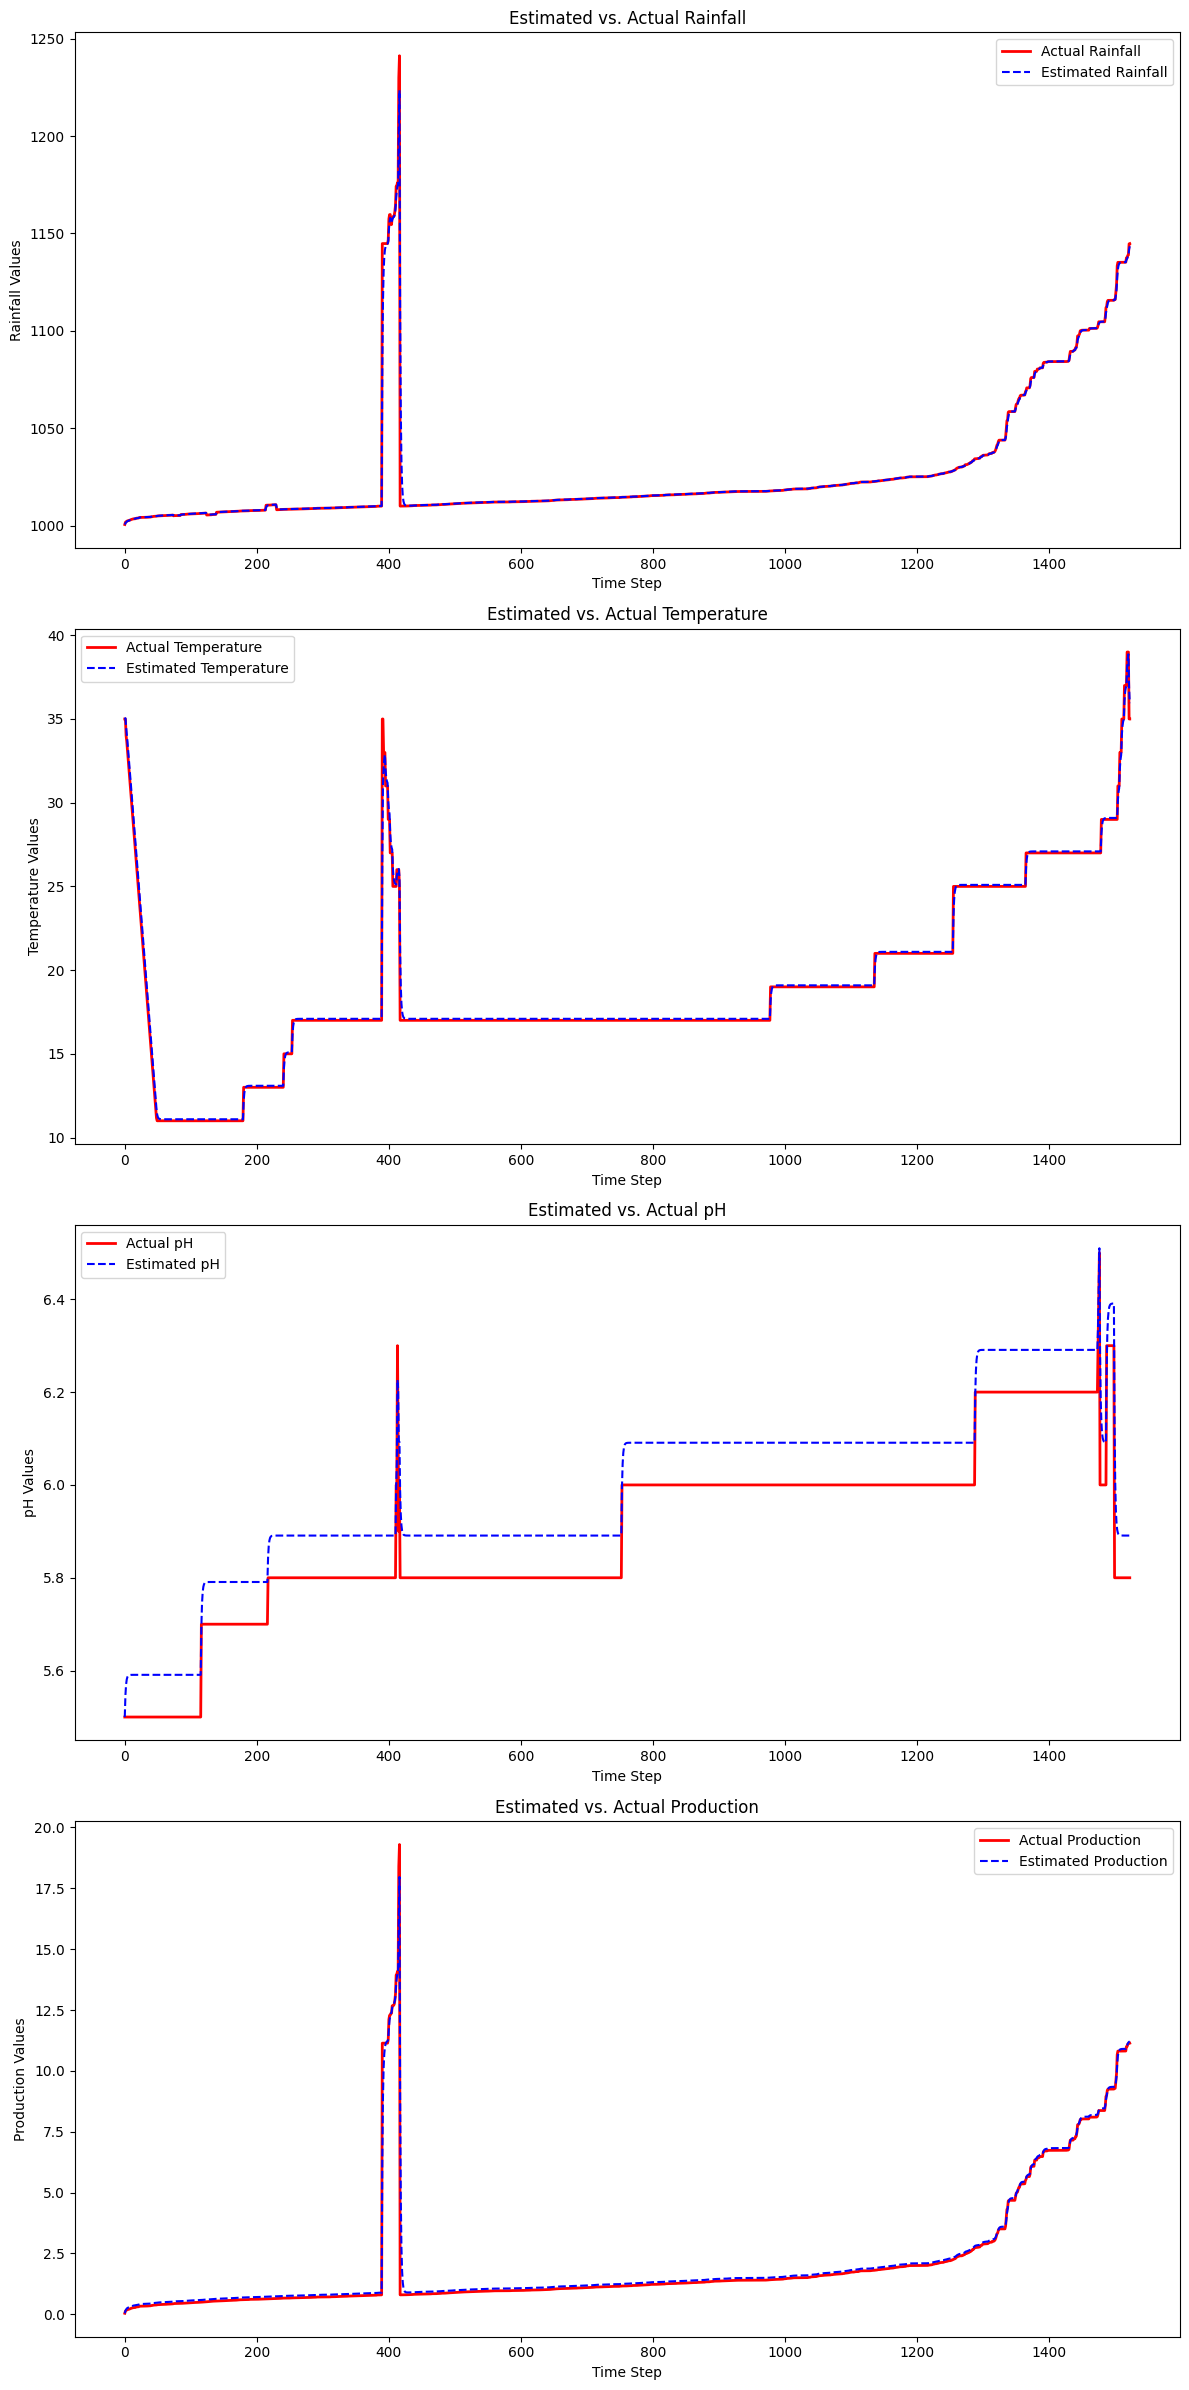

Pearson Correlation for Rainfall: 0.99
Pearson Correlation for Temperature: 1.00
Pearson Correlation for pH: 1.00
Pearson Correlation for Production: 0.99


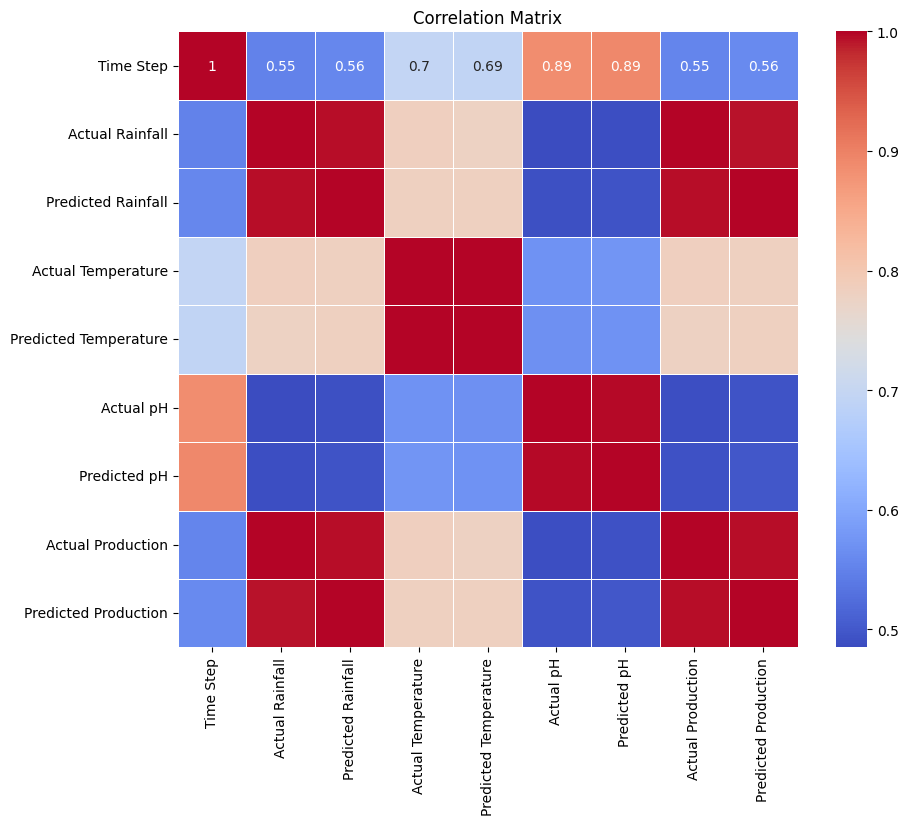

Memory usage of <class 'pandas.core.frame.DataFrame'>: 48900 bytes
Memory usage of <class 'dict'>: 184 bytes
Memory usage of <class 'dict'>: 272 bytes
Memory usage of <class 'pandas.core.frame.DataFrame'>: 109748 bytes
Memory usage of <class 'pandas.core.frame.DataFrame'>: 1632 bytes
Total memory usage: 160736 bytes


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys  # Import sys module for memory calculations

# Define the system dynamics (for demonstration, we use a simple moisture diffusion model)
def process_model(state, dt):
    moisture_diffusion_coefficient = 0.1  # Adjust based on your system
    new_state = state + moisture_diffusion_coefficient * dt
    return new_state

def measurement_model(state):
    measurement_noise = np.random.normal(0, 0.1)
    return state + measurement_noise

# Updated file path
file_path = "/Users/egasarmando/Desktop/soil.xlsx"  # Update with your file path
data = pd.read_excel(file_path)  # Read data from the Excel file

# Initialize Kalman filter parameters
initial_state = data.iloc[0]  # Initial state estimate

# Number of time steps
num_time_steps = len(data)

# Initialize lists to store state estimates for each variable
state_estimates = {col: [initial_state[col]] for col in data.columns}

# Initialize Kalman filter parameters for each variable
initial_covariance = {col: 0.1 for col in data.columns}
process_noise = {col: 0.01 for col in data.columns}
measurement_noise = {col: 0.1 for col in data.columns}

# Initialize lists to store actual and predicted data
all_data = {'Time Step': list(range(1, num_time_steps))}  # Assuming time steps start from 1

# Iterate through each variable (column) in the dataset
for col in data.columns:
    all_data[f'Actual {col}'] = data[col].iloc[1:].tolist()  # Assuming time steps start from 1
    all_data[f'Predicted {col}'] = []  # Initialize an empty list for predicted values
    for t in range(1, num_time_steps):
        dt = 1  # Assuming a fixed time step

        # Prediction step for the current variable
        state_estimate = process_model(state_estimates[col][-1], dt)
        covariance_estimate = initial_covariance[col] + process_noise[col]

        # Update step for the current variable
        kalman_gain = covariance_estimate / (covariance_estimate + measurement_noise[col])
        state_estimate += kalman_gain * (data[col].iloc[t] - state_estimate)
        covariance_estimate = (1 - kalman_gain) * covariance_estimate

        # Append the state estimate to the list for the current variable
        state_estimates[col].append(state_estimate)

        # Append the predicted data to the list for the current variable
        all_data[f'Predicted {col}'].append(state_estimate)

# Create a DataFrame from the actual and predicted data
all_data_df = pd.DataFrame(all_data)

# Save the DataFrame to a CSV file on the desktop
desktop_path = "/Users/egasarmando/Desktop/"
csv_file_path = desktop_path + "actual_and_predicted_data.csv"
all_data_df.to_csv(csv_file_path, index=False)

# Create plots to visualize the results for each variable
plt.figure(figsize=(12, 6 * len(data.columns)))
for i, col in enumerate(data.columns):
    plt.subplot(len(data.columns), 1, i + 1)
    
    plt.plot(data[col], label=f'Actual {col}', linewidth=2, color='red')
    plt.plot(state_estimates[col], label=f'Estimated {col}', linestyle='--', color='blue')

    plt.title(f'Estimated vs. Actual {col}')
    plt.xlabel('Time Step')
    plt.ylabel(f'{col} Values')
    plt.legend()

    plt.grid(False)

plt.tight_layout()
plt.show()

# Calculate and print Pearson correlations
for col in data.columns:
    actual_values = all_data_df[f'Actual {col}']
    estimated_values = all_data_df[f'Predicted {col}']
    correlation = actual_values.corr(estimated_values)
    print(f"Pearson Correlation for {col}: {correlation:.2f}")

# Create a correlation matrix plot
correlation_matrix = all_data_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Calculate memory usage of specific objects
objects_to_measure = [data, state_estimates, all_data, all_data_df, correlation_matrix]

total_memory_usage = 0
for obj in objects_to_measure:
    memory_usage = sys.getsizeof(obj)
    total_memory_usage += memory_usage
    print(f"Memory usage of {type(obj)}: {memory_usage} bytes")

print(f"Total memory usage: {total_memory_usage} bytes")


All Columns: Index(['Actual_Rainfall', 'Predicted_Rainfall', 'Actual_Temperature',
       'Predicted_Temperature', 'Actual_pH', 'Predicted_pH',
       'Actual_Production', 'Predicted_Production'],
      dtype='object')
Column 'Actual_Actual_Rainfall' not found.
Column 'Predicted_Actual_Rainfall' not found.
Column 'Actual_Predicted_Rainfall' not found.
Column 'Predicted_Predicted_Rainfall' not found.
Column 'Actual_Actual_Temperature' not found.
Column 'Predicted_Actual_Temperature' not found.
Column 'Actual_Predicted_Temperature' not found.
Column 'Predicted_Predicted_Temperature' not found.
Column 'Actual_Actual_pH' not found.
Column 'Predicted_Actual_pH' not found.
Column 'Actual_Predicted_pH' not found.
Column 'Predicted_Predicted_pH' not found.
Column 'Actual_Actual_Production' not found.
Column 'Predicted_Actual_Production' not found.
Column 'Actual_Predicted_Production' not found.
Column 'Predicted_Predicted_Production' not found.


ValueError: List of boxplot statistics and `positions` values must have same the length

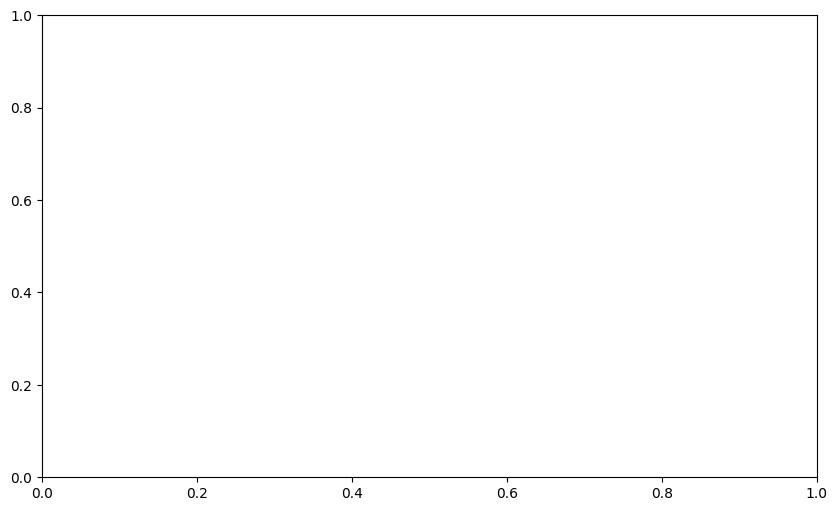

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Extract all column names
all_columns = data.columns

# Define the variable names with prefixes
variable_names = [
    "Actual_Rainfall",
    "Predicted_Rainfall",
    "Actual_Temperature",
    "Predicted_Temperature",
    "Actual_pH",
    "Predicted_pH",
    "Actual_Production",
    "Predicted_Production"
]

# Remove the prefix from variable names for x-axis labels
variable_names_without_prefix = [col.replace("Actual_", "") for col in variable_names]

# Print column names for debugging
print("All Columns:", all_columns)

# Create boxplots for the actual and predicted values of all variables
plt.figure(figsize=(10, 6))

# Check if 'Predicted_' columns exist before trying to access them
data_to_plot_actual = []
data_to_plot_predicted = []

for col in variable_names:
    actual_col_name = "Actual_" + col
    predicted_col_name = "Predicted_" + col
    
    if actual_col_name in all_columns:
        data_to_plot_actual.append(data[actual_col_name])
    else:
        print(f"Column '{actual_col_name}' not found.")
    
    if predicted_col_name in all_columns:
        data_to_plot_predicted.append(data[predicted_col_name])
    else:
        print(f"Column '{predicted_col_name}' not found.")

# Define box properties for actual and predicted
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')
boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual and predicted values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=[pos - width/2 for pos in positions], boxprops=boxprops_actual)
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=[pos + width/2 for pos in positions], boxprops=boxprops_predicted)

# Display variable names without prefix on the x-axis
plt.xticks(positions, variable_names_without_prefix, rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos - width/2, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='red')

# Display mean values for predicted values on top of each boxplot
mean_values_predicted = [data[col.replace("Actual_", "Predicted_")].mean() for col in variable_names]
for pos, mean_val in zip([pos + width/2 for pos in positions], mean_values_predicted):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='purple')

plt.title("Boxplot of Actual and Predicted Values using UKF")
plt.xlabel("Variables")
plt.ylabel("Values")

# Create a single legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Predicted_Rainfall', 'Actual_Temperature',
       'Predicted_Temperature', 'Actual_pH', 'Predicted_pH',
       'Actual_Production', 'Predicted_Production'],
      dtype='object')


KeyError: 'Rainfall'

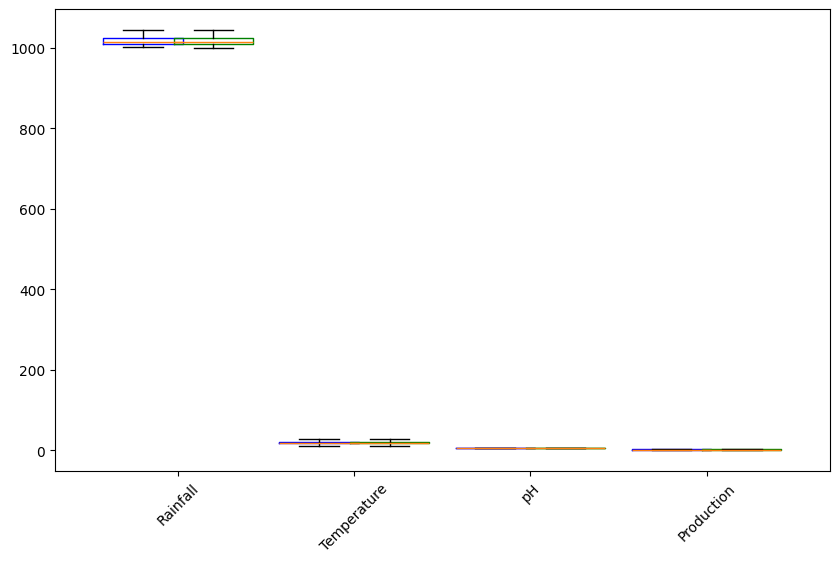

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    "Rainfall",
    "Temperature",
    "pH",
    "Production"
]

# Print column names for debugging
print("All Columns:", all_columns)

# Create boxplots for the actual and predicted values of all variables
plt.figure(figsize=(10, 6))

# Check if 'Predicted_' columns exist before trying to access them
data_to_plot_actual = []
data_to_plot_predicted = []

for col in variable_names:
    actual_col_name = "Actual_" + col
    predicted_col_name = "Predicted_" + col
    
    if actual_col_name in all_columns:
        data_to_plot_actual.append(data[actual_col_name])
    else:
        print(f"Column '{actual_col_name}' not found.")
    
    if predicted_col_name in all_columns:
        data_to_plot_predicted.append(data[predicted_col_name])
    else:
        print(f"Column '{predicted_col_name}' not found.")

# Define box properties for actual and predicted
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')
boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual and predicted values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=[pos - width/2 for pos in positions], boxprops=boxprops_actual)
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=[pos + width/2 for pos in positions], boxprops=boxprops_predicted)

# Display variable names on the x-axis
plt.xticks(positions, variable_names, rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos - width/2, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='red')

# Display mean values for predicted values on top of each boxplot
mean_values_predicted = [data[col.replace("Actual_", "Predicted_")].mean() for col in variable_names]
for pos, mean_val in zip([pos + width/2 for pos in positions], mean_values_predicted):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='purple')

plt.title("Boxplot of Actual and Predicted Values using UKF")
plt.xlabel("Variables")
plt.ylabel("Values")

# Create a single legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Predicted_Rainfall', 'Actual_Temperature',
       'Predicted_Temperature', 'Actual_pH', 'Predicted_pH',
       'Actual_Production', 'Predicted_Production'],
      dtype='object')
All Columns: Index(['Actual_Rainfall', 'Predicted_Rainfall', 'Actual_Temperature',
       'Predicted_Temperature', 'Actual_pH', 'Predicted_pH',
       'Actual_Production', 'Predicted_Production'],
      dtype='object')


KeyError: 'Rainfall'

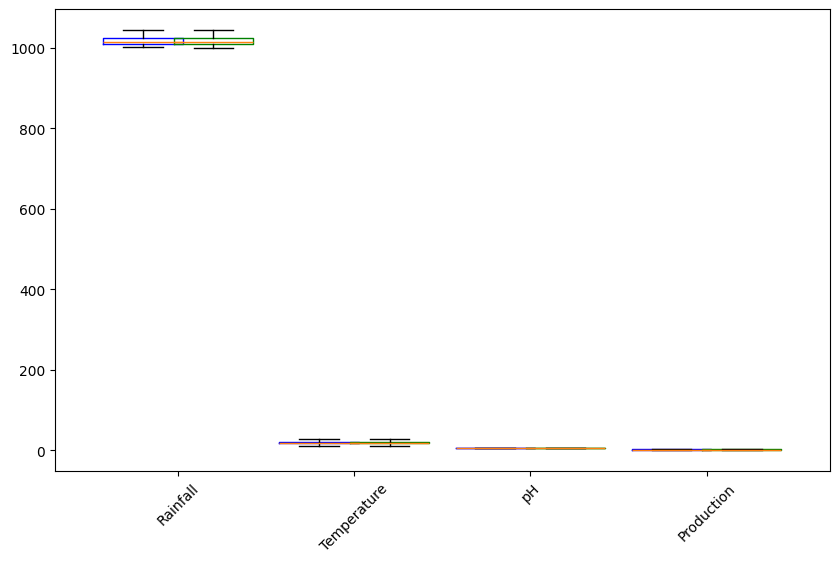

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Print all column names for debugging
print("All Columns:", data.columns)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    "Rainfall",
    "Temperature",
    "pH",
    "Production"
]

# Print column names for debugging
print("All Columns:", all_columns)

# Create boxplots for the actual and predicted values of all variables
plt.figure(figsize=(10, 6))

# Check if 'Predicted_' columns exist before trying to access them
data_to_plot_actual = []
data_to_plot_predicted = []

for col in variable_names:
    actual_col_name = "Actual_" + col
    predicted_col_name = "Predicted_" + col
    
    if actual_col_name in all_columns:
        data_to_plot_actual.append(data[actual_col_name])
    else:
        print(f"Column '{actual_col_name}' not found.")
    
    if predicted_col_name in all_columns:
        data_to_plot_predicted.append(data[predicted_col_name])
    else:
        print(f"Column '{predicted_col_name}' not found.")

# Define box properties for actual and predicted
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')
boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual and predicted values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=[pos - width/2 for pos in positions], boxprops=boxprops_actual)
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=[pos + width/2 for pos in positions], boxprops=boxprops_predicted)

# Display variable names on the x-axis
plt.xticks(positions, variable_names, rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos - width/2, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='red')

# Display mean values for predicted values on top of each boxplot
mean_values_predicted = [data[col.replace("Actual_", "Predicted_")].mean() for col in variable_names]
for pos, mean_val in zip([pos + width/2 for pos in positions], mean_values_predicted):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='purple')

plt.title("Boxplot of Actual and Predicted Values using UKF")
plt.xlabel("Variables")
plt.ylabel("Values")

# Create a single legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Predicted_Rainfall', 'Actual_Temperature',
       'Predicted_Temperature', 'Actual_pH', 'Predicted_pH',
       'Actual_Production', 'Predicted_Production'],
      dtype='object')
All Columns: Index(['Actual_Rainfall', 'Predicted_Rainfall', 'Actual_Temperature',
       'Predicted_Temperature', 'Actual_pH', 'Predicted_pH',
       'Actual_Production', 'Predicted_Production'],
      dtype='object')


KeyError: 'Rainfall'

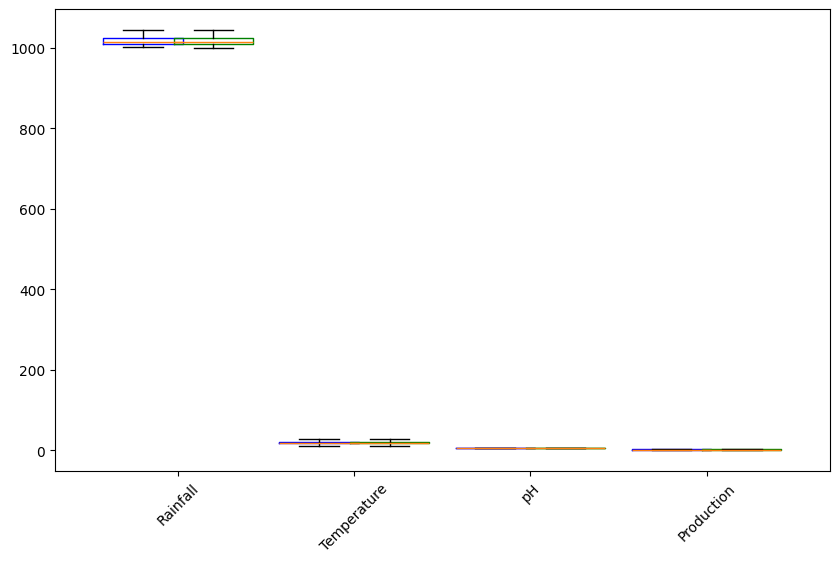

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Print all column names for debugging
print("All Columns:", data.columns)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    "Rainfall",
    "Temperature",
    "pH",
    "Production"
]

# Print column names for debugging
print("All Columns:", all_columns)

# Create boxplots for the actual and predicted values of all variables
plt.figure(figsize=(10, 6))

# Check if 'Predicted_' columns exist before trying to access them
data_to_plot_actual = []
data_to_plot_predicted = []

for col in variable_names:
    actual_col_name = "Actual_" + col
    predicted_col_name = "Predicted_" + col
    
    if actual_col_name in all_columns:
        data_to_plot_actual.append(data[actual_col_name])
    else:
        print(f"Column '{actual_col_name}' not found.")
    
    if predicted_col_name in all_columns:
        data_to_plot_predicted.append(data[predicted_col_name])
    else:
        print(f"Column '{predicted_col_name}' not found.")

# Define box properties for actual and predicted
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')
boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual and predicted values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=[pos - width/2 for pos in positions], boxprops=boxprops_actual)
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=[pos + width/2 for pos in positions], boxprops=boxprops_predicted)

# Display variable names on the x-axis
plt.xticks(positions, variable_names, rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos - width/2, mean_val + 0.1, f'Mean: {mean_val:.2f}', ha='center', va='bottom', color='red')

# Display mean values for predicted values on top of each boxplot
mean_values_predicted = [data[col.replace("Actual_", "Predicted_")].mean() for col in variable_names]
for pos, mean_val in zip([pos + width/2 for pos in positions], mean_values_predicted):
    plt.text(pos, mean_val + 0.1, f'Mean: {mean_val:.2f}', ha='center', va='bottom', color='purple')

plt.title("Boxplot of Actual and Predicted Values using UKF")
plt.xlabel("Variables")
plt.ylabel("Values")

# Create a single legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Predicted_Rainfall', 'Actual_Temperature',
       'Predicted_Temperature', 'Actual_pH', 'Predicted_pH',
       'Actual_Production', 'Predicted_Production'],
      dtype='object')


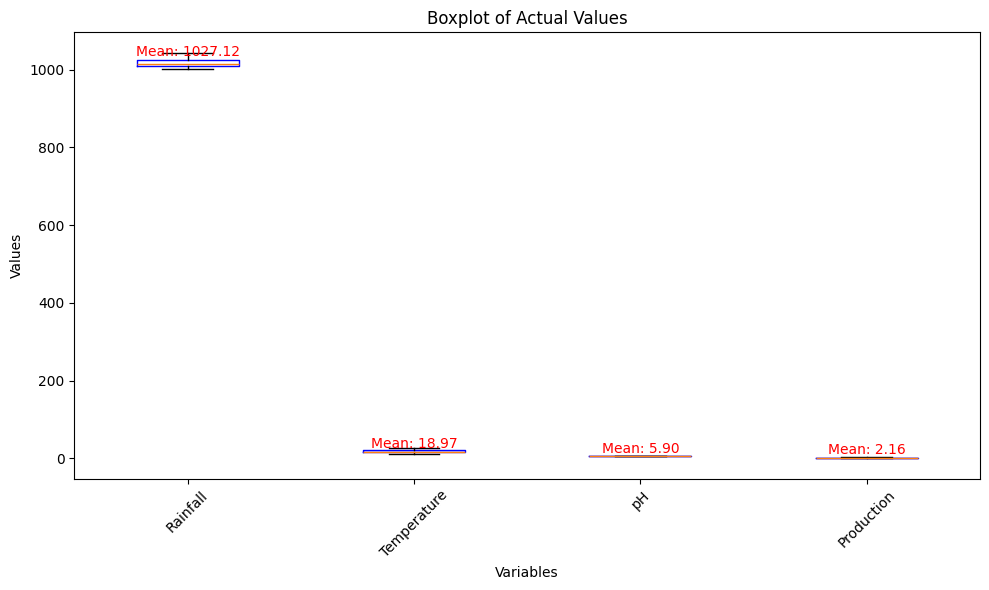

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Print all column names for debugging
print("All Columns:", data.columns)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    'Actual_Rainfall',
    'Actual_Temperature',
    'Actual_pH',
    'Actual_Production'
]

# Create boxplots for the actual values of all variables
plt.figure(figsize=(10, 6))

# Check if columns exist before trying to access them
data_to_plot_actual = []

for col in variable_names:
    if col in all_columns:
        data_to_plot_actual.append(data[col])
    else:
        print(f"Column '{col}' not found.")

# Define box properties for actual
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=positions, boxprops=boxprops_actual)

# Display variable names on the x-axis
plt.xticks(positions, [col.split('_')[1] for col in variable_names], rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos, mean_val + 0.1, f'Mean: {mean_val:.2f}', ha='center', va='bottom', color='red')

plt.title("Boxplot of Actual Values")
plt.xlabel("Variables")
plt.ylabel("Values")

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


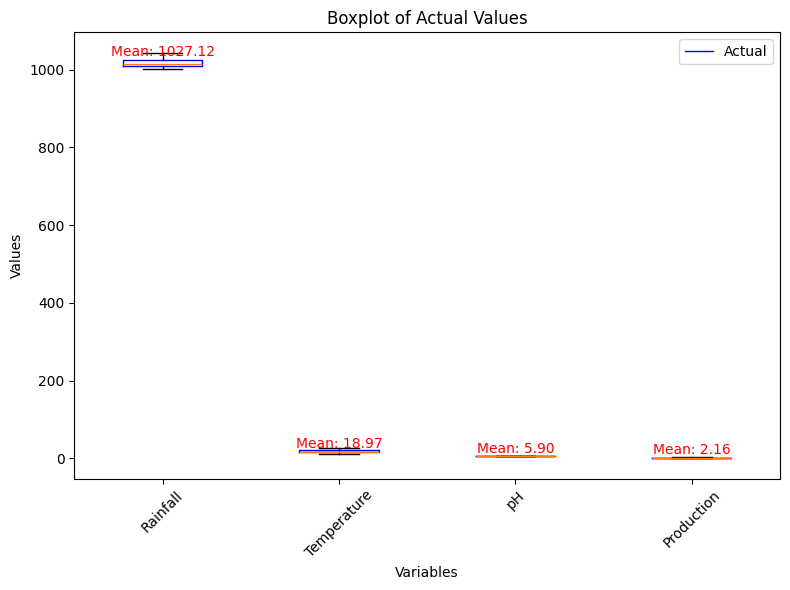

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Print all column names for debugging
print("All Columns:", data.columns)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    'Actual_Rainfall',
    'Actual_Temperature',
    'Actual_pH',
    'Actual_Production'
]

# Create boxplots for the actual values of all variables
plt.figure(figsize=(8, 6))

# Check if columns exist before trying to access them
data_to_plot_actual = []

for col in variable_names:
    if col in all_columns:
        data_to_plot_actual.append(data[col])
    else:
        print(f"Column '{col}' not found.")

# Define box properties for actual
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=positions, boxprops=boxprops_actual)

# Display variable names on the x-axis
plt.xticks(positions, [col.split('_')[1] for col in variable_names], rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos, mean_val + 0.1, f'Mean: {mean_val:.2f}', ha='center', va='bottom', color='red')

# Add legend for "Actual"
plt.legend(['Actual'], loc='upper right')

plt.title("Boxplot of Actual Values")
plt.xlabel("Variables")
plt.ylabel("Values")

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Predicted_Rainfall', 'Actual_Temperature',
       'Predicted_Temperature', 'Actual_pH', 'Predicted_pH',
       'Actual_Production', 'Predicted_Production'],
      dtype='object')
Column 'Predicted_Actual_Rainfall' not found.
Column 'Predicted_Actual_Temperature' not found.
Column 'Predicted_Actual_pH' not found.
Column 'Predicted_Actual_Production' not found.


ValueError: List of boxplot statistics and `positions` values must have same the length

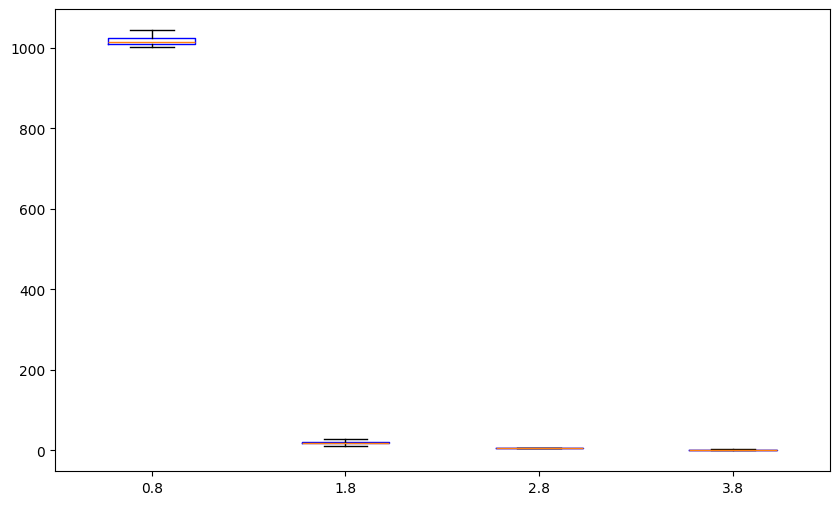

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Print all column names for debugging
print("All Columns:", data.columns)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    'Actual_Rainfall',
    'Actual_Temperature',
    'Actual_pH',
    'Actual_Production'
]

# Create boxplots for both actual and predicted values of all variables
plt.figure(figsize=(10, 6))

# Check if columns exist before trying to access them
data_to_plot_actual = []
data_to_plot_predicted = []

for col in variable_names:
    actual_col_name = col
    predicted_col_name = 'Predicted_' + col
    
    if actual_col_name in all_columns:
        data_to_plot_actual.append(data[actual_col_name])
    else:
        print(f"Column '{actual_col_name}' not found.")
    
    if predicted_col_name in all_columns:
        data_to_plot_predicted.append(data[predicted_col_name])
    else:
        print(f"Column '{predicted_col_name}' not found.")

# Define box properties for actual and predicted
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')
boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual and predicted values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=[pos - width/2 for pos in positions], boxprops=boxprops_actual)
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=[pos + width/2 for pos in positions], boxprops=boxprops_predicted)

# Display variable names on the x-axis
plt.xticks(positions, [col.split('_')[1] for col in variable_names], rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos - width/2, mean_val + 0.1, f'Mean: {mean_val:.2f}', ha='center', va='bottom', color='red')

# Display mean values for predicted values on top of each boxplot
mean_values_predicted = [data[col.replace("Actual_", "Predicted_")].mean() for col in variable_names]
for pos, mean_val in zip([pos + width/2 for pos in positions], mean_values_predicted):
    plt.text(pos, mean_val + 0.1, f'Mean: {mean_val:.2f}', ha='center', va='bottom', color='purple')

# Add legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.title("Boxplot of Actual and Predicted Values using UKF")
plt.xlabel("Variables")
plt.ylabel("Values")

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Predicted_Rainfall', 'Actual_Temperature',
       'Predicted_Temperature', 'Actual_pH', 'Predicted_pH',
       'Actual_Production', 'Predicted_Production'],
      dtype='object')
Column 'Predicted_Actual_Rainfall' not found.
Column 'Predicted_Actual_Temperature' not found.
Column 'Predicted_Actual_pH' not found.
Column 'Predicted_Actual_Production' not found.


ValueError: List of boxplot statistics and `positions` values must have same the length

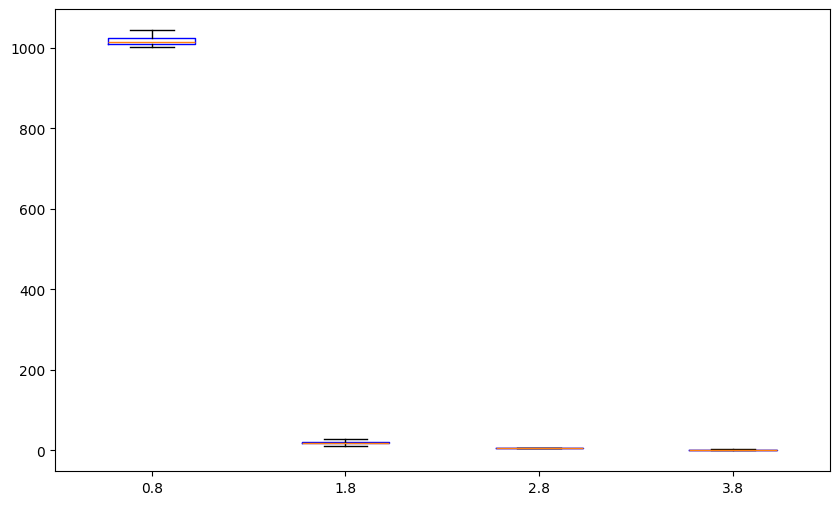

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Print all column names for debugging
print("All Columns:", data.columns)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    'Actual_Rainfall',
    'Actual_Temperature',
    'Actual_pH',
    'Actual_Production'
]

# Create boxplots for both actual and predicted values of all variables
plt.figure(figsize=(10, 6))

# Check if columns exist before trying to access them
data_to_plot_actual = []
data_to_plot_predicted = []

for col in variable_names:
    actual_col_name = col
    predicted_col_name = 'Predicted_' + col
    
    if actual_col_name in all_columns:
        data_to_plot_actual.append(data[actual_col_name])
    else:
        print(f"Column '{actual_col_name}' not found.")
    
    if predicted_col_name in all_columns:
        data_to_plot_predicted.append(data[predicted_col_name])
    else:
        print(f"Column '{predicted_col_name}' not found.")

# Define box properties for actual and predicted
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')
boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual and predicted values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=[pos - width/2 for pos in positions], boxprops=boxprops_actual)
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=[pos + width/2 for pos in positions], boxprops=boxprops_predicted)

# Display variable names on the x-axis
plt.xticks(positions, [col.split('_')[1] for col in variable_names], rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos - width/2, mean_val + 0.1, f'Mean: {mean_val:.2f}', ha='center', va='bottom', color='red')

# Display mean values for predicted values on top of each boxplot
mean_values_predicted = [data[col.replace("Actual_", "Predicted_")].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_predicted):
    plt.text(pos + width/2, mean_val + 0.1, f'Mean: {mean_val:.2f}', ha='center', va='bottom', color='purple')

# Add legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.title("Boxplot of Actual and Predicted Values using UKF")
plt.xlabel("Variables")
plt.ylabel("Values")

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Predicted_Rainfall', 'Actual_Temperature',
       'Predicted_Temperature', 'Actual_pH', 'Predicted_pH',
       'Actual_Production', 'Predicted_Production'],
      dtype='object')


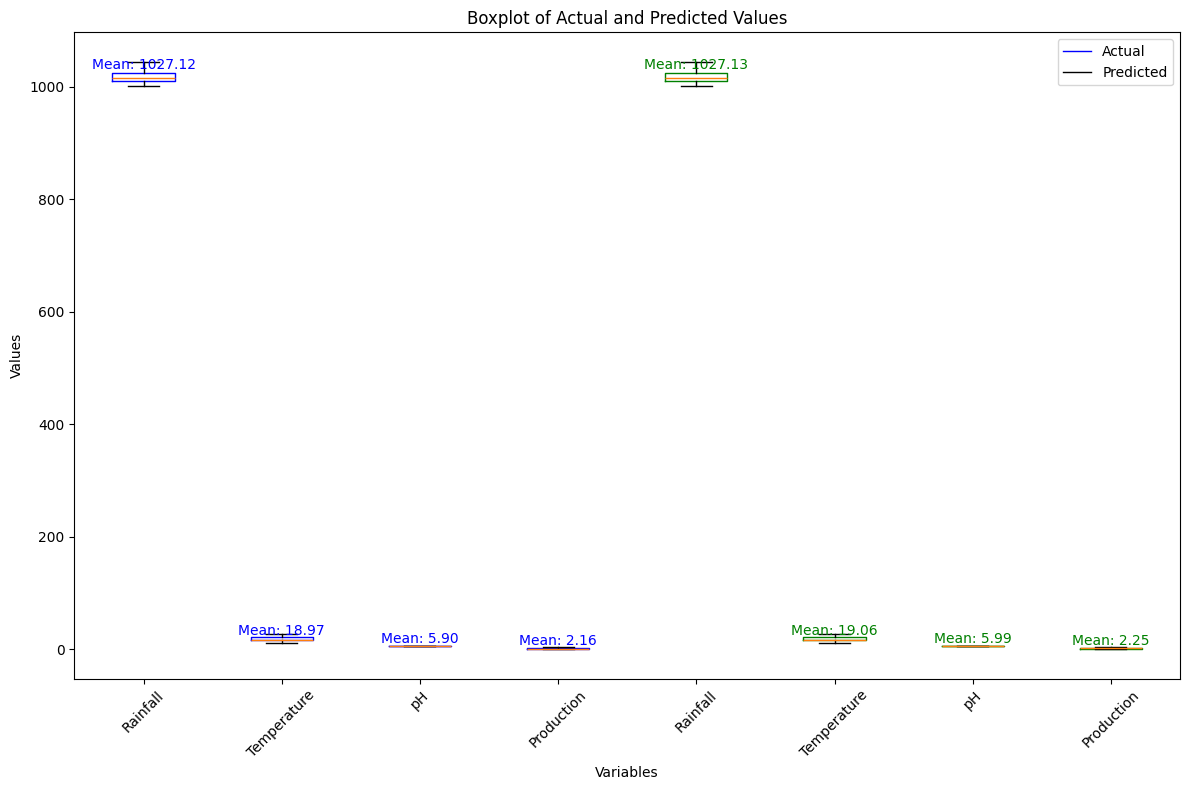

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Print all column names for debugging
print("All Columns:", data.columns)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    'Actual_Rainfall',
    'Actual_Temperature',
    'Actual_pH',
    'Actual_Production',
    'Predicted_Rainfall',  # Add the predicted variables
    'Predicted_Temperature',
    'Predicted_pH',
    'Predicted_Production'
]

# Create boxplots for the actual and predicted values of all variables
plt.figure(figsize=(12, 8))

# Check if columns exist before trying to access them
data_to_plot_actual = []
data_to_plot_predicted = []

for col in variable_names:
    if col in all_columns:
        if 'Actual' in col:
            data_to_plot_actual.append(data[col])
        elif 'Predicted' in col:
            data_to_plot_predicted.append(data[col])
    else:
        print(f"Column '{col}' not found.")

# Define box properties for actual and predicted
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')
boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')

# Calculate the positions for the boxplots
positions_actual = range(1, len(variable_names)//2 + 1)
positions_predicted = range(len(variable_names)//2 + 1, 2 * len(variable_names)//2 + 1)
width = 0.4

# Create the boxplots for actual and predicted values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=positions_actual, boxprops=boxprops_actual)
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=positions_predicted, boxprops=boxprops_predicted)

# Display variable names on the x-axis
plt.xticks(list(positions_actual) + list(positions_predicted), [col.split('_')[1] for col in variable_names], rotation=45)

# Display mean values for actual and predicted values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names if 'Actual' in col]
mean_values_predicted = [data[col].mean() for col in variable_names if 'Predicted' in col]

for pos, mean_val in zip(positions_actual, mean_values_actual):
    plt.text(pos, mean_val + 0.1, f'Mean: {mean_val:.2f}', ha='center', va='bottom', color='blue')

for pos, mean_val in zip(positions_predicted, mean_values_predicted):
    plt.text(pos, mean_val + 0.1, f'Mean: {mean_val:.2f}', ha='center', va='bottom', color='green')

# Add legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.title("Boxplot of Actual and Predicted Values")
plt.xlabel("Variables")
plt.ylabel("Values")

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Predicted_Rainfall', 'Actual_Temperature',
       'Predicted_Temperature', 'Actual_pH', 'Predicted_pH',
       'Actual_Production', 'Predicted_Production'],
      dtype='object')


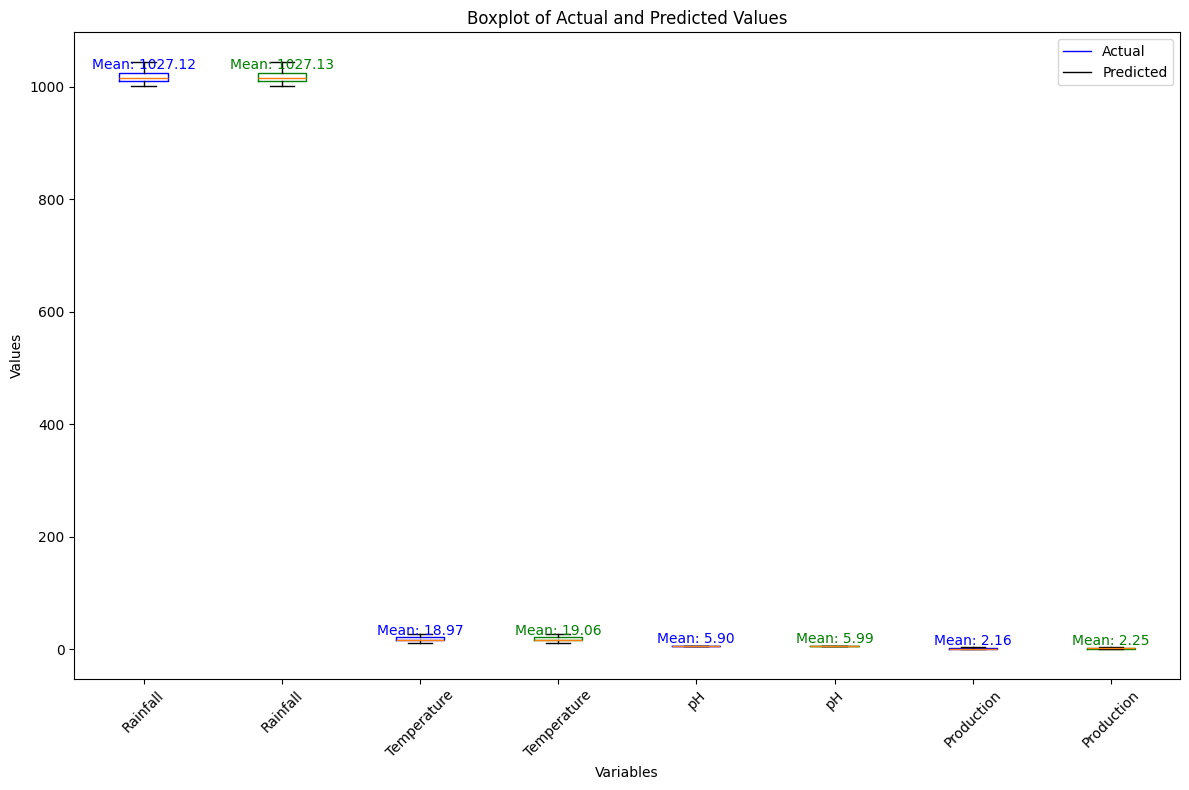

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Print all column names for debugging
print("All Columns:", data.columns)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    'Actual_Rainfall',
    'Actual_Temperature',
    'Actual_pH',
    'Actual_Production',
    'Predicted_Rainfall',  # Add the predicted variables
    'Predicted_Temperature',
    'Predicted_pH',
    'Predicted_Production'
]

# Create boxplots for the actual and predicted values of all variables
plt.figure(figsize=(12, 8))

# Check if columns exist before trying to access them
data_to_plot_actual = []
data_to_plot_predicted = []

for col in variable_names:
    if col in all_columns:
        if 'Actual' in col:
            data_to_plot_actual.append(data[col])
        elif 'Predicted' in col:
            data_to_plot_predicted.append(data[col])
    else:
        print(f"Column '{col}' not found.")

# Define box properties for actual and predicted
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')
boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')

# Calculate the positions for the boxplots
width = 0.35  # Adjust the width of the boxes
positions_actual = range(1, len(variable_names)//2 * 2 + 1, 2)
positions_predicted = range(2, len(variable_names)//2 * 2 + 2, 2)

# Create the boxplots for actual and predicted values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=positions_actual, widths=width, boxprops=boxprops_actual)
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=positions_predicted, widths=width, boxprops=boxprops_predicted)

# Display variable names on the x-axis
plt.xticks(list(positions_actual) + list(positions_predicted), [col.split('_')[1] for col in variable_names], rotation=45)

# Display mean values for actual and predicted values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names if 'Actual' in col]
mean_values_predicted = [data[col].mean() for col in variable_names if 'Predicted' in col]

for pos, mean_val in zip(positions_actual, mean_values_actual):
    plt.text(pos, mean_val + 0.1, f'Mean: {mean_val:.2f}', ha='center', va='bottom', color='blue')

for pos, mean_val in zip(positions_predicted, mean_values_predicted):
    plt.text(pos, mean_val + 0.1, f'Mean: {mean_val:.2f}', ha='center', va='bottom', color='green')

# Add legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.title("Boxplot of Actual and Predicted Values")
plt.xlabel("Variables")
plt.ylabel("Values")

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


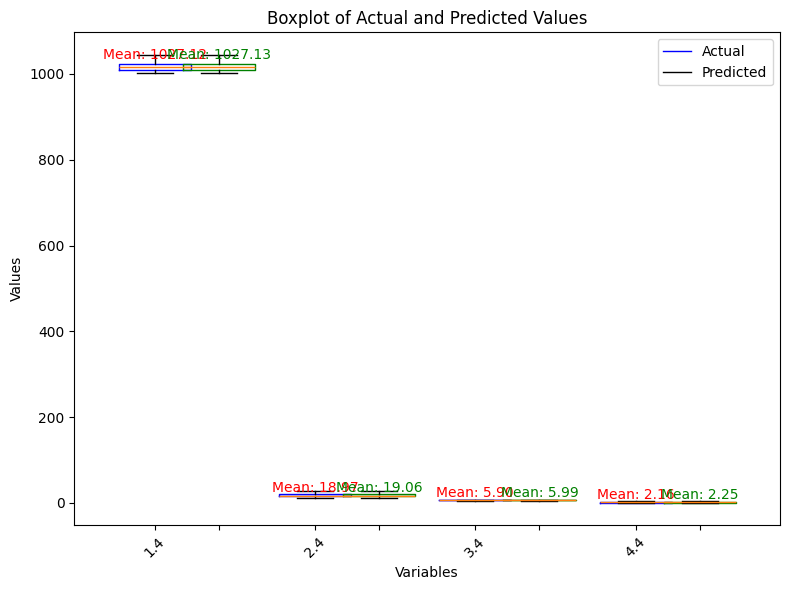

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Print all column names for debugging
print("All Columns:", data.columns)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    'Actual_Rainfall',
    'Actual_Temperature',
    'Actual_pH',
    'Actual_Production'
]

# Create boxplots for the actual values of all variables
plt.figure(figsize=(8, 6))

# Check if columns exist before trying to access them
data_to_plot_actual = []

for col in variable_names:
    if col in all_columns:
        data_to_plot_actual.append(data[col])
    else:
        print(f"Column '{col}' not found.")

# Define box properties for actual
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=positions, boxprops=boxprops_actual)

# Display variable names on the x-axis
plt.xticks(positions, [col.split('_')[1] for col in variable_names], rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos, mean_val + 0.1, f'Mean: {mean_val:.2f}', ha='center', va='bottom', color='red')

# Add legend for "Actual"
plt.legend(['Actual'], loc='upper right')

# Add legend for "Predicted"
# Assuming you have columns like 'Predicted_Rainfall', 'Predicted_Temperature', etc.
variable_names_predicted = ['Predicted_' + col.split('_')[1] for col in variable_names]
data_to_plot_predicted = [data[col] for col in variable_names_predicted]

boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=[pos + width for pos in positions], boxprops=boxprops_predicted)

mean_values_predicted = [data[col].mean() for col in variable_names_predicted]
for pos, mean_val in zip(positions, mean_values_predicted):
    plt.text(pos + width, mean_val + 0.1, f'Mean: {mean_val:.2f}', ha='center', va='bottom', color='green')

plt.legend(['Actual', 'Predicted'], loc='upper right')  # Add legend for "Predicted"

plt.title("Boxplot of Actual and Predicted Values")
plt.xlabel("Variables")
plt.ylabel("Values")

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


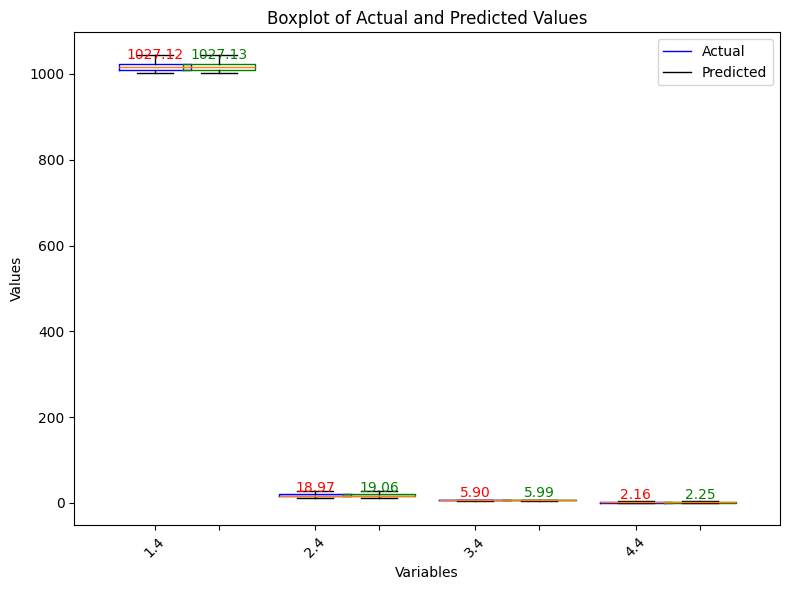

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Print all column names for debugging
print("All Columns:", data.columns)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    'Actual_Rainfall',
    'Actual_Temperature',
    'Actual_pH',
    'Actual_Production'
]

# Create boxplots for the actual values of all variables
plt.figure(figsize=(8, 6))

# Check if columns exist before trying to access them
data_to_plot_actual = []

for col in variable_names:
    if col in all_columns:
        data_to_plot_actual.append(data[col])
    else:
        print(f"Column '{col}' not found.")

# Define box properties for actual
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=positions, boxprops=boxprops_actual)

# Display variable names on the x-axis
plt.xticks(positions, [col.split('_')[1] for col in variable_names], rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='red')

# Add legend for "Actual"
plt.legend(['Actual'], loc='upper right')

# Add legend for "Predicted"
# Assuming you have columns like 'Predicted_Rainfall', 'Predicted_Temperature', etc.
variable_names_predicted = ['Predicted_' + col.split('_')[1] for col in variable_names]
data_to_plot_predicted = [data[col] for col in variable_names_predicted]

boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=[pos + width for pos in positions], boxprops=boxprops_predicted)

mean_values_predicted = [data[col].mean() for col in variable_names_predicted]
for pos, mean_val in zip(positions, mean_values_predicted):
    plt.text(pos + width, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='green')

plt.legend(['Actual', 'Predicted'], loc='upper right')  # Add legend for "Predicted"

plt.title("Boxplot of Actual and Predicted Values")
plt.xlabel("Variables")
plt.ylabel("Values")

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


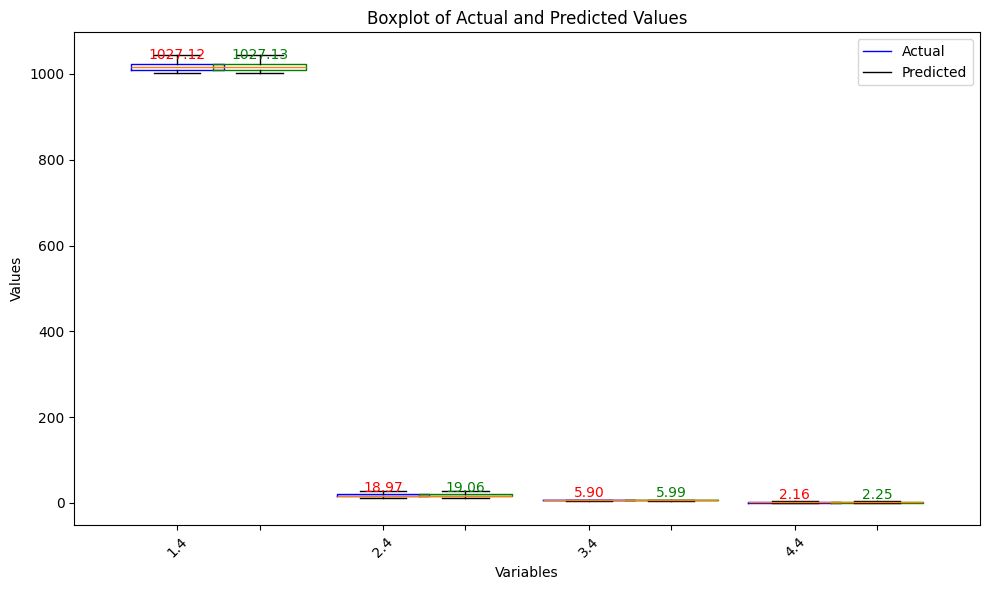

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Print all column names for debugging
print("All Columns:", data.columns)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    'Actual_Rainfall',
    'Actual_Temperature',
    'Actual_pH',
    'Actual_Production'
]

# Create boxplots for the actual values of all variables
plt.figure(figsize=(10, 6))

# Check if columns exist before trying to access them
data_to_plot_actual = []

for col in variable_names:
    if col in all_columns:
        data_to_plot_actual.append(data[col])
    else:
        print(f"Column '{col}' not found.")

# Define box properties for actual
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=positions, boxprops=boxprops_actual)

# Display variable names on the x-axis
plt.xticks(positions, [col.split('_')[1] for col in variable_names], rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='red')

# Add legend for "Actual"
plt.legend(['Actual'], loc='upper right')

# Add boxplots and mean values for predicted values
# Assuming column names like 'Predicted_Rainfall', 'Predicted_Temperature', etc.
variable_names_predicted = ['Predicted_' + col.split('_')[1] for col in variable_names]
data_to_plot_predicted = [data[col] for col in variable_names_predicted]

boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=[pos + width for pos in positions], boxprops=boxprops_predicted)

mean_values_predicted = [data[col].mean() for col in variable_names_predicted]
for pos, mean_val in zip(positions, mean_values_predicted):
    plt.text(pos + width, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='green')

# Add legend for "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.title("Boxplot of Actual and Predicted Values")
plt.xlabel("Variables")
plt.ylabel("Values")

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


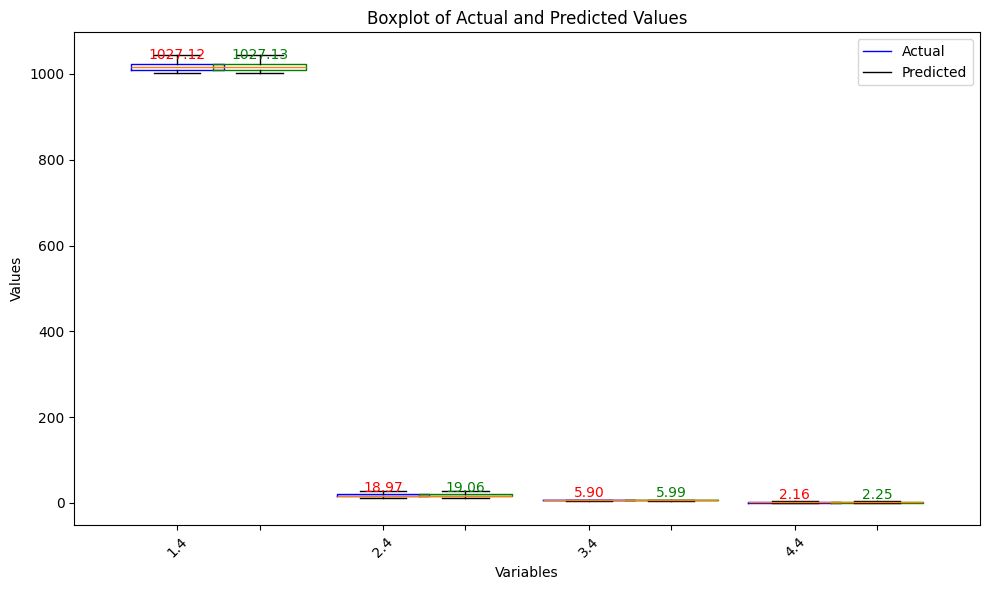

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Print all column names for debugging
print("All Columns:", data.columns)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    'Actual_Rainfall',
    'Actual_Temperature',
    'Actual_pH',
    'Actual_Production'
]

# Create boxplots for the actual values of all variables
plt.figure(figsize=(10, 6))

# Check if columns exist before trying to access them
data_to_plot_actual = []

for col in variable_names:
    if col in all_columns:
        data_to_plot_actual.append(data[col])
    else:
        print(f"Column '{col}' not found.")

# Define box properties for actual
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')

# Calculate the positions for the boxplots
positions_actual = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=positions_actual, boxprops=boxprops_actual)

# Display variable names on the x-axis
plt.xticks(positions_actual, [col.split('_')[1] for col in variable_names], rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions_actual, mean_values_actual):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='red')

# Add legend for "Actual"
plt.legend(['Actual'], loc='upper right')

# Add boxplots and mean values for predicted values
# Assuming column names like 'Predicted_Rainfall', 'Predicted_Temperature', etc.
variable_names_predicted = ['Predicted_' + col.split('_')[1] for col in variable_names]
data_to_plot_predicted = [data[col] for col in variable_names_predicted]

boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')
positions_predicted = [pos + width for pos in positions_actual]
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=positions_predicted, boxprops=boxprops_predicted)

mean_values_predicted = [data[col].mean() for col in variable_names_predicted]
for pos, mean_val in zip(positions_predicted, mean_values_predicted):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='green')

# Add legend for "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.title("Boxplot of Actual and Predicted Values")
plt.xlabel("Variables")
plt.ylabel("Values")

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


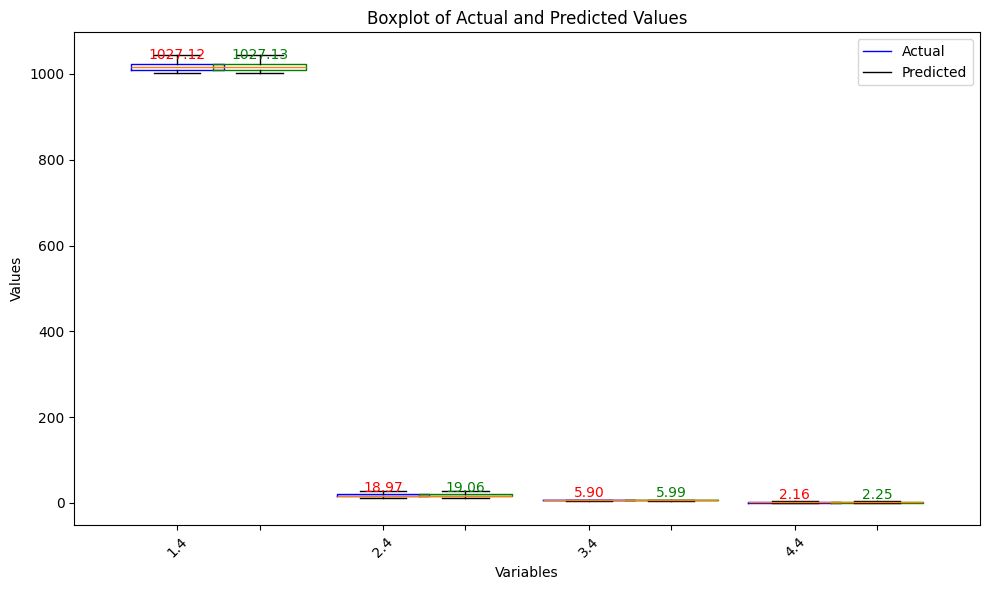

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Print all column names for debugging
print("All Columns:", data.columns)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    'Actual_Rainfall',
    'Actual_Temperature',
    'Actual_pH',
    'Actual_Production'
]

# Create boxplots for the actual values of all variables
plt.figure(figsize=(10, 6))

# Check if columns exist before trying to access them
data_to_plot_actual = []

for col in variable_names:
    if col in all_columns:
        data_to_plot_actual.append(data[col])
    else:
        print(f"Column '{col}' not found.")

# Define box properties for actual
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')

# Calculate the positions for the boxplots
positions_actual = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=positions_actual, boxprops=boxprops_actual)

# Display variable names on the x-axis
variable_labels = ['Rainfall', 'Temperature', 'pH', 'Production']
plt.xticks(positions_actual, variable_labels, rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions_actual, mean_values_actual):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='red')

# Add legend for "Actual"
plt.legend(['Actual'], loc='upper right')

# Add boxplots and mean values for predicted values
# Assuming column names like 'Predicted_Rainfall', 'Predicted_Temperature', etc.
variable_names_predicted = ['Predicted_' + col.split('_')[1] for col in variable_names]
data_to_plot_predicted = [data[col] for col in variable_names_predicted]

boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')
positions_predicted = [pos + width for pos in positions_actual]
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=positions_predicted, boxprops=boxprops_predicted)

mean_values_predicted = [data[col].mean() for col in variable_names_predicted]
for pos, mean_val in zip(positions_predicted, mean_values_predicted):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='green')

# Add legend for "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.title("Boxplot of Actual and Predicted Values")
plt.xlabel("Variables")
plt.ylabel("Values")

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


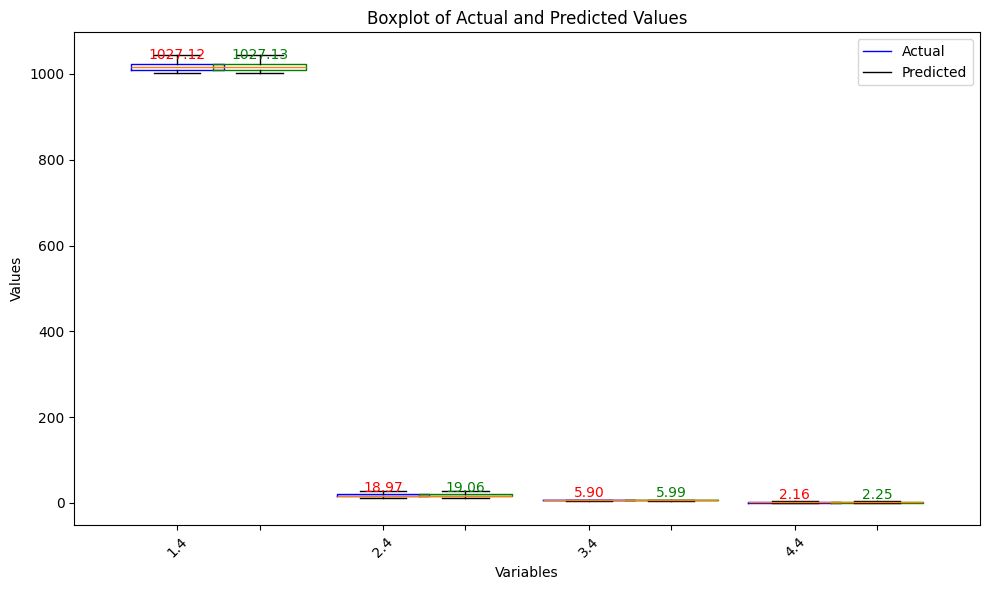

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Print all column names for debugging
print("All Columns:", data.columns)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    'Actual_Rainfall',
    'Actual_Temperature',
    'Actual_pH',
    'Actual_Production'
]

# Create boxplots for the actual values of all variables
plt.figure(figsize=(10, 6))

# Check if columns exist before trying to access them
data_to_plot_actual = []

for col in variable_names:
    if col in all_columns:
        data_to_plot_actual.append(data[col])
    else:
        print(f"Column '{col}' not found.")

# Define box properties for actual
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')

# Calculate the positions for the boxplots
positions_actual = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=positions_actual, boxprops=boxprops_actual)

# Display variable names on the x-axis
variable_labels = ['Rainfall', 'Temperature', 'pH', 'Production']
plt.xticks(positions_actual, variable_labels, rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions_actual, mean_values_actual):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='red')

# Add boxplots and mean values for predicted values
# Assuming column names like 'Predicted_Rainfall', 'Predicted_Temperature', etc.
variable_names_predicted = ['Predicted_' + col.split('_')[1] for col in variable_names]
data_to_plot_predicted = [data[col] for col in variable_names_predicted]

boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')
positions_predicted = [pos + width for pos in positions_actual]
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=positions_predicted, boxprops=boxprops_predicted)

mean_values_predicted = [data[col].mean() for col in variable_names_predicted]
for pos, mean_val in zip(positions_predicted, mean_values_predicted):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='green')

# Add legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.title("Boxplot of Actual and Predicted Values")
plt.xlabel("Variables")
plt.ylabel("Values")

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


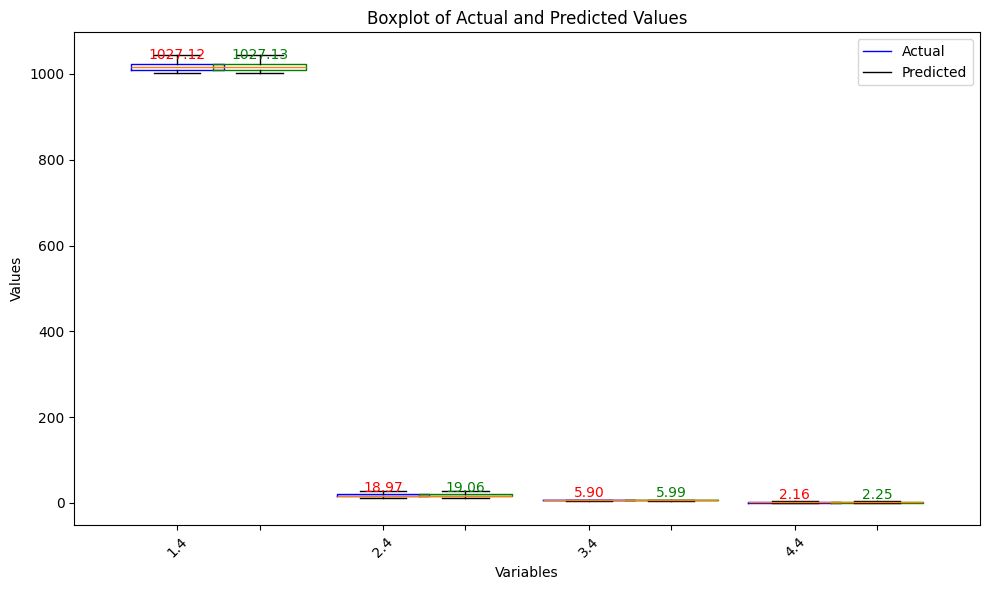

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Print all column names for debugging
print("All Columns:", data.columns)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    'Actual_Rainfall',
    'Actual_Temperature',
    'Actual_pH',
    'Actual_Production'
]

# Create boxplots for the actual values of all variables
plt.figure(figsize=(10, 6))

# Check if columns exist before trying to access them
data_to_plot_actual = []

for col in variable_names:
    if col in all_columns:
        data_to_plot_actual.append(data[col])
    else:
        print(f"Column '{col}' not found.")

# Define box properties for actual
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=positions, boxprops=boxprops_actual)

# Display variable names on the x-axis
variable_labels = ['Rainfall', 'Temperature', 'pH', 'Production']
plt.xticks(positions, variable_labels, rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='red')

# Add boxplots and mean values for predicted values
# Assuming column names like 'Predicted_Rainfall', 'Predicted_Temperature', etc.
variable_names_predicted = ['Predicted_' + col.split('_')[1] for col in variable_names]
data_to_plot_predicted = [data[col] for col in variable_names_predicted]

boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')
positions_predicted = [pos + width for pos in positions]
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=positions_predicted, boxprops=boxprops_predicted)

mean_values_predicted = [data[col].mean() for col in variable_names_predicted]
for pos, mean_val in zip(positions_predicted, mean_values_predicted):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='green')

# Add legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.title("Boxplot of Actual and Predicted Values")
plt.xlabel("Variables")
plt.ylabel("Values")

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


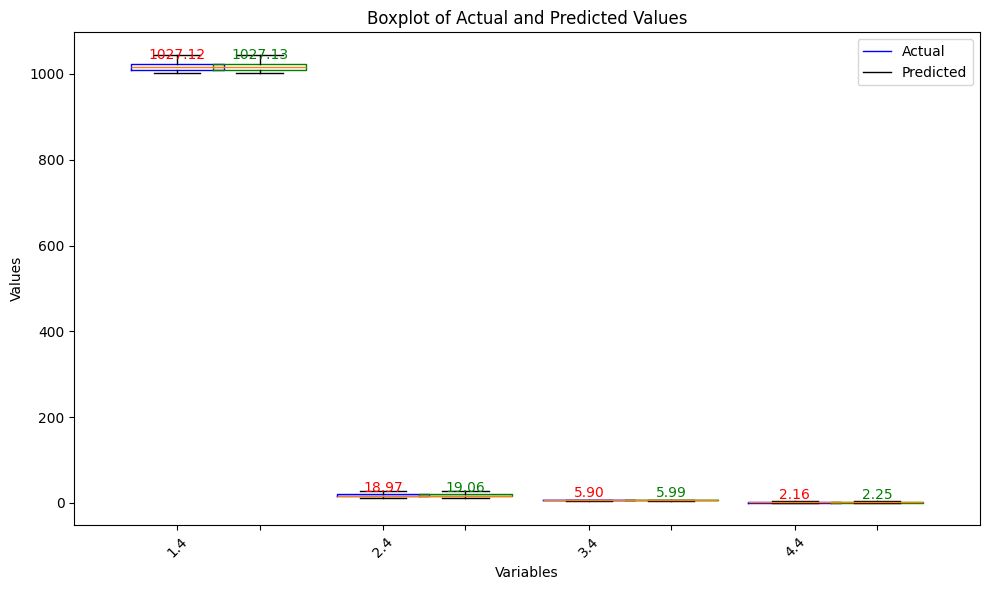

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Print all column names for debugging
print("All Columns:", data.columns)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    'Actual_Rainfall',
    'Actual_Temperature',
    'Actual_pH',
    'Actual_Production'
]

# Create boxplots for the actual values of all variables
plt.figure(figsize=(10, 6))

# Check if columns exist before trying to access them
data_to_plot_actual = []

for col in variable_names:
    if col in all_columns:
        data_to_plot_actual.append(data[col])
    else:
        print(f"Column '{col}' not found.")

# Define box properties for actual
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=positions, boxprops=boxprops_actual)

# Display variable names on the x-axis
variable_labels = ['Rainfall', 'Temperature', 'pH', 'Production']
plt.xticks(positions, variable_labels, rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='red')

# Add boxplots and mean values for predicted values
# Assuming column names like 'Predicted_Rainfall', 'Predicted_Temperature', etc.
variable_names_predicted = ['Predicted_' + col.split('_')[1] for col in variable_names]
data_to_plot_predicted = [data[col] for col in variable_names_predicted]

boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')
positions_predicted = [pos + width for pos in positions]
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=positions_predicted, boxprops=boxprops_predicted)

mean_values_predicted = [data[col].mean() for col in variable_names_predicted]
for pos, mean_val in zip(positions_predicted, mean_values_predicted):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='green')

# Add legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.title("Boxplot of Actual and Predicted Values")
plt.xlabel("Variables")
plt.ylabel("Values")

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

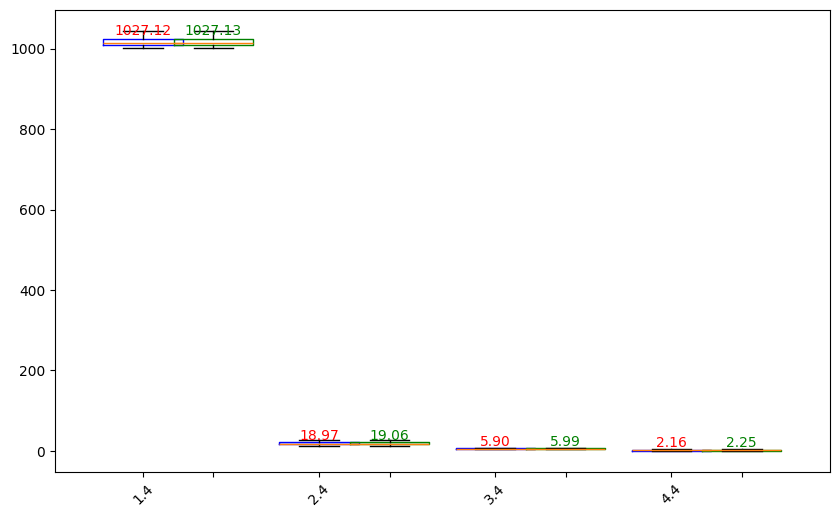

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"  # Update the file path
data = pd.read_excel(file_path)

# Print all column names for debugging
print("All Columns:", data.columns)

# Extract all column names
all_columns = data.columns

# Define the variable names without prefixes
variable_names = [
    'Actual_Rainfall',
    'Actual_Temperature',
    'Actual_pH',
    'Actual_Production'
]

# Check for NaN values in the dataset
if data.isna().sum().any():
    print("Warning: There are missing values in the dataset. Handle them appropriately.")

# Create boxplots for the actual values of all variables
plt.figure(figsize=(10, 6))

# Check if columns exist before trying to access them
data_to_plot_actual = []

for col in variable_names:
    if col in all_columns:
        data_to_plot_actual.append(data[col])
    else:
        print(f"Column '{col}' not found.")

# Define box properties for actual
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=positions, boxprops=boxprops_actual)

# Display variable names on the x-axis
variable_labels = ['Rainfall', 'Temperature', 'pH', 'Production']
plt.xticks(positions, variable_labels, rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='red')

# Add boxplots and mean values for predicted values
# Assuming column names like 'Predicted_Rainfall', 'Predicted_Temperature', etc.
variable_names_predicted = ['Predicted_' + col.split('_')[1] for col in variable_names]
data_to_plot_predicted = [data[col] for col in variable_names_predicted]

boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')
positions_predicted = [pos + width for pos in positions]
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=positions_predicted, boxprops=boxprops_predicted)

mean_values_predicted = [data[col].mean() for col in variable_names_predicted]
for pos, mean_val in zip(positions_predicted, mean_values_predicted):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='green')

# Display variable names above the boxplots
for pos, variable_label in zip(positions, variable_labels):
    plt.text(pos, max(data_to_plot_actual + data_to_plot_predicted) + 1, variable_label, ha='center', va='bottom', color='black')

# Adjust the y-axis limit to make room for variable names
plt.ylim(bottom=None, top=max(data_to_plot_actual + data_to_plot_predicted) + 2)

# Add legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.title("Boxplot of Actual and Predicted Values")
plt.xlabel("Variables")
plt.ylabel("Values")

plt.tight_layout()
plt.show()


All Columns: Index(['Actual_Rainfall', 'Actual_Temperature', 'Actual_pH',
       'Actual_Production', 'Predicted_Rainfall', 'Predicted_Temperature',
       'Predicted_pH', 'Predicted_Production'],
      dtype='object')


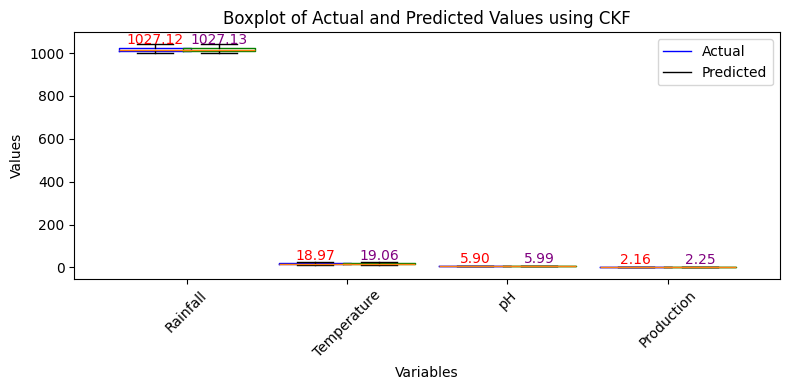

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/Attempts/sckf.xlsx"
data = pd.read_excel(file_path)

# Extract all column names
all_columns = data.columns

# List of variable names with the prefix "Actual_"
variable_names = [col for col in all_columns if col.startswith("Actual_")]

# Remove the prefix from variable names
variable_names_without_prefix = [col.replace("Actual_", "") for col in variable_names]

# Print column names for debugging
print("All Columns:", all_columns)

# Create boxplots for the actual and predicted values of all variables
plt.figure(figsize=(8, 4))

# Check if 'Predicted_' columns exist before trying to access them
data_to_plot_actual = []  # Corrected variable name
data_to_plot_predicted = []

for col in variable_names:
    actual_col_name = col  # No need to replace the prefix for actual values
    predicted_col_name = col.replace("Actual_", "Predicted_")
    
    if actual_col_name in all_columns:
        data_to_plot_actual.append(data[actual_col_name])  # Append actual data
    else:
        print(f"Column '{actual_col_name}' not found.")
    
    if predicted_col_name in all_columns:
        data_to_plot_predicted.append(data[predicted_col_name])
    else:
        print(f"Column '{predicted_col_name}' not found.")

# Define box properties for actual and predicted
boxprops_actual = dict(linestyle='-', linewidth=1, color='blue')
boxprops_predicted = dict(linestyle='-', linewidth=1, color='green')

# Calculate the positions for the boxplots
positions = range(1, len(variable_names) + 1)
width = 0.4

# Create the boxplots for actual and predicted values
box_actual = plt.boxplot(data_to_plot_actual, showfliers=False, positions=[pos - width/2 for pos in positions], boxprops=boxprops_actual)
box_predicted = plt.boxplot(data_to_plot_predicted, showfliers=False, positions=[pos + width/2 for pos in positions], boxprops=boxprops_predicted)

# Display variable names without prefix on the x-axis
plt.xticks(positions, variable_names_without_prefix, rotation=45)

# Display mean values for actual values on top of each boxplot
mean_values_actual = [data[col].mean() for col in variable_names]
for pos, mean_val in zip(positions, mean_values_actual):
    plt.text(pos - width/2, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='red')

# Display mean values for predicted values on top of each boxplot
mean_values_predicted = [data[col.replace("Actual_", "Predicted_")].mean() for col in variable_names]
for pos, mean_val in zip([pos + width/2 for pos in positions], mean_values_predicted):
    plt.text(pos, mean_val + 0.1, f'{mean_val:.2f}', ha='center', va='bottom', color='purple')

plt.title("Boxplot of Actual and Predicted Values using CKF")
plt.xlabel("Variables")
plt.ylabel("Values")

# Create a single legend for "Actual" and "Predicted"
plt.legend(['Actual', 'Predicted'], loc='upper right')

plt.tight_layout()
plt.show()


Memory usage of initial_covariance: 256 bytes
Memory usage of measurement_noise_covariance: 256 bytes
Memory usage of process_noise_covariance: 256 bytes
Memory usage of 'data' DataFrame: 48900 bytes
Memory usage of 'predicted_data' DataFrame: 48900 bytes


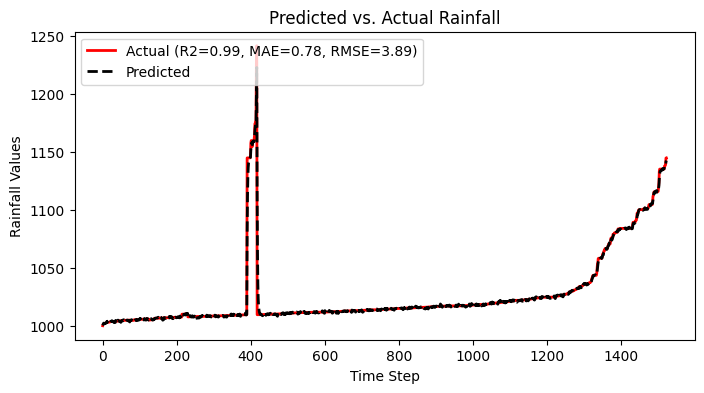

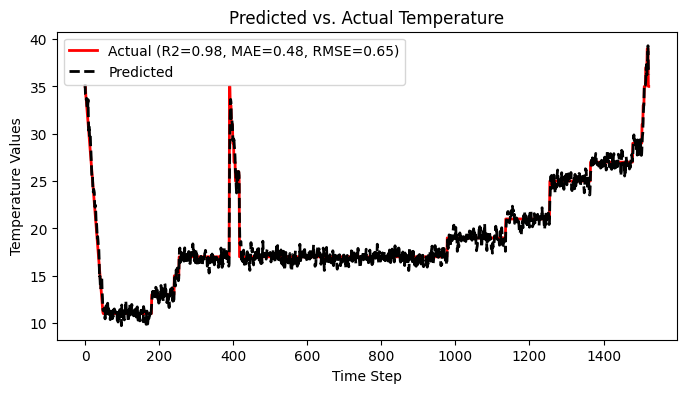

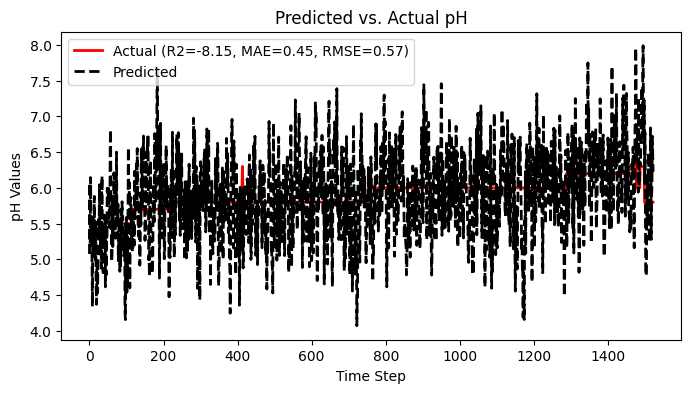

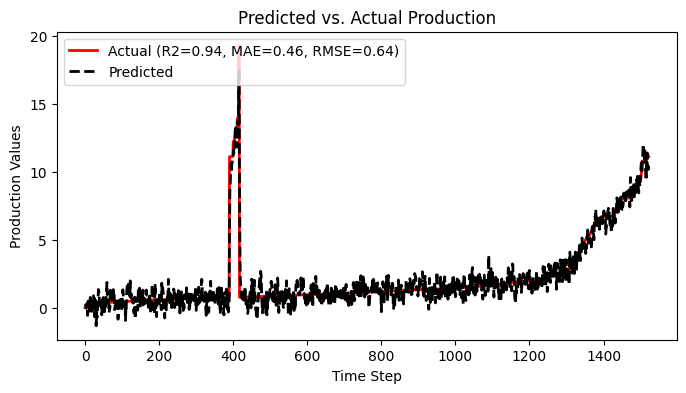

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import sys

# Define the process model (you need to provide this function)
def process_model(state, process_noise_covariance):
    # Implement the process model equations
    # Example: state prediction and covariance update
    # You need to adapt this based on your specific application
    predicted_state = state  # For simplicity, we assume no change
    predicted_covariance = process_noise_covariance  # Process noise covariance

    return predicted_state, predicted_covariance

# Define the measurement model (you need to provide this function)
def measurement_model(true_measurement, measurement_noise_covariance):
    # Simulate noisy measurements by adding random noise
    noisy_measurement = true_measurement + np.random.normal(0, np.sqrt(measurement_noise_covariance))
    return noisy_measurement

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/soil.xlsx"
data = pd.read_excel(file_path)  # Assumes the data is in a sheet in the Excel file

# Define the selected columns (variables) you want to apply the Kalman filter to
selected_columns = ['Rainfall', 'Temperature', 'pH', 'Production']

# Number of time steps
num_time_steps = len(data)

# Initialize the initial covariance matrix (you need to specify this)
initial_covariance = np.eye(len(selected_columns))  # Example: Identity matrix

# Initialize the measurement noise covariance (you need to specify this)
measurement_noise_covariance = np.eye(len(selected_columns))  # Example: Identity matrix

# Initialize the process noise covariance (you need to specify this)
process_noise_covariance = np.eye(len(selected_columns))  # Example: Identity matrix

# Initialize a dictionary to store predicted measurements for each variable
predicted_measurements = {col: [] for col in selected_columns}

# Create a DataFrame to store the predicted data
predicted_data = data[selected_columns].copy()

# Set Jupyter Notebook to display the plots inline
%matplotlib inline

# Memory computation for specific variables
memory_usage_initial_covariance = sys.getsizeof(initial_covariance)
memory_usage_measurement_noise = sys.getsizeof(measurement_noise_covariance)
memory_usage_process_noise = sys.getsizeof(process_noise_covariance)
memory_usage_data = sys.getsizeof(data)
memory_usage_predicted_data = sys.getsizeof(predicted_data)

print(f"Memory usage of initial_covariance: {memory_usage_initial_covariance} bytes")
print(f"Memory usage of measurement_noise_covariance: {memory_usage_measurement_noise} bytes")
print(f"Memory usage of process_noise_covariance: {memory_usage_process_noise} bytes")
print(f"Memory usage of 'data' DataFrame: {memory_usage_data} bytes")
print(f"Memory usage of 'predicted_data' DataFrame: {memory_usage_predicted_data} bytes")

for i, col in enumerate(selected_columns):
    # Initialize state and covariance for the current variable
    current_state = data[col].values[0]
    current_covariance = initial_covariance[i, i]

    # Lists to store the current variable's predicted and actual measurements
    predicted_col_values = []

    for t in range(num_time_steps):
        # Simulate measurements using the measurement model
        true_measurement = data[col].values[t]
        noisy_measurement = measurement_model(true_measurement, measurement_noise_covariance[i, i])

        # Use the process model to predict the state
        predicted_state, predicted_covariance = process_model(current_state, process_noise_covariance[i, i])

        # Kalman gain calculation
        kalman_gain = predicted_covariance / (predicted_covariance + measurement_noise_covariance[i, i])

        # Update state
        current_state = predicted_state + kalman_gain * (noisy_measurement - predicted_state)
        current_covariance = (1 - kalman_gain) * predicted_covariance

        # Append predicted measurements to the list
        predicted_col_values.append(current_state)

    # Assign the predicted values to the DataFrame
    predicted_data[col] = predicted_col_values

    # Calculate evaluation metrics: R-squared (R2), MAE, RMSE
    r2 = r2_score(data[col], predicted_col_values)
    mae = mean_absolute_error(data[col], predicted_col_values)
    rmse = np.sqrt(mean_squared_error(data[col], predicted_col_values))

    # Create plots with legend including evaluation metrics
    plt.figure(figsize=(8, 4))
    plt.plot(data.index, data[col], label=f'Actual (R2={r2:.2f}, MAE={mae:.2f}, RMSE={rmse:.2f})', linewidth=2, color='red')
    plt.plot(data.index, predicted_data[col], linestyle='--', linewidth=2, color='black', label='Predicted')
    plt.title(f'Predicted vs. Actual {col}')
    plt.xlabel('Time Step')
    plt.ylabel(f'{col} Values')
    plt.grid(False)
    plt.legend(loc='upper left')
    plt.show()


Memory usage of initial_covariance: 256 bytes
Memory usage of measurement_noise_covariance: 256 bytes
Memory usage of process_noise_covariance: 256 bytes
Memory usage of 'data' DataFrame: 48900 bytes
Memory usage of 'predicted_data' DataFrame: 48900 bytes


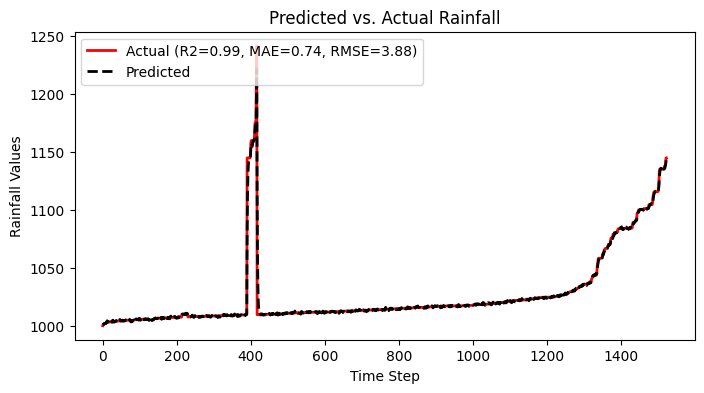

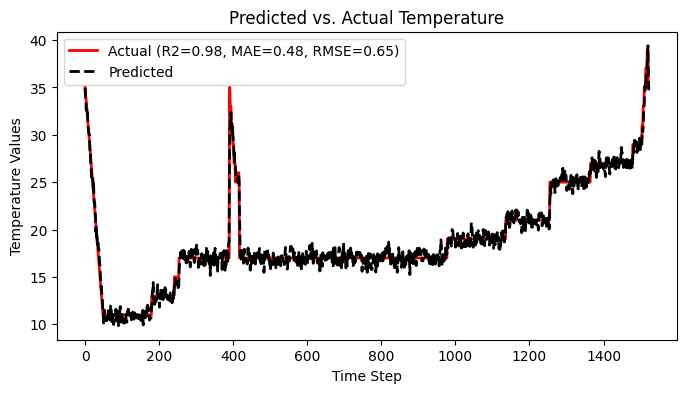

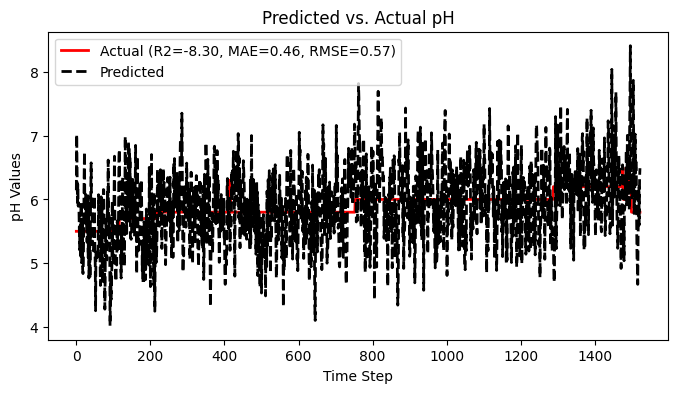

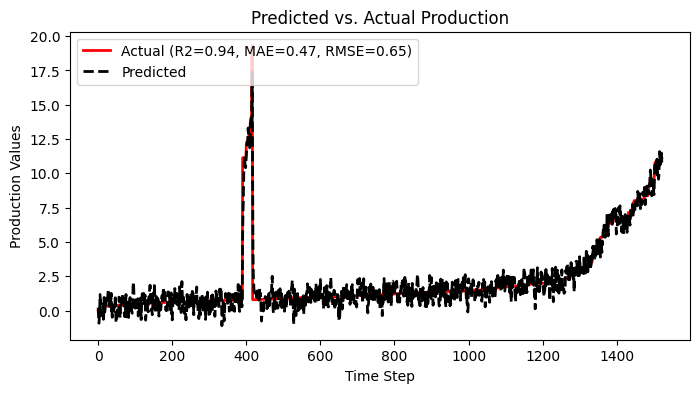

Total computation memory estimated: 98568 bytes


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import sys

# Define the process model (you need to provide this function)
def process_model(state, process_noise_covariance):
    # Implement the process model equations
    # Example: state prediction and covariance update
    # You need to adapt this based on your specific application
    predicted_state = state  # For simplicity, we assume no change
    predicted_covariance = process_noise_covariance  # Process noise covariance

    return predicted_state, predicted_covariance

# Define the measurement model (you need to provide this function)
def measurement_model(true_measurement, measurement_noise_covariance):
    # Simulate noisy measurements by adding random noise
    noisy_measurement = true_measurement + np.random.normal(0, np.sqrt(measurement_noise_covariance))
    return noisy_measurement

# Load your data from the Excel file
file_path = "/Users/egasarmando/Desktop/soil.xlsx"
data = pd.read_excel(file_path)  # Assumes the data is in a sheet in the Excel file

# Define the selected columns (variables) you want to apply the Kalman filter to
selected_columns = ['Rainfall', 'Temperature', 'pH', 'Production']

# Number of time steps
num_time_steps = len(data)

# Initialize the initial covariance matrix (you need to specify this)
initial_covariance = np.eye(len(selected_columns))  # Example: Identity matrix

# Initialize the measurement noise covariance (you need to specify this)
measurement_noise_covariance = np.eye(len(selected_columns))  # Example: Identity matrix

# Initialize the process noise covariance (you need to specify this)
process_noise_covariance = np.eye(len(selected_columns))  # Example: Identity matrix

# Initialize a dictionary to store predicted measurements for each variable
predicted_measurements = {col: [] for col in selected_columns}

# Create a DataFrame to store the predicted data
predicted_data = data[selected_columns].copy()

# Set Jupyter Notebook to display the plots inline
%matplotlib inline

# Memory computation for specific variables
memory_usage_initial_covariance = sys.getsizeof(initial_covariance)
memory_usage_measurement_noise = sys.getsizeof(measurement_noise_covariance)
memory_usage_process_noise = sys.getsizeof(process_noise_covariance)
memory_usage_data = sys.getsizeof(data)
memory_usage_predicted_data = sys.getsizeof(predicted_data)

print(f"Memory usage of initial_covariance: {memory_usage_initial_covariance} bytes")
print(f"Memory usage of measurement_noise_covariance: {memory_usage_measurement_noise} bytes")
print(f"Memory usage of process_noise_covariance: {memory_usage_process_noise} bytes")
print(f"Memory usage of 'data' DataFrame: {memory_usage_data} bytes")
print(f"Memory usage of 'predicted_data' DataFrame: {memory_usage_predicted_data} bytes")

for i, col in enumerate(selected_columns):
    # Initialize state and covariance for the current variable
    current_state = data[col].values[0]
    current_covariance = initial_covariance[i, i]

    # Lists to store the current variable's predicted and actual measurements
    predicted_col_values = []

    for t in range(num_time_steps):
        # Simulate measurements using the measurement model
        true_measurement = data[col].values[t]
        noisy_measurement = measurement_model(true_measurement, measurement_noise_covariance[i, i])

        # Use the process model to predict the state
        predicted_state, predicted_covariance = process_model(current_state, process_noise_covariance[i, i])

        # Kalman gain calculation
        kalman_gain = predicted_covariance / (predicted_covariance + measurement_noise_covariance[i, i])

        # Update state
        current_state = predicted_state + kalman_gain * (noisy_measurement - predicted_state)
        current_covariance = (1 - kalman_gain) * predicted_covariance

        # Append predicted measurements to the list
        predicted_col_values.append(current_state)

    # Assign the predicted values to the DataFrame
    predicted_data[col] = predicted_col_values

    # Calculate evaluation metrics: R-squared (R2), MAE, RMSE
    r2 = r2_score(data[col], predicted_col_values)
    mae = mean_absolute_error(data[col], predicted_col_values)
    rmse = np.sqrt(mean_squared_error(data[col], predicted_col_values))

    # Create plots with legend including evaluation metrics
    plt.figure(figsize=(8, 4))
    plt.plot(data.index, data[col], label=f'Actual (R2={r2:.2f}, MAE={mae:.2f}, RMSE={rmse:.2f})', linewidth=2, color='red')
    plt.plot(data.index, predicted_data[col], linestyle='--', linewidth=2, color='black', label='Predicted')
    plt.title(f'Predicted vs. Actual {col}')
    plt.xlabel('Time Step')
    plt.ylabel(f'{col} Values')
    plt.grid(False)
    plt.legend(loc='upper left')
    plt.show()

# Total memory computation
total_memory = (
    memory_usage_initial_covariance +
    memory_usage_measurement_noise +
    memory_usage_process_noise +
    memory_usage_data +
    memory_usage_predicted_data
)

print(f"Total computation memory estimated: {total_memory} bytes")
